# Discrete Learnable Flows

This is a notebook implementation of [the following tutorial](https://arxiv.org/pdf/2101.08176). The algorithm used here closely follows the tutorial, with the only difference being the grouping of functions and classes into separate files, with the hope of resembling python modules and creating a cleaner notebook. Here, we reproduce the results in the tutorial to show that we have succesfully translate the functions and classes in the notebook into separate python modules.

In [1]:
from library.theory import ScalarPhi4Action
from library.couplinglayer import SimpleNormal, make_phi4_affine_layers
from library.train import DiscreteFlow, calc_dkl
import torch
import numpy as np

c:\Users\satri\anaconda3\envs\latticeflow\Lib\site-packages\torch\__init__.py:747: UserWarning: torch.set_default_tensor_type() is deprecated as of PyTorch 2.1, please use torch.set_default_dtype() and torch.set_default_device() as alternatives. (Triggered internally at C:\b\abs_e1nmgx0bk6\croot\pytorch-select_1725478824526\work\torch\csrc\tensor\python_tensor.cpp:433.)
  _C._set_default_tensor_type(t)


In [2]:
#Lattice Parameters
L = 8
lattice_shape = (L, L)

phi4_action = ScalarPhi4Action(M2 = -4.0, lam = 8.0)

#Model
prior = SimpleNormal(torch.zeros(lattice_shape), torch.ones(lattice_shape))
layers = make_phi4_affine_layers(lattice_shape = lattice_shape, n_layers = 16,
                                 hidden_sizes = [8, 8], kernel_size = 3)

model = {'layers': layers, 'prior': prior}

In [3]:
blob = """
UEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAQABIAYXJjaGl2ZS9kYXRhLnBrbEZCDgBaWlpaWlpaWlpaWlpaWoACY2NvbGxlY3Rpb25zCk9yZGVyZWREaWN0CnEAKVJxAShYDgAAADAubmV0LjAud2VpZ2h0cQJjdG9yY2guX3V0aWxzCl9yZWJ1aWxkX3RlbnNvcl92MgpxAygoWAcAAABzdG9yYWdlcQRjdG9yY2gKRG91YmxlU3RvcmFnZQpxBVgBAAAAMHEGWAMAAABjcHVxB0tIdHEIUUsAKEsISwFLA0sDdHEJKEsJSwlLA0sBdHEKiWgAKVJxC3RxDFJxDVgMAAAAMC5uZXQuMC5iaWFzcQ5oAygoaARoBVgBAAAAMXEPaAdLCHRxEFFLAEsIhXERSwGFcRKJaAApUnETdHEUUnEVWA4AAAAwLm5ldC4yLndlaWdodHEWaAMoKGgEaAVYAQAAADJxF2gHTUACdHEYUUsAKEsISwhLA0sDdHEZKEtISwlLA0sBdHEaiWgAKVJxG3RxHFJxHVgMAAAAMC5uZXQuMi5iaWFzcR5oAygoaARoBVgBAAAAM3EfaAdLCHRxIFFLAEsIhXEhSwGFcSKJaAApUnEjdHEkUnElWA4AAAAwLm5ldC40LndlaWdodHEmaAMoKGgEaAVYAQAAADRxJ2gHS5B0cShRSwAoSwJLCEsDSwN0cSkoS0hLCUsDSwF0cSqJaAApUnErdHEsUnEtWAwAAAAwLm5ldC40LmJpYXNxLmgDKChoBGgFWAEAAAA1cS9oB0sCdHEwUUsASwKFcTFLAYVxMoloAClScTN0cTRScTVYDgAAADEubmV0LjAud2VpZ2h0cTZoAygoaARoBVgBAAAANnE3aAdLSHRxOFFLAChLCEsBSwNLA3RxOShLCUsJSwNLAXRxOoloAClScTt0cTxScT1YDAAAADEubmV0LjAuYmlhc3E+aAMoKGgEaAVYAQAAADdxP2gHSwh0cUBRSwBLCIVxQUsBhXFCiWgAKVJxQ3RxRFJxRVgOAAAAMS5uZXQuMi53ZWlnaHRxRmgDKChoBGgFWAEAAAA4cUdoB01AAnRxSFFLAChLCEsISwNLA3RxSShLSEsJSwNLAXRxSoloAClScUt0cUxScU1YDAAAADEubmV0LjIuYmlhc3FOaAMoKGgEaAVYAQAAADlxT2gHSwh0cVBRSwBLCIVxUUsBhXFSiWgAKVJxU3RxVFJxVVgOAAAAMS5uZXQuNC53ZWlnaHRxVmgDKChoBGgFWAIAAAAxMHFXaAdLkHRxWFFLAChLAksISwNLA3RxWShLSEsJSwNLAXRxWoloAClScVt0cVxScV1YDAAAADEubmV0LjQuYmlhc3FeaAMoKGgEaAVYAgAAADExcV9oB0sCdHFgUUsASwKFcWFLAYVxYoloAClScWN0cWRScWVYDgAAADIubmV0LjAud2VpZ2h0cWZoAygoaARoBVgCAAAAMTJxZ2gHS0h0cWhRSwAoSwhLAUsDSwN0cWkoSwlLCUsDSwF0cWqJaAApUnFrdHFsUnFtWAwAAAAyLm5ldC4wLmJpYXNxbmgDKChoBGgFWAIAAAAxM3FvaAdLCHRxcFFLAEsIhXFxSwGFcXKJaAApUnFzdHF0UnF1WA4AAAAyLm5ldC4yLndlaWdodHF2aAMoKGgEaAVYAgAAADE0cXdoB01AAnRxeFFLAChLCEsISwNLA3RxeShLSEsJSwNLAXRxeoloAClScXt0cXxScX1YDAAAADIubmV0LjIuYmlhc3F+aAMoKGgEaAVYAgAAADE1cX9oB0sIdHGAUUsASwiFcYFLAYVxgoloAClScYN0cYRScYVYDgAAADIubmV0LjQud2VpZ2h0cYZoAygoaARoBVgCAAAAMTZxh2gHS5B0cYhRSwAoSwJLCEsDSwN0cYkoS0hLCUsDSwF0cYqJaAApUnGLdHGMUnGNWAwAAAAyLm5ldC40LmJpYXNxjmgDKChoBGgFWAIAAAAxN3GPaAdLAnRxkFFLAEsChXGRSwGFcZKJaAApUnGTdHGUUnGVWA4AAAAzLm5ldC4wLndlaWdodHGWaAMoKGgEaAVYAgAAADE4cZdoB0tIdHGYUUsAKEsISwFLA0sDdHGZKEsJSwlLA0sBdHGaiWgAKVJxm3RxnFJxnVgMAAAAMy5uZXQuMC5iaWFzcZ5oAygoaARoBVgCAAAAMTlxn2gHSwh0caBRSwBLCIVxoUsBhXGiiWgAKVJxo3RxpFJxpVgOAAAAMy5uZXQuMi53ZWlnaHRxpmgDKChoBGgFWAIAAAAyMHGnaAdNQAJ0cahRSwAoSwhLCEsDSwN0cakoS0hLCUsDSwF0caqJaAApUnGrdHGsUnGtWAwAAAAzLm5ldC4yLmJpYXNxrmgDKChoBGgFWAIAAAAyMXGvaAdLCHRxsFFLAEsIhXGxSwGFcbKJaAApUnGzdHG0UnG1WA4AAAAzLm5ldC40LndlaWdodHG2aAMoKGgEaAVYAgAAADIycbdoB0uQdHG4UUsAKEsCSwhLA0sDdHG5KEtISwlLA0sBdHG6iWgAKVJxu3RxvFJxvVgMAAAAMy5uZXQuNC5iaWFzcb5oAygoaARoBVgCAAAAMjNxv2gHSwJ0ccBRSwBLAoVxwUsBhXHCiWgAKVJxw3RxxFJxxVgOAAAANC5uZXQuMC53ZWlnaHRxxmgDKChoBGgFWAIAAAAyNHHHaAdLSHRxyFFLAChLCEsBSwNLA3RxyShLCUsJSwNLAXRxyoloAClScct0ccxScc1YDAAAADQubmV0LjAuYmlhc3HOaAMoKGgEaAVYAgAAADI1cc9oB0sIdHHQUUsASwiFcdFLAYVx0oloAClScdN0cdRScdVYDgAAADQubmV0LjIud2VpZ2h0cdZoAygoaARoBVgCAAAAMjZx12gHTUACdHHYUUsAKEsISwhLA0sDdHHZKEtISwlLA0sBdHHaiWgAKVJx23Rx3FJx3VgMAAAANC5uZXQuMi5iaWFzcd5oAygoaARoBVgCAAAAMjdx32gHSwh0ceBRSwBLCIVx4UsBhXHiiWgAKVJx43Rx5FJx5VgOAAAANC5uZXQuNC53ZWlnaHRx5mgDKChoBGgFWAIAAAAyOHHnaAdLkHRx6FFLAChLAksISwNLA3Rx6ShLSEsJSwNLAXRx6oloAClScet0cexSce1YDAAAADQubmV0LjQuYmlhc3HuaAMoKGgEaAVYAgAAADI5ce9oB0sCdHHwUUsASwKFcfFLAYVx8oloAClScfN0cfRScfVYDgAAADUubmV0LjAud2VpZ2h0cfZoAygoaARoBVgCAAAAMzBx92gHS0h0cfhRSwAoSwhLAUsDSwN0cfkoSwlLCUsDSwF0cfqJaAApUnH7dHH8UnH9WAwAAAA1Lm5ldC4wLmJpYXNx/mgDKChoBGgFWAIAAAAzMXH/aAdLCHRyAAEAAFFLAEsIhXIBAQAASwGFcgIBAACJaAApUnIDAQAAdHIEAQAAUnIFAQAAWA4AAAA1Lm5ldC4yLndlaWdodHIGAQAAaAMoKGgEaAVYAgAAADMycgcBAABoB01AAnRyCAEAAFFLAChLCEsISwNLA3RyCQEAAChLSEsJSwNLAXRyCgEAAIloAClScgsBAAB0cgwBAABScg0BAABYDAAAADUubmV0LjIuYmlhc3IOAQAAaAMoKGgEaAVYAgAAADMzcg8BAABoB0sIdHIQAQAAUUsASwiFchEBAABLAYVyEgEAAIloAClSchMBAAB0chQBAABSchUBAABYDgAAADUubmV0LjQud2VpZ2h0chYBAABoAygoaARoBVgCAAAAMzRyFwEAAGgHS5B0chgBAABRSwAoSwJLCEsDSwN0chkBAAAoS0hLCUsDSwF0choBAACJaAApUnIbAQAAdHIcAQAAUnIdAQAAWAwAAAA1Lm5ldC40LmJpYXNyHgEAAGgDKChoBGgFWAIAAAAzNXIfAQAAaAdLAnRyIAEAAFFLAEsChXIhAQAASwGFciIBAACJaAApUnIjAQAAdHIkAQAAUnIlAQAAWA4AAAA2Lm5ldC4wLndlaWdodHImAQAAaAMoKGgEaAVYAgAAADM2cicBAABoB0tIdHIoAQAAUUsAKEsISwFLA0sDdHIpAQAAKEsJSwlLA0sBdHIqAQAAiWgAKVJyKwEAAHRyLAEAAFJyLQEAAFgMAAAANi5uZXQuMC5iaWFzci4BAABoAygoaARoBVgCAAAAMzdyLwEAAGgHSwh0cjABAABRSwBLCIVyMQEAAEsBhXIyAQAAiWgAKVJyMwEAAHRyNAEAAFJyNQEAAFgOAAAANi5uZXQuMi53ZWlnaHRyNgEAAGgDKChoBGgFWAIAAAAzOHI3AQAAaAdNQAJ0cjgBAABRSwAoSwhLCEsDSwN0cjkBAAAoS0hLCUsDSwF0cjoBAACJaAApUnI7AQAAdHI8AQAAUnI9AQAAWAwAAAA2Lm5ldC4yLmJpYXNyPgEAAGgDKChoBGgFWAIAAAAzOXI/AQAAaAdLCHRyQAEAAFFLAEsIhXJBAQAASwGFckIBAACJaAApUnJDAQAAdHJEAQAAUnJFAQAAWA4AAAA2Lm5ldC40LndlaWdodHJGAQAAaAMoKGgEaAVYAgAAADQwckcBAABoB0uQdHJIAQAAUUsAKEsCSwhLA0sDdHJJAQAAKEtISwlLA0sBdHJKAQAAiWgAKVJySwEAAHRyTAEAAFJyTQEAAFgMAAAANi5uZXQuNC5iaWFzck4BAABoAygoaARoBVgCAAAANDFyTwEAAGgHSwJ0clABAABRSwBLAoVyUQEAAEsBhXJSAQAAiWgAKVJyUwEAAHRyVAEAAFJyVQEAAFgOAAAANy5uZXQuMC53ZWlnaHRyVgEAAGgDKChoBGgFWAIAAAA0MnJXAQAAaAdLSHRyWAEAAFFLAChLCEsBSwNLA3RyWQEAAChLCUsJSwNLAXRyWgEAAIloAClSclsBAAB0clwBAABScl0BAABYDAAAADcubmV0LjAuYmlhc3JeAQAAaAMoKGgEaAVYAgAAADQzcl8BAABoB0sIdHJgAQAAUUsASwiFcmEBAABLAYVyYgEAAIloAClScmMBAAB0cmQBAABScmUBAABYDgAAADcubmV0LjIud2VpZ2h0cmYBAABoAygoaARoBVgCAAAANDRyZwEAAGgHTUACdHJoAQAAUUsAKEsISwhLA0sDdHJpAQAAKEtISwlLA0sBdHJqAQAAiWgAKVJyawEAAHRybAEAAFJybQEAAFgMAAAANy5uZXQuMi5iaWFzcm4BAABoAygoaARoBVgCAAAANDVybwEAAGgHSwh0cnABAABRSwBLCIVycQEAAEsBhXJyAQAAiWgAKVJycwEAAHRydAEAAFJydQEAAFgOAAAANy5uZXQuNC53ZWlnaHRydgEAAGgDKChoBGgFWAIAAAA0NnJ3AQAAaAdLkHRyeAEAAFFLAChLAksISwNLA3RyeQEAAChLSEsJSwNLAXRyegEAAIloAClScnsBAAB0cnwBAABScn0BAABYDAAAADcubmV0LjQuYmlhc3J+AQAAaAMoKGgEaAVYAgAAADQ3cn8BAABoB0sCdHKAAQAAUUsASwKFcoEBAABLAYVyggEAAIloAClScoMBAAB0coQBAABScoUBAABYDgAAADgubmV0LjAud2VpZ2h0coYBAABoAygoaARoBVgCAAAANDhyhwEAAGgHS0h0cogBAABRSwAoSwhLAUsDSwN0cokBAAAoSwlLCUsDSwF0cooBAACJaAApUnKLAQAAdHKMAQAAUnKNAQAAWAwAAAA4Lm5ldC4wLmJpYXNyjgEAAGgDKChoBGgFWAIAAAA0OXKPAQAAaAdLCHRykAEAAFFLAEsIhXKRAQAASwGFcpIBAACJaAApUnKTAQAAdHKUAQAAUnKVAQAAWA4AAAA4Lm5ldC4yLndlaWdodHKWAQAAaAMoKGgEaAVYAgAAADUwcpcBAABoB01AAnRymAEAAFFLAChLCEsISwNLA3RymQEAAChLSEsJSwNLAXRymgEAAIloAClScpsBAAB0cpwBAABScp0BAABYDAAAADgubmV0LjIuYmlhc3KeAQAAaAMoKGgEaAVYAgAAADUxcp8BAABoB0sIdHKgAQAAUUsASwiFcqEBAABLAYVyogEAAIloAClScqMBAAB0cqQBAABScqUBAABYDgAAADgubmV0LjQud2VpZ2h0cqYBAABoAygoaARoBVgCAAAANTJypwEAAGgHS5B0cqgBAABRSwAoSwJLCEsDSwN0cqkBAAAoS0hLCUsDSwF0cqoBAACJaAApUnKrAQAAdHKsAQAAUnKtAQAAWAwAAAA4Lm5ldC40LmJpYXNyrgEAAGgDKChoBGgFWAIAAAA1M3KvAQAAaAdLAnRysAEAAFFLAEsChXKxAQAASwGFcrIBAACJaAApUnKzAQAAdHK0AQAAUnK1AQAAWA4AAAA5Lm5ldC4wLndlaWdodHK2AQAAaAMoKGgEaAVYAgAAADU0crcBAABoB0tIdHK4AQAAUUsAKEsISwFLA0sDdHK5AQAAKEsJSwlLA0sBdHK6AQAAiWgAKVJyuwEAAHRyvAEAAFJyvQEAAFgMAAAAOS5uZXQuMC5iaWFzcr4BAABoAygoaARoBVgCAAAANTVyvwEAAGgHSwh0csABAABRSwBLCIVywQEAAEsBhXLCAQAAiWgAKVJywwEAAHRyxAEAAFJyxQEAAFgOAAAAOS5uZXQuMi53ZWlnaHRyxgEAAGgDKChoBGgFWAIAAAA1NnLHAQAAaAdNQAJ0csgBAABRSwAoSwhLCEsDSwN0cskBAAAoS0hLCUsDSwF0csoBAACJaAApUnLLAQAAdHLMAQAAUnLNAQAAWAwAAAA5Lm5ldC4yLmJpYXNyzgEAAGgDKChoBGgFWAIAAAA1N3LPAQAAaAdLCHRy0AEAAFFLAEsIhXLRAQAASwGFctIBAACJaAApUnLTAQAAdHLUAQAAUnLVAQAAWA4AAAA5Lm5ldC40LndlaWdodHLWAQAAaAMoKGgEaAVYAgAAADU4ctcBAABoB0uQdHLYAQAAUUsAKEsCSwhLA0sDdHLZAQAAKEtISwlLA0sBdHLaAQAAiWgAKVJy2wEAAHRy3AEAAFJy3QEAAFgMAAAAOS5uZXQuNC5iaWFzct4BAABoAygoaARoBVgCAAAANTly3wEAAGgHSwJ0cuABAABRSwBLAoVy4QEAAEsBhXLiAQAAiWgAKVJy4wEAAHRy5AEAAFJy5QEAAFgPAAAAMTAubmV0LjAud2VpZ2h0cuYBAABoAygoaARoBVgCAAAANjBy5wEAAGgHS0h0cugBAABRSwAoSwhLAUsDSwN0cukBAAAoSwlLCUsDSwF0cuoBAACJaAApUnLrAQAAdHLsAQAAUnLtAQAAWA0AAAAxMC5uZXQuMC5iaWFzcu4BAABoAygoaARoBVgCAAAANjFy7wEAAGgHSwh0cvABAABRSwBLCIVy8QEAAEsBhXLyAQAAiWgAKVJy8wEAAHRy9AEAAFJy9QEAAFgPAAAAMTAubmV0LjIud2VpZ2h0cvYBAABoAygoaARoBVgCAAAANjJy9wEAAGgHTUACdHL4AQAAUUsAKEsISwhLA0sDdHL5AQAAKEtISwlLA0sBdHL6AQAAiWgAKVJy+wEAAHRy/AEAAFJy/QEAAFgNAAAAMTAubmV0LjIuYmlhc3L+AQAAaAMoKGgEaAVYAgAAADYzcv8BAABoB0sIdHIAAgAAUUsASwiFcgECAABLAYVyAgIAAIloAClScgMCAAB0cgQCAABScgUCAABYDwAAADEwLm5ldC40LndlaWdodHIGAgAAaAMoKGgEaAVYAgAAADY0cgcCAABoB0uQdHIIAgAAUUsAKEsCSwhLA0sDdHIJAgAAKEtISwlLA0sBdHIKAgAAiWgAKVJyCwIAAHRyDAIAAFJyDQIAAFgNAAAAMTAubmV0LjQuYmlhc3IOAgAAaAMoKGgEaAVYAgAAADY1cg8CAABoB0sCdHIQAgAAUUsASwKFchECAABLAYVyEgIAAIloAClSchMCAAB0chQCAABSchUCAABYDwAAADExLm5ldC4wLndlaWdodHIWAgAAaAMoKGgEaAVYAgAAADY2chcCAABoB0tIdHIYAgAAUUsAKEsISwFLA0sDdHIZAgAAKEsJSwlLA0sBdHIaAgAAiWgAKVJyGwIAAHRyHAIAAFJyHQIAAFgNAAAAMTEubmV0LjAuYmlhc3IeAgAAaAMoKGgEaAVYAgAAADY3ch8CAABoB0sIdHIgAgAAUUsASwiFciECAABLAYVyIgIAAIloAClSciMCAAB0ciQCAABSciUCAABYDwAAADExLm5ldC4yLndlaWdodHImAgAAaAMoKGgEaAVYAgAAADY4cicCAABoB01AAnRyKAIAAFFLAChLCEsISwNLA3RyKQIAAChLSEsJSwNLAXRyKgIAAIloAClScisCAAB0ciwCAABSci0CAABYDQAAADExLm5ldC4yLmJpYXNyLgIAAGgDKChoBGgFWAIAAAA2OXIvAgAAaAdLCHRyMAIAAFFLAEsIhXIxAgAASwGFcjICAACJaAApUnIzAgAAdHI0AgAAUnI1AgAAWA8AAAAxMS5uZXQuNC53ZWlnaHRyNgIAAGgDKChoBGgFWAIAAAA3MHI3AgAAaAdLkHRyOAIAAFFLAChLAksISwNLA3RyOQIAAChLSEsJSwNLAXRyOgIAAIloAClScjsCAAB0cjwCAABScj0CAABYDQAAADExLm5ldC40LmJpYXNyPgIAAGgDKChoBGgFWAIAAAA3MXI/AgAAaAdLAnRyQAIAAFFLAEsChXJBAgAASwGFckICAACJaAApUnJDAgAAdHJEAgAAUnJFAgAAWA8AAAAxMi5uZXQuMC53ZWlnaHRyRgIAAGgDKChoBGgFWAIAAAA3MnJHAgAAaAdLSHRySAIAAFFLAChLCEsBSwNLA3RySQIAAChLCUsJSwNLAXRySgIAAIloAClScksCAAB0ckwCAABSck0CAABYDQAAADEyLm5ldC4wLmJpYXNyTgIAAGgDKChoBGgFWAIAAAA3M3JPAgAAaAdLCHRyUAIAAFFLAEsIhXJRAgAASwGFclICAACJaAApUnJTAgAAdHJUAgAAUnJVAgAAWA8AAAAxMi5uZXQuMi53ZWlnaHRyVgIAAGgDKChoBGgFWAIAAAA3NHJXAgAAaAdNQAJ0clgCAABRSwAoSwhLCEsDSwN0clkCAAAoS0hLCUsDSwF0cloCAACJaAApUnJbAgAAdHJcAgAAUnJdAgAAWA0AAAAxMi5uZXQuMi5iaWFzcl4CAABoAygoaARoBVgCAAAANzVyXwIAAGgHSwh0cmACAABRSwBLCIVyYQIAAEsBhXJiAgAAiWgAKVJyYwIAAHRyZAIAAFJyZQIAAFgPAAAAMTIubmV0LjQud2VpZ2h0cmYCAABoAygoaARoBVgCAAAANzZyZwIAAGgHS5B0cmgCAABRSwAoSwJLCEsDSwN0cmkCAAAoS0hLCUsDSwF0cmoCAACJaAApUnJrAgAAdHJsAgAAUnJtAgAAWA0AAAAxMi5uZXQuNC5iaWFzcm4CAABoAygoaARoBVgCAAAANzdybwIAAGgHSwJ0cnACAABRSwBLAoVycQIAAEsBhXJyAgAAiWgAKVJycwIAAHRydAIAAFJydQIAAFgPAAAAMTMubmV0LjAud2VpZ2h0cnYCAABoAygoaARoBVgCAAAANzhydwIAAGgHS0h0cngCAABRSwAoSwhLAUsDSwN0cnkCAAAoSwlLCUsDSwF0cnoCAACJaAApUnJ7AgAAdHJ8AgAAUnJ9AgAAWA0AAAAxMy5uZXQuMC5iaWFzcn4CAABoAygoaARoBVgCAAAANzlyfwIAAGgHSwh0coACAABRSwBLCIVygQIAAEsBhXKCAgAAiWgAKVJygwIAAHRyhAIAAFJyhQIAAFgPAAAAMTMubmV0LjIud2VpZ2h0coYCAABoAygoaARoBVgCAAAAODByhwIAAGgHTUACdHKIAgAAUUsAKEsISwhLA0sDdHKJAgAAKEtISwlLA0sBdHKKAgAAiWgAKVJyiwIAAHRyjAIAAFJyjQIAAFgNAAAAMTMubmV0LjIuYmlhc3KOAgAAaAMoKGgEaAVYAgAAADgxco8CAABoB0sIdHKQAgAAUUsASwiFcpECAABLAYVykgIAAIloAClScpMCAAB0cpQCAABScpUCAABYDwAAADEzLm5ldC40LndlaWdodHKWAgAAaAMoKGgEaAVYAgAAADgycpcCAABoB0uQdHKYAgAAUUsAKEsCSwhLA0sDdHKZAgAAKEtISwlLA0sBdHKaAgAAiWgAKVJymwIAAHRynAIAAFJynQIAAFgNAAAAMTMubmV0LjQuYmlhc3KeAgAAaAMoKGgEaAVYAgAAADgzcp8CAABoB0sCdHKgAgAAUUsASwKFcqECAABLAYVyogIAAIloAClScqMCAAB0cqQCAABScqUCAABYDwAAADE0Lm5ldC4wLndlaWdodHKmAgAAaAMoKGgEaAVYAgAAADg0cqcCAABoB0tIdHKoAgAAUUsAKEsISwFLA0sDdHKpAgAAKEsJSwlLA0sBdHKqAgAAiWgAKVJyqwIAAHRyrAIAAFJyrQIAAFgNAAAAMTQubmV0LjAuYmlhc3KuAgAAaAMoKGgEaAVYAgAAADg1cq8CAABoB0sIdHKwAgAAUUsASwiFcrECAABLAYVysgIAAIloAClScrMCAAB0crQCAABScrUCAABYDwAAADE0Lm5ldC4yLndlaWdodHK2AgAAaAMoKGgEaAVYAgAAADg2crcCAABoB01AAnRyuAIAAFFLAChLCEsISwNLA3RyuQIAAChLSEsJSwNLAXRyugIAAIloAClScrsCAAB0crwCAABScr0CAABYDQAAADE0Lm5ldC4yLmJpYXNyvgIAAGgDKChoBGgFWAIAAAA4N3K/AgAAaAdLCHRywAIAAFFLAEsIhXLBAgAASwGFcsICAACJaAApUnLDAgAAdHLEAgAAUnLFAgAAWA8AAAAxNC5uZXQuNC53ZWlnaHRyxgIAAGgDKChoBGgFWAIAAAA4OHLHAgAAaAdLkHRyyAIAAFFLAChLAksISwNLA3RyyQIAAChLSEsJSwNLAXRyygIAAIloAClScssCAAB0cswCAABScs0CAABYDQAAADE0Lm5ldC40LmJpYXNyzgIAAGgDKChoBGgFWAIAAAA4OXLPAgAAaAdLAnRy0AIAAFFLAEsChXLRAgAASwGFctICAACJaAApUnLTAgAAdHLUAgAAUnLVAgAAWA8AAAAxNS5uZXQuMC53ZWlnaHRy1gIAAGgDKChoBGgFWAIAAAA5MHLXAgAAaAdLSHRy2AIAAFFLAChLCEsBSwNLA3Ry2QIAAChLCUsJSwNLAXRy2gIAAIloAClSctsCAAB0ctwCAABSct0CAABYDQAAADE1Lm5ldC4wLmJpYXNy3gIAAGgDKChoBGgFWAIAAAA5MXLfAgAAaAdLCHRy4AIAAFFLAEsIhXLhAgAASwGFcuICAACJaAApUnLjAgAAdHLkAgAAUnLlAgAAWA8AAAAxNS5uZXQuMi53ZWlnaHRy5gIAAGgDKChoBGgFWAIAAAA5MnLnAgAAaAdNQAJ0cugCAABRSwAoSwhLCEsDSwN0cukCAAAoS0hLCUsDSwF0cuoCAACJaAApUnLrAgAAdHLsAgAAUnLtAgAAWA0AAAAxNS5uZXQuMi5iaWFzcu4CAABoAygoaARoBVgCAAAAOTNy7wIAAGgHSwh0cvACAABRSwBLCIVy8QIAAEsBhXLyAgAAiWgAKVJy8wIAAHRy9AIAAFJy9QIAAFgPAAAAMTUubmV0LjQud2VpZ2h0cvYCAABoAygoaARoBVgCAAAAOTRy9wIAAGgHS5B0cvgCAABRSwAoSwJLCEsDSwN0cvkCAAAoS0hLCUsDSwF0cvoCAACJaAApUnL7AgAAdHL8AgAAUnL9AgAAWA0AAAAxNS5uZXQuNC5iaWFzcv4CAABoAygoaARoBVgCAAAAOTVy/wIAAGgHSwJ0cgADAABRSwBLAoVyAQMAAEsBhXICAwAAiWgAKVJyAwMAAHRyBAMAAFJyBQMAAHV9cgYDAABYCQAAAF9tZXRhZGF0YXIHAwAAaAApUnIIAwAAKFgAAAAAcgkDAAB9cgoDAABYBwAAAHZlcnNpb25yCwMAAEsBc1gBAAAAMHIMAwAAfXINAwAAagsDAABLAXNYBQAAADAubmV0cg4DAAB9cg8DAABqCwMAAEsBc1gHAAAAMC5uZXQuMHIQAwAAfXIRAwAAagsDAABLAXNYBwAAADAubmV0LjFyEgMAAH1yEwMAAGoLAwAASwFzWAcAAAAwLm5ldC4ychQDAAB9chUDAABqCwMAAEsBc1gHAAAAMC5uZXQuM3IWAwAAfXIXAwAAagsDAABLAXNYBwAAADAubmV0LjRyGAMAAH1yGQMAAGoLAwAASwFzWAcAAAAwLm5ldC41choDAAB9chsDAABqCwMAAEsBc1gBAAAAMXIcAwAAfXIdAwAAagsDAABLAXNYBQAAADEubmV0ch4DAAB9ch8DAABqCwMAAEsBc1gHAAAAMS5uZXQuMHIgAwAAfXIhAwAAagsDAABLAXNYBwAAADEubmV0LjFyIgMAAH1yIwMAAGoLAwAASwFzWAcAAAAxLm5ldC4yciQDAAB9ciUDAABqCwMAAEsBc1gHAAAAMS5uZXQuM3ImAwAAfXInAwAAagsDAABLAXNYBwAAADEubmV0LjRyKAMAAH1yKQMAAGoLAwAASwFzWAcAAAAxLm5ldC41cioDAAB9cisDAABqCwMAAEsBc1gBAAAAMnIsAwAAfXItAwAAagsDAABLAXNYBQAAADIubmV0ci4DAAB9ci8DAABqCwMAAEsBc1gHAAAAMi5uZXQuMHIwAwAAfXIxAwAAagsDAABLAXNYBwAAADIubmV0LjFyMgMAAH1yMwMAAGoLAwAASwFzWAcAAAAyLm5ldC4ycjQDAAB9cjUDAABqCwMAAEsBc1gHAAAAMi5uZXQuM3I2AwAAfXI3AwAAagsDAABLAXNYBwAAADIubmV0LjRyOAMAAH1yOQMAAGoLAwAASwFzWAcAAAAyLm5ldC41cjoDAAB9cjsDAABqCwMAAEsBc1gBAAAAM3I8AwAAfXI9AwAAagsDAABLAXNYBQAAADMubmV0cj4DAAB9cj8DAABqCwMAAEsBc1gHAAAAMy5uZXQuMHJAAwAAfXJBAwAAagsDAABLAXNYBwAAADMubmV0LjFyQgMAAH1yQwMAAGoLAwAASwFzWAcAAAAzLm5ldC4yckQDAAB9ckUDAABqCwMAAEsBc1gHAAAAMy5uZXQuM3JGAwAAfXJHAwAAagsDAABLAXNYBwAAADMubmV0LjRySAMAAH1ySQMAAGoLAwAASwFzWAcAAAAzLm5ldC41ckoDAAB9cksDAABqCwMAAEsBc1gBAAAANHJMAwAAfXJNAwAAagsDAABLAXNYBQAAADQubmV0ck4DAAB9ck8DAABqCwMAAEsBc1gHAAAANC5uZXQuMHJQAwAAfXJRAwAAagsDAABLAXNYBwAAADQubmV0LjFyUgMAAH1yUwMAAGoLAwAASwFzWAcAAAA0Lm5ldC4yclQDAAB9clUDAABqCwMAAEsBc1gHAAAANC5uZXQuM3JWAwAAfXJXAwAAagsDAABLAXNYBwAAADQubmV0LjRyWAMAAH1yWQMAAGoLAwAASwFzWAcAAAA0Lm5ldC41cloDAAB9clsDAABqCwMAAEsBc1gBAAAANXJcAwAAfXJdAwAAagsDAABLAXNYBQAAADUubmV0cl4DAAB9cl8DAABqCwMAAEsBc1gHAAAANS5uZXQuMHJgAwAAfXJhAwAAagsDAABLAXNYBwAAADUubmV0LjFyYgMAAH1yYwMAAGoLAwAASwFzWAcAAAA1Lm5ldC4ycmQDAAB9cmUDAABqCwMAAEsBc1gHAAAANS5uZXQuM3JmAwAAfXJnAwAAagsDAABLAXNYBwAAADUubmV0LjRyaAMAAH1yaQMAAGoLAwAASwFzWAcAAAA1Lm5ldC41cmoDAAB9cmsDAABqCwMAAEsBc1gBAAAANnJsAwAAfXJtAwAAagsDAABLAXNYBQAAADYubmV0cm4DAAB9cm8DAABqCwMAAEsBc1gHAAAANi5uZXQuMHJwAwAAfXJxAwAAagsDAABLAXNYBwAAADYubmV0LjFycgMAAH1ycwMAAGoLAwAASwFzWAcAAAA2Lm5ldC4ycnQDAAB9cnUDAABqCwMAAEsBc1gHAAAANi5uZXQuM3J2AwAAfXJ3AwAAagsDAABLAXNYBwAAADYubmV0LjRyeAMAAH1yeQMAAGoLAwAASwFzWAcAAAA2Lm5ldC41cnoDAAB9cnsDAABqCwMAAEsBc1gBAAAAN3J8AwAAfXJ9AwAAagsDAABLAXNYBQAAADcubmV0cn4DAAB9cn8DAABqCwMAAEsBc1gHAAAANy5uZXQuMHKAAwAAfXKBAwAAagsDAABLAXNYBwAAADcubmV0LjFyggMAAH1ygwMAAGoLAwAASwFzWAcAAAA3Lm5ldC4ycoQDAAB9coUDAABqCwMAAEsBc1gHAAAANy5uZXQuM3KGAwAAfXKHAwAAagsDAABLAXNYBwAAADcubmV0LjRyiAMAAH1yiQMAAGoLAwAASwFzWAcAAAA3Lm5ldC41cooDAAB9cosDAABqCwMAAEsBc1gBAAAAOHKMAwAAfXKNAwAAagsDAABLAXNYBQAAADgubmV0co4DAAB9co8DAABqCwMAAEsBc1gHAAAAOC5uZXQuMHKQAwAAfXKRAwAAagsDAABLAXNYBwAAADgubmV0LjFykgMAAH1ykwMAAGoLAwAASwFzWAcAAAA4Lm5ldC4ycpQDAAB9cpUDAABqCwMAAEsBc1gHAAAAOC5uZXQuM3KWAwAAfXKXAwAAagsDAABLAXNYBwAAADgubmV0LjRymAMAAH1ymQMAAGoLAwAASwFzWAcAAAA4Lm5ldC41cpoDAAB9cpsDAABqCwMAAEsBc1gBAAAAOXKcAwAAfXKdAwAAagsDAABLAXNYBQAAADkubmV0cp4DAAB9cp8DAABqCwMAAEsBc1gHAAAAOS5uZXQuMHKgAwAAfXKhAwAAagsDAABLAXNYBwAAADkubmV0LjFyogMAAH1yowMAAGoLAwAASwFzWAcAAAA5Lm5ldC4ycqQDAAB9cqUDAABqCwMAAEsBc1gHAAAAOS5uZXQuM3KmAwAAfXKnAwAAagsDAABLAXNYBwAAADkubmV0LjRyqAMAAH1yqQMAAGoLAwAASwFzWAcAAAA5Lm5ldC41cqoDAAB9cqsDAABqCwMAAEsBc1gCAAAAMTByrAMAAH1yrQMAAGoLAwAASwFzWAYAAAAxMC5uZXRyrgMAAH1yrwMAAGoLAwAASwFzWAgAAAAxMC5uZXQuMHKwAwAAfXKxAwAAagsDAABLAXNYCAAAADEwLm5ldC4xcrIDAAB9crMDAABqCwMAAEsBc1gIAAAAMTAubmV0LjJytAMAAH1ytQMAAGoLAwAASwFzWAgAAAAxMC5uZXQuM3K2AwAAfXK3AwAAagsDAABLAXNYCAAAADEwLm5ldC40crgDAAB9crkDAABqCwMAAEsBc1gIAAAAMTAubmV0LjVyugMAAH1yuwMAAGoLAwAASwFzWAIAAAAxMXK8AwAAfXK9AwAAagsDAABLAXNYBgAAADExLm5ldHK+AwAAfXK/AwAAagsDAABLAXNYCAAAADExLm5ldC4wcsADAAB9csEDAABqCwMAAEsBc1gIAAAAMTEubmV0LjFywgMAAH1ywwMAAGoLAwAASwFzWAgAAAAxMS5uZXQuMnLEAwAAfXLFAwAAagsDAABLAXNYCAAAADExLm5ldC4zcsYDAAB9cscDAABqCwMAAEsBc1gIAAAAMTEubmV0LjRyyAMAAH1yyQMAAGoLAwAASwFzWAgAAAAxMS5uZXQuNXLKAwAAfXLLAwAAagsDAABLAXNYAgAAADEycswDAAB9cs0DAABqCwMAAEsBc1gGAAAAMTIubmV0cs4DAAB9cs8DAABqCwMAAEsBc1gIAAAAMTIubmV0LjBy0AMAAH1y0QMAAGoLAwAASwFzWAgAAAAxMi5uZXQuMXLSAwAAfXLTAwAAagsDAABLAXNYCAAAADEyLm5ldC4yctQDAAB9ctUDAABqCwMAAEsBc1gIAAAAMTIubmV0LjNy1gMAAH1y1wMAAGoLAwAASwFzWAgAAAAxMi5uZXQuNHLYAwAAfXLZAwAAagsDAABLAXNYCAAAADEyLm5ldC41ctoDAAB9ctsDAABqCwMAAEsBc1gCAAAAMTNy3AMAAH1y3QMAAGoLAwAASwFzWAYAAAAxMy5uZXRy3gMAAH1y3wMAAGoLAwAASwFzWAgAAAAxMy5uZXQuMHLgAwAAfXLhAwAAagsDAABLAXNYCAAAADEzLm5ldC4xcuIDAAB9cuMDAABqCwMAAEsBc1gIAAAAMTMubmV0LjJy5AMAAH1y5QMAAGoLAwAASwFzWAgAAAAxMy5uZXQuM3LmAwAAfXLnAwAAagsDAABLAXNYCAAAADEzLm5ldC40cugDAAB9cukDAABqCwMAAEsBc1gIAAAAMTMubmV0LjVy6gMAAH1y6wMAAGoLAwAASwFzWAIAAAAxNHLsAwAAfXLtAwAAagsDAABLAXNYBgAAADE0Lm5ldHLuAwAAfXLvAwAAagsDAABLAXNYCAAAADE0Lm5ldC4wcvADAAB9cvEDAABqCwMAAEsBc1gIAAAAMTQubmV0LjFy8gMAAH1y8wMAAGoLAwAASwFzWAgAAAAxNC5uZXQuMnL0AwAAfXL1AwAAagsDAABLAXNYCAAAADE0Lm5ldC4zcvYDAAB9cvcDAABqCwMAAEsBc1gIAAAAMTQubmV0LjRy+AMAAH1y+QMAAGoLAwAASwFzWAgAAAAxNC5uZXQuNXL6AwAAfXL7AwAAagsDAABLAXNYAgAAADE1cvwDAAB9cv0DAABqCwMAAEsBc1gGAAAAMTUubmV0cv4DAAB9cv8DAABqCwMAAEsBc1gIAAAAMTUubmV0LjByAAQAAH1yAQQAAGoLAwAASwFzWAgAAAAxNS5uZXQuMXICBAAAfXIDBAAAagsDAABLAXNYCAAAADE1Lm5ldC4ycgQEAAB9cgUEAABqCwMAAEsBc1gIAAAAMTUubmV0LjNyBgQAAH1yBwQAAGoLAwAASwFzWAgAAAAxNS5uZXQuNHIIBAAAfXIJBAAAagsDAABLAXNYCAAAADE1Lm5ldC41cgoEAAB9cgsEAABqCwMAAEsBc3VzYi5QSwcIpLYAcQQzAAAEMwAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAARAD0AYXJjaGl2ZS9ieXRlb3JkZXJGQjkAWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpabGl0dGxlUEsHCIU94xkGAAAABgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgA+AGFyY2hpdmUvZGF0YS8wRkI6AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlplhq6IFtHIP/QJdolWz8A/bTX4KKxUpb+AA6+Q5vXRP83crBbD7NS/SwAz6ZBaxr8GH2KzMk3Pv+9DoXvwTME/WuLVYqxOwz/vcxxXCX7OP4tglD4y+s4/0IFdB4eunr+93GV3I1StP37RD/4cNbM/t6znus33yz/xgoeq5jnRP4vYeEhoucy/iyRnz3rWyz/GV+1a7panv1jCucrkps6/XY4M5rLynT/JsVXzngvIv73czwFaa8c/wg0o3bSsz79t5KqJpIGmP79i1BB8R7I/hncDnZOAvz9qwQJE4VipPxJdS9O5tYu/QHH1O9Mk1D+JxXTFg27Cv0zqtsj6mbK/QS2pNGcayr8i0J6qZjC/P4pwCpLp0qK/CfUoZBNupz+eWXQJhGPBv3nSfezp7lA/y6CYon8szL/+w4t9z27JP86fT6ohirE/TLVSUtRXtD/mz/KpemqjP1tL1yIau9E/8MHMtpxnrL8mD3glnZ2/P8utRxm7aci/YEnROOk/oL9oQ0a83VTEvwdefIH2W9o//UjY63h40z8Ny+MnlhzBP3uFvCSr6o4/z4U/vvWCtj8Ru43HmkvOPx01zpR80ce/cxvtanaKyj9y62wykNG0P/fWqFjyUMW/ZLtAvlqmwj/0SJf5UUubv1OPlcIgBLG/mEhhGuNl0j/bkTcb92esPylbGNt6ssM/uxcg6TxAwr+az/36lk3SP6RWFcEFO8k/6GZ45SG9z7/9Yw/fC8FwP9+y82l1B7E/bqcNGLvR0D9QSwcImpqw8UACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzFGQgAAG6Kw9MLezj/SnWEb2qbHv7EPhRaOYMw/xU77YWifxL9gEy+BUmy/P/Wgy8CVetQ/XEsS1zAGt79YGqIFI5m4v1BLBwiFYisFQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaVOSpBe9Atz9NRZTFE+C0P2AJWU5v9cC/GHLJrM7CpT9Onsq6Jl6yv5WLuy3Kcb6/osTr1wUlpr95kh8Z6ULAv3BoHB+C7LI/fcJEzMD1uj+JEtkDl+B5PxSdrQ2N87G/NMt0aZrHsr8xQGV9J31yv0tpn9qSGqY/yS+dIj0ruT8QnF6zB9y5vweqrvQxb7a/P68wgx50pb+YhkcbEMPAvyuflZVhJLU/hLvvl+CPlL+aMpXYVwqjP5f7SDa8eJq/oOoxpLHVnL9B2jfdPa2xv4MEHCZO17U/xToaQdTxqb/cbhk3g7Guv5hUQDNSV7+/0TREL70Vn7/4ax6gw+Kiv6f1SZUfMLs/C+1N2cF7pj+gd5+8zVSXv2BKtHtyXac/+LlSuXs/tD8xAYJenpa3P3dbBSRvFbe/eD9ZnrT+gT96erI1F72HPx3Zl235qL+/1xvmfXPKtD/z1t4C2tu9vwGclE087pC/3iFggtrStj+Rj/ZC5/2jP8+sQJRljqQ/882XPY1Dnb+Mf7BeLV+/vz6p3byMBbC/v+Upw0easj8LXAKySr2AP9ErLkH/ybE/HJ1YPVh1lb+99+dZOAq1v8EQ9t2AqrS/IyZ8mAQ+gr//KY9GnG2Vv/4Xk4sqTba/cbG2csRikL9bm9ikOQu4Pw9LHbufObO/rxmGqlMFpb87CApuP16GP2PXg2nnM76/yboKCFqAor+DQJsXEtekP8+mNX+5nJa/kfP63JdZtL+eDQTKEYqwP2M2zBp48bi/R0G5YRSxp7/qNajuY4LAv6ThxZyRQqm/eupRrPJojT+1Cl/ijBauv83HnvEJDcC/WTy/GtcAor9Aior/jzNvv5Z2p+ne4aq/SEOYtav3pT8zzSFFvKS0P6SvEO6Ea6c/Bc/TiOhsvr9EYtiUAFaGP3QcrYGFibU/KEiKDlxhrT9ndKEVOqu8P0+Cs7MHO7m/CEuS7u0vwb/oFXwQ0ha8v3esc4cl8Zq/Cf/zZq5jhz8KKeb3vnzFvxUlGqnZO86/uYxTePDos78OutecZRvOv+hTAYP3fKk/j1LWHdN+kD9VINQnkFS1v3XESAXzALM/vyoIAfv9yb8KXOU5dlGxP6KjTlDInKw/DjhKrviYir/xpccwVqbEvzzY2y0kpqo/CASyBf/slr/5fdp/9OuzPyK5qkKJFLK/k/TlOYrjo7/ej3Gjh2GSvwdiLcFOmbC/GLDtUBm/iD8JOVsbXIOtP+2MIPHLw7q/WS6IsDmcoD8ef8thqFimv8Krsjgq3pY/3DzV/t0TpL9/mmEKTFKzv6x9R8oc2Ig/vvaa1Hj4jL9v62jxYkSwv4naQ0E+TTk/DIr9/oTTur8qTvl4wc6zPz9fxSUYL7+/6sOfSH4etr9Hr1yNXEu+P6O8kDJZUnq/Fc3HSYfmtD9PSL8SlStwP1UzAjAatra/di76ah+zkD+zICa7By+7v08ryGR7n8W/qmz+P1x3hT9gNWi8Kw21P6CeMo7wzL6/A3lVdGh1kz9eD+RPxveMP8nrCN5hcLm/UEsHCHw/ssuABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqudE5RI2Wyv/6QlukoQ6e/UEsHCMivB0AQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8xMkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjvEssNeF8K/5vSPPi+Psr+vD/4jHsq3v5wAu6emlsO/jyz2kW+y0b/WkHfcl2mmP1uGLnoY7Na/kaEpD7u/tz9gw4TC3x/OP04DASTBEL4/J6hRt32o2b9X+wJ1AXyxv6AvoniMKsg/EMBB53DWtL9OYDA03g7BP60CGXyCV4y/8Nft7Ul6tr/10panzS7DP8kKpDY5bNO/422MEBdCoz+oaijqRSCQP1deRiRoYLE/K4O3TtcdyT9uHz191KelP/RKi4FvErY/ovE4xcVcqz+HwW9Gs6nav1gerHhcE9K/ScIPKmXtx7/sKqyPD3axv68u89gQAse/OBa6NayRvz/m4F4I7P7Wv4ECYQTt9tI//JNcjna/zL/MHHC88/NgP4c9153A0su/SeRa0ezmtb900zdcGDDQv6qRSzq2oMK/kEkq9h3ipL8zcbe/PZ7Fv/87Rkoq+s0/ZYngwOiftD8MJqiGs4zEv7FLtkV+W74/o0/SME4P1T+yH7JQUZ7Fv+dgVthTV9U/YFRoCpx6dD+ZLXG/YrDGv8UoKrF+Lsk/NNglD+jbyD8Z++AC1bO9P/ZhX8tNUpY/JMLZqtJokr92PDe2z4SdP/UuUCOIMpg/1ERjUPnlwD/FWmCzvRfFvz5av8PXc84/UsPOYQC4sL+R2+SjTSTSv4vp8iVl3dA/8E3mJV+Kvb+80/fJaWnMv8KYuJpMyME/2NwhO0TTwb8q7U5HCC7YP1asfVisIJ8/rOL8f4frzD8Q7w/9ZA6+v1BLBwhLNlq0QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFT6MFHmKvb9t0DZ6I6TUP4FFguGxmce/RLrrSo/AIz8IlZuSH0Gyv9+RKXFhBpc/mDPWI66gwT/IItYEB9/Nv1BLBwgszEP2QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa/TLaffM2sb+jk4JRyivBPx59bShWbo+/GmRWytikbL8Fg8U7fAnBP0wNyXyg6be/EbE/aAfZoD9F6znlYFimv4DHs6lIQ7A/TNhq6+q7or9IT8trikySP2HzYXPoVLQ/UkcAqmDpvD+Y7M+5TdW3v7jADS6LkqC/0qLskAZYuj8BXaFd62mlP/FEDaV+zrq/bkIiamCXkL+tyjjgRbeSv6dczMP92LQ/BA44vi5Jk79Rhnqyq0+3v1WrT+bt/Ku/cLHVqKD3q79ZHUgJ1Qepv/RBMnw4/0Q/7q28GnWxrz/lX0BSojC/PxYI2KZjaJ+/kGAiU4D2sb/ReUoPpQO4v4uKQK0KB7W/jwU+o35Rpz9Zegc7P/6tPxucLJk69LE/IjtLFQFjwD/iXtIfdoSzv92DJq2lxrk/2zlxAojDbL9mfaRk0oy2P+DDfL17FbU/qbQEIaKKr7/mk0XJTEO5PxzDRBquFKS/jLftq08mmD8NmfnwTQ21P+ttz5XOz7i/OpPRVbtQwD8qeh7UPAehP5EeK4NTSGk/bGaORGSijr/JLILO6H2tP0IC4jcYvrG/NLIFIhv3mT8VpagFhJe9P0N52EtTIbm/KuG/ldT2ur9jXvJG7tadPwxe6Z+GJJK/wmKdO2D8uT/NTUTK7SKevz4sPgwXiqu/YyXM4ukXt78xfNVT0NehPzqvTMB+waS/aI/mIhSIpL92A+oHBlGgv2qv++cDGI4/8XMvJfXhvL/2rtFdbQugP5hU+t2or60/lCV8LNWCwb/i6E5j+ZN6Px4Yp4pKkK8/0OH1PPD6sb8NHIz9ehKxPyycRtgdR70/izYA5ML3rL9ngUS4KYKov9Qmx07w1rs/IK+4nhIahr/hAd4zLjSwv0FsH6I9enM/jVHDzAbytL8f7NbAMcnAP0bc1CYqmbO/ug9TrZa8sD/L1DZheSOxv+ORhaOXFro/JQv8AONQpz+HBT/fH+zBv4gBtT1jB72/mU56XKtxwj/oRDjFcrlVP/ewEEKnQ6G/PYyiJzKbs79NXQ6KeSGwP1icmCtuk5C/Y14vHPyowj/5DSc7DOGXvym/MtmnNre/KJbzPhlewL+lgKoSI/+Dv8exSOA9UaY/U2oDjWg5sz9Uru3v2y+TP8huxP/0jLY/FsW9YFW9sr8CaAGzhWPCv0KrhcwcT6c/RHmM1SoNpb8PbHQrbqy/P34s5/JvbLk/plYcGF3xlT/7rco3I6a8v22RZW2bsp+/dROPCZB9nj8ePZOF4CC7v33StAVihLe/JZPHXPDCtb81yUUn6Wm6v8CvU/ns2LY/N7Ur9o2Qob9R3o6QC8ekPyLkvHCz5UA/0I2upoggwT8MRQvq4sKaP/tfQ9wVEbI/Ux/OIzstUr/XFA3IqFKAv1aUhKzp7WK/VsjGzCk2uD/HDIay+Vixv59jNULcD5q/wdLRCyPcqb8JZg1g0Ki8P1AMJE2Av4E/2SCiMAvxpz/pof0yUgqfP+O8sctMa6Y/RmHX+f9Upz8UOEy/XG2dP/PQzlsd95g/EExrMtw6or8Fs1OQYk/OP9lDjmoKAos/cNmCbZOjrz/f8qE0Kyi/v+oAibtZP64/LmNYIeGSrj8ykLvJ2RijP9VsIjKK/bc/QsOHcIpAYL9Y5K7QQRc4vzNe0nEQIZc/3rRxYq+xrL8kZAEh+obVv9RgiFT5uKI/5au62XDmwT9whPAq4snLvz7xutIolba/o5G0jpN7oj/GXTYZMZ66v4YDOispdIE/08jHQxa8pD+Nvpfdb+GnP2Tu2Pp9BbQ/PqP4FAnVtL96MKJCVzG5P0WALlsStbq/2N0lb3tQgj8EtsUnJDGzv4ikgAVsH7G/9Sa1ceVZpr/k8aBes5m6v6r1LxGB97Y/0WpcT25Iqz98y5lLOWfOP9PejpHsmIW/Y8XrUCNnkL9NtEflnmyFvzIKhvhpbKu//wylmef2pz/mPoEXnhO8PyGrW4pLNLm/hWykD17Kmr/RGvty6DG9P2sruGxlGrY/WbSPDhohvL8wVLyuRlu4v48S5Urmtby/msGfsRS+ub9RJuanlmeNPwUTVfoDmaC/xuS2HVFUnj/5X16bN1yXv1PmlNAOerS/4nlV/LoOnT+CFma4WFqxP6zkvRgw38W/UsCrTgtNvL+q79r5uLfHPyQH2M1H6Z8/GFv0ex47tL9IsaClFLN9v9leCWOxIry/ZkUvYPd4pz8ZO3NrdlO4vzP9/RFRwqy/9kHs96qrvb+qOqkZg5WzP/Q5Kfiptpi/BChDsNaCwr/h6LCxLvCwvx5jxNZOjra/Ijgolzq3jj/DEkojoni9v20SSyDXLLw/FqQmdyBrsT88XoO/bR2mP6cVrK7t2q0/WE/DNmpuqj/2EyNmad2jP6/Cdz06aaw/UmNnZe5NtD9URv974v28vxlWGce4GK4/kboSzr4ZoT97h/JFdB2mvzlFfGZU1rQ/HB+RuOrqmL/NH9nANperP9Hrr3uLjpg/QInp0rLcjL8eIzaJMfazP+hzzCAdFaI/xHmSzznNor+/fgZ3wLu1v4jMFaNPR72/oacjJKbXrT8w2HMoGA2tP2Y5dD/Fbqg/LX1A71FtsT9zJo37TAKeP+U51JwWQK6/IIN4NkA8wz8SQVcl1KCeP9mWkOPu5bE/tbrVGhxboL88kKtzjXGev5d+4WV3vZS/7Gg1jRa5tr+pGAXntt3Cv9bx7EQnJ7q/6Gr9mMJ0sT9W2FwrxZetPzeCK5ZWA7i/aJPhbGIMpL/dWF2IfpClv92HtbCQhr0/Kd00HAtCvD/pAsskT8uNP//OsD9y2a+/SfoMmFLiqj/1c7wS2vS4P2BRc4PPH7U/2sfQ2MJ9p79p7WuPSSKeP+lH0HmALqG/32WNRuUpqr8oAZXkFI63P1ZsAqaoune/SnmGhNHsiT8hzNUmotOZPwKU8z6Ntbc/5lKx1s5rob9s1EyLVEuav9FJJ/c9Irq/Px6VW9AZtj9GiGp4PW+AP+n2H9QoA8W/QovJaj4wuj80UtzQ2fe4P/4ployL6rE/KQIv+NyEsz80WZb7HA60PwLYHGqMlaK/InzdVk6Rsj/DIlvrGNbCP1zU/udAvrW/dEsrkZ30jL/QXz/z6iN1v+nVJhFPCKG/WsW/gQpgpD9TBDchi1mNv/7C82n0gLI/2GqfVms9tL/nd8fjjCusvz+A8tIYGbM//3Vg7FhYuj/nzUHJ/9KVP1oPE4odfrk/IE3jZG5Cgr/8b3LZ1Jq4vx5HBQmW3cK/S1ML1LiOur8zznCzrlSnv0mNmf9F164/f9i8CV7etj9FTlFQBEhrvw9WqEjCUcQ/bLvY40Cjur/jjMir/B6jvzdL1ZKqjri/2+r3FpxfmL/CIuLUnhLDP/3Aa2OE0Y6/dJbjzsAyoz/leDlXGz+4P0+wIWQ/Xoc/OiTC2tnTqz/VA1FopIOCvwmVM27inrQ/r9ilzBj/qj9cOzXO9AmyP4wO80IS+rA/FiuAcH2nq7/1vsU6CwqPv/eVPAUYMpa/n6sXquX7tr/TN+WQaEm3v5teHPKVO7K/4DiW+Xi7jT+dyx1j+daxP/Gjp6RA3aM/MvnnnrG6mD8BZkq2Y6eRvzaFEy+ijb8/jLRjHexRtz9gDx1uZiK9v3oN9IGp1bm/RBpaiW6Aqr9625FoWkCRP5ypqVrGpbK/udCCej8edL9w/gi+jDO1v6YABX8vGaw/NNdMbsEnmz+0sWtU2e6sP0Gw4UmFnb2/8cp6n1GIWj9eqAOLKJW/P61Azs3U3q0/m8w7Fd++xz/ATVr67Ni0vxkNrVIKBrs/xf0Q/iJ4jj8R+2AIaFe2P0NQVFi9oJw/9kyQVC8zpL8B5+83Xr6wP7SHqyxK6L2/gvfm64mYvD9P+S1V2FW1PzsS0CEOuaw/Z1NEvle4qz88wiB9oq2iv8yhACQFaUq/umoZ4nxrqL9TGDXUNc62v+LkwzXNV3A/MtjKVCJFdj8aj/h3/cK0P4Cosp0Z5p6/aY1+UOF/tD8ehDyVhN0vv2tIBVLymLC/ppaDIEmjjD/ECh2NOGqxvxRhLN+jxq2/HmxSDUclsb8viZ96O6e2P156Jurt8q6/kFO89fUEpr8Kj1kC0DO2P4Ami2sIfpy/4X9bN8sCwT+FhS86XlisP5sxJ1hWPoG/CAzuyYb0mL+F/lfsgbCxP2BgEdO3f5E/z8KlQKPuhD/pkD4jgzWzv7qR1SI3baG/FHw3HWO9Yz+QtDfad6SVv7EziVaFw7Q/YvJ4jeqMsL8UotafpQGkPxGTUHXLdGQ/iaf3u6eEf79kqDTkKJe1P4XfX8mISJE/0WYykz5MuT9ipRG6hhZ1vywPsSjpQ7G/hAtVvfgbgD+QW4ihp3O1P4oDKkMt/K2/ay9kZtJeu7/rWMnq1HGvv2kyXgQCE4S/Ys/p76+pkr+Io3zQyhtTv6IPfYToJ66/Qdv4xa0qr795XnN62X6tP4etOxtjTrE/xZpvJqFjrD878dmVVDywPx0jeLyzubk/z7Ya9udlnz+vsBaeYaqLv67ZW3VhuqA/FbViqD9Xij/Mg9bBfmuHP/g/Che0Rbu/QB8+uSB8lb+PsHRZsg24v/B9ybz+G6S/91GjqEhbp79k+7OsStfAP5BSc3a/fja/NUqukKryer/gfMwgYOW4vzLCnx6IMpg/Dup6gi59sD+B25OZDaSBvy2L6rOeG6G/gyqgcO/Ntz/Zu+wUgvykP23UQVRhqKk/mKVeba9yhT+tsA+n7hq+PxLOxxVQRpe/fTHPUibYpL8RCnkpt0yVP8bcQGi5wbU/KbejdqKGvr+v9xNMaM2kv0vwhRWj23m/4cOcthqGuD+NAP4q+AmpP6I+GigLmrM/0SB5UCQEhj88bQyS68KiPzwrL9HHQcC/ujR7EJWYrD9AuGOOClSYPxiyahLuuLw/Dx/zWVhZp7/2ZxrhWqBqv/ZF5TwqTnE/195aZJ05wD9bAp51L+2Jv1EvFJULuJw/OkJKJ+FtsD9b48fnsL2yv3RKFXS9G6m/hxMKkkUv8L7cDfbCdp6lv9tOXUMx+LA/QMejDQuCZT9Td26ITpikP4UbrffRD7A/n9FCWqpYsD/J8/Q/fKy3v7Qp5mRmQcG/FWzdgZplor9FULsXRhSgP1tadH3z/Ds/a6jF5TjUrj+6H+pepKilvxoY0FoqI4Y/dxsWqDSfvT+XBdl9uzuRv15BfD/aa6g/j+TMUCFUrT83keQfgLayv7s57+pwNq4/F4EUxPsAvL9PvZtVzsKlP6nGWkUAj7+/LWIy+Cvwqj90u+pc8aB8v+cyUgN/pmu/5smIv0oAub+6FNbozaKcv62NbmrPmpW/oKIcpBCxy781JLGGC+JzPzdE4HkXJbe/1EyNwliBr79TVANKose4PxzM+bx8/7A/X1azcfsUor9TsF6JnbWxP18f4jc8Kpo/jwCV33mUgb9JniFs8fGwP6wxBlFgbLQ/CtYtg5WXoD81uA/YRmu0P2rwXIWkE7q/BGzwc5fgar/ftny9zC2zv8R2/C+bylg/a34oi4DQpT89QR88Ooe5v6arxmVi1JY/FjX/R7WVuD+VJjkld5yxP9xPCUqQZnu/07KYgJnVur+YslmDpo61v43qPR/zObq/jaXjpVbup79b6MpvrPOuP5T/F/+9dH6/Gf+65I40uj+i6IVuA7oTPw22IKIDFKQ/0938Fv16r7/Y+i6pGfywv38VotRX/7i/4+zRmCtzq78S9JWj8bmkP/e3D1U3R5Q/NoTCWuAccr/NOsgDer2Tv4P2uYsSNbU/w9vk0+9+hj8mg+LtysupP9B65RlujbU/O9sEd7WHsL/qMNZbKICyv1CylbFYorY/fI58u4fspT9BYgS9O26kP7Yrns2106O/FU0q7vGuuj/VwAY4LvKwv68n2LzgKqc/HevU7jFOpb9rESVMciScPyxD1tVJDrA/fqnGaxltkb/lyWgovZiTv30CH8OJrLA/xf65VZI/vr98kKC8g2Kov1c2uGvJH4+/7X28G2fvsr+gQuyYJHWfP23gJWUYfrk/nuqjeJw/sr/O5wFKL7upP4MIhne5C8E//RK4oPeysz/eE3yFbRu0P4akRJtjObO/busy1R0onj8iFEaTSHinvy6RtHpPXps/UEsHCFLju/0AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpBWnTbcLt+v+u7FhDr1rA/+2kwU72Ltb++iI+oYF6Qv1GW41EFSa2/AjmUjn1fuz9aNswp9S+wP6NpCtDBrbU/UEsHCDZ0QEtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloGBjvpYmq2PwuBsSQJMqy/dcdWSJZ8p790TSIlOoegv4KdeNnaHn+/7vZSS6xUrz9n1NwwgP6tv2ssUTb/Fbm/LitOCWL6ob8xzlSMU6Gxvw2WbAmo9p2/82fK4y1omj/RMhsCAlW5v0zZahzmtcS/7l99ITIfpz+UBAOT1I6vP9YGB3armI6/wh9hf743pb97TgHsgfyHP349IvWH8LQ/gkcanbuUuT8eL9wW3giIP0HavdhiecM/YQOFnYIyj799TSi2XQ+Fv2iUkr2mP1C/ZvAklUe2pr9zQr9TZyipP7bcqJTR6oe/xW6hWm/Ztj/jjLY209Kjv+OhSgw18be/E0aZmYZftL90Yd0Nct6tP9UXFYoocJy/dL/No2yyuD96jfn+z1qzPz9AOCoqX7g/f6PXy+yeoT9PBHcKWhebvxz1XtXpqoE/RLBhgi45rz9ATPSYftqjv/GYMGpzL6+/jLBptAUckb8ktClHkJ2FP7UA6mJLQrC/TeOHq1KLub/q7lZttMKYP04U/3ID4nM/hG60EBBQtD/1ZN86P1q3v3ZmH04Fxac/r4cj4iLltL/8gbUArVFrPyIo+0OiPLA/i64x5BcQir8CAAjcVZCmvy7t/m5sZra/HnwHuQHToz9QQubXUQ+zv2eT/Gp/ZKS/JIBVF3mpvL9j2+8KreKkP9IvYU1NuKk/jLVjw1osmD+OFyUt5h23P5S6eiSw2bC/YEzxG7M1tr+4iWG1ruGcP3g1F+nQ2p4/5khIqnKorr9LF2lVn7ixv9yVE/3mvP8+OU0lZpi7uD92E3NppWehPy0ZMZP0GHQ/YOj8HzLJtD+cmtdJhbmQP2RTWnrNL7K/j8hmthyBqz/hUlS3sTClPzn4y13Loqy/qab2eoM0wb8aWdbqD9+av0bArhP/K60/rOxyjegQsz8mZLA7b4ZbvysJNHmMsbC/8gHlnoSAtb+T1PF8Rwemvz8okr056NU/soh7yNblwT9RW4XJ88rXPx1hhaCJV6k/OWhr7GpzoD9epVUfEZ6nv7gUm/9sbIw/pO6VE6HHyT+UavXQVF2Qv3Keb0ewabU/gOMnIr7uUr/Nod/QI/BtP+70Z46+b5A/YlVssPX+jL9rvLsoRrG5P/SAnRgJ4rm/gPVB8wYglD+1XChvVMGZPydc7Du5Vru/i2mrh9xFoT/YLmfuMIipv9O/Xsd1EbQ/BveaYsecsj+/LQpt17OgPyw/oAQcZbQ/KNk71vYArT9z2gfkOe+aP5M2/0vSELC/i0383MyYpr++ECD13gqQv2VNOIKyV7w/SSu9FL/2tz+hJ28YIS23vw/HlWGkUbW/BzKO7WF6pL9uno5glqq7PydgfRp5h7q/9M6trVoIST/AdGabpz2pvwrsmCu6gI0/l0n8VqrMib/mZjU53rS8v21sG/Tu4IY/92F9xDzCjr9zWbsec5xlP9AvFKTBS6U/1uCAFzEHQ7/tUDILkGahPwJlo6dfaYA/0M22yMb5tz+UArHMH3K1vwST9k/p0pc/T5fXygAatj9QSwcIhp06Q4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzE3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlgggy65ZI2/2p9XMb5WtT9QSwcIvX0NXRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzE4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4PiOlISxkr9fAcX3ZWjAvz4aad5FCKK/TkJKGw2Twz/4CEChBbW1v/vCr84gFs2//Ag6P6mFwL8HgDmxYLHOP/IRqk1khci/e1lGMeeZpD/5DLvjXj7Uvx0eNUGIMs0/3+2d1jRpyD9Q0JKjMzbUv+LVakytwtI/M+92agB7zj++sm+RYFG5P7+/etcbUce/vf8ciQZspD8eIOga/J/TP2WsrQVD3sa/ksdCR3aowL8q/R47v0nUP92jHk7mZso/98FqRekzuL/SJc8oB2SvP+p4Om+1obm/Udxtb77kxj98tLYYdbzSv52KnZETYdI/R+jhs9Lv0b9R96jAqaPCP36jl+H49s6//KbNkWwR0b88J0P2cOvRP5B4lQkYGrc/rTCPK1oBo7+9FDrqU9WwP0bs8C6jwca/BEMVrWaKxj+BfWI9tNOUP8bjsyUDVdK/02ShWcELyb+7jhnd3sTJPy0Lf4aef68/LB+pQ+IWqb+QhsIufPLLv5Xkuy5Nt66/Bq3xlp+Sx7/tOQCMuLXHPwllf+6MgMo/5+ojrEBC0T/fpy9RWWB0P69jLQ0+5cS/Fgh3nb6hwj+t2dtL1yGzPzcTbsYvhsg/1GTAkW4QsD8f8qiSiuDSP7AemIJeRrq/qJQjMwfp1D9EklyHoTnMPxcoYCdS5K6/p4x08EI3vL/hFTWR3LOzv/7JgP+jD9M/9YD58taIuL8m6Yj0kQ7Qv0xGCBUWBdS/lxRIRYoEw7/ENystSK6SvzqBxAfq2dG/UEsHCAMj4nlAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8xOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloQaelDyFfJv7c0xbQ7usG/OdDhvYTxmr+0qz7Ug5G7v4rgUsjY+ck/lFqe+Yxgzz97UDcxelXRv9BCaywPGL2/UEsHCLlUhU9AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS8yRkIAAAv2NzpWXsC/8oB5CabdmT+ocXyPGsivP1oMUf3pcaQ//7CJ76W+wL/JM+Rn6tioPztVZncenLO/qhZYCi6fpj+Nj4Tc3texv1Sw9tR5YKQ/0IIzB8levL+JvDGNyJDAv3kT4xMNrqm/BZTkkW8ev78dNodTj6p+v2M+h628Cbc/hWOTUmBstj+vd6jqDbt+v0u+JQndkKM/JPvjHyi7tD9jgGAhTDSev8jmyoxF+70/yk+HUNXPib/OsM////bAvxAOnd745LO/LQE8WrSouL/XZc7HHN61v9Nu1fqzF7S/OqdUNKoFwr9VBmh44sm4P+TTr2tXMrQ/f4HsYvycqD+WrVNVWGCWvw5vW5wrWnC/9hCb2aRBvr+9j3lPhFeLv3z9XfdgmKs/9zbsagGgjr/zE4GLBvuwv0egvG5UWrm/giDtUiBfiL/Wd1jFGya0P9xHWFR45Za/crCv7Gb0tT+h1nDEsWGwvxE17t1tIbA/otWQXO8lsL9Gq7bIImOwP4pC8lwZIqq/P03uaU6UnD87uORhcC6YPzIyGv2MU4Q/5iRx54REkD+Q79Ec/oG0PxGdenKMGLS/y95N7UD+or88htNcNyG0Pxq8L8Da2l8/3VEQT4i2kL+wQBzViKSyv/ma+YlPM5G/HCFxj5Ygmz8/jrvIesC0P38yx4xf37O/r/0aVe+Wur8rNPyuGIi5vyZDS5ft860/+GTYc3M8sb+4l3/JEW23P6HtdEfuySw/4KvEQr7atj9qWL/c2JmVvyNYhX5K6qI/1OzcwyB+lj8eGpGS1P64P7jcbdfw+F0/8izJJpbypj/bsY+p11S+vwinO8/CZZc/A7J6IH66tb80T7S2MAiqvzHOvt1w76G/ATHeKxUEnr9iouWHNYWsv4btBqx2BZc/7nI1GC+zsb9JniQuxQGYv6pelk4nAoY/tH45rffpvj8i/1bP6V+qvwHf3LhHOqU/6ZB+ctXllT9QS3VRMW+/vxUSVH5tH4E/hnw51EqHmT/IKTOzJI9AP9X8WLKcAbi/Nve593pmrT+GtyGwAt6rP1jS4IX3w58/KyH5wZKKhb/gHvkSkyebvw7djeV8hoW/MDp0Gi8xuj+KEveBl7CoP12QqcRAuLa/AKEKogSXtb8sfyGBbNawv2Y10+33F50/E7JPXQeel791JFeTw6uwv1DZw2n4TrQ/EhUpQ2LHqr9by1W2KsupP9BgpLmoapq/3cXVgalaoj+2vB5WBhypvxvujQOi9rS//q479RBEjr9MHSvfUcezv3rcrLN9grQ/vNLQYo4Lsr+T6MPnOs+3v+gPMIiwwbY/Q+dfG2m3sT+eYwrLlWGjPy8ASpcAlr4/o4+frQw/vj9NMdwBCJ6gP16pp8ce44k/lF/rPvB8qD+pvJWIlz6Uv6R5+rXossA/RPaSs0Zpvz/MSIW92TqovyWRh7D9YKK/E2qlVtuSvj80XMxuRC67P+qLunAUI7k/3C5QqGr2p7/FTkCfGZ+lv3vkXchSgru/VA32EhjghD/sbA8KoPSwvxLPtqWKYKk//REwDnqXpr9Wk0xm74W4P0Qv27IuTre/CTjbyOHVqr9q8GqfPmKjPy70zourZag/1BIQ8d+bsz+vjTMyDXGzvxiAqZ/jPa4/mdHjb/fusb8pl7voSJmVP6O/QM58ZZ0/G4Pm1Vvdub/CO187Emm6v7oSDy5xQIm/1DW42PTluT9OahgASd6gP+/phlJUGZQ/Ie0Jdxd+ub8yvMpeHLKgP89dyrWUjLg/SeL9R4CRfb/RRcoxQ325v49OxgXh86C/4QkpfoksvD/OT7dn2QOcPzICnktHJXW/F+EYJmtqtz9hATq6cVC3P9tl6seGLIS/xFnctjWIo78FXMXutPW4P5yKMCiZiLk/qyMKMSddgj8tU/Gz9PqpP5Av/7ZAPlO/Qp1z1ZvvXj8wRvZARWOcP+uf4pQct7I/jDhZZfRtsT/hqMc8ILSiv6n96a0WrIq/HE8oGadWeD8rK2Xgrqeyv7/Auhw+Jb2/PbThFmk2tj/a2/me/Tqzv12zkt+8jbk/lsClfP+ZvL+yL/TzmfSmv5a2NIreC6U/wHtIaxU+kT/DmvBdb/yLv9r1qQaO0b+/YXqp+CDxu7+jFQqoTm+FP3NDtc7PbIG/68kgvJdyoj+v2u+79f23vyza02RhO2k/F7LiKoJrqb8Pj3qZ3pecv9p5HZ8Do6K/3/KzPrKHob/5dfGGmOW0vxfqaP8R/rw/ByHU0nV0tr9jsdZChqOsP5EE4UJSb0a/vJzj8LQarT8/xJaJ8i2zv/Ci3RfhwLE/tj3qHO/Hir+Loqm2lO+xP3ANh2clr7e/Sx98xsUFs7/ojIl5uaqVP5Ho2JTix7Y/b+sl/HlDpj/csYbm/16rP4BCMCt99ak/a5E8YFmuqL9MyV6nErybv0J3kCNXI64/Cbey8gsApT96gIBu2ICuPypYGlE+W7U/ZnEEXUDwvj/ijN9Rs6uSP1SjRkYMG7c/8sSe07Irs78PMN3hNdafP8cDZkKvmLi/7INRvmPokL9einOWzVSOv2a6NL3tF4q/GKgfUqyYgT93z556sKe4v8BfJ+Njra0/xEaco0UesT8KX72AqXyjP8fa1uxlmJ8/orzaCg7atL9sdLstUn2xv9+dqlmEV8Q/2aVMh5V2sz+DJIb9hXynP+C1f3slaLY/00OpHryrs79POaboy61cP+an41GeTKg/24y2g1Pdmb8bNFUxqf+jv8N+5h+dg7S//sWowJWiqj8oiPwRadajv0EcCtAy+6E/qAdxUkhIlz9qapdzVn66P1UWluO9LaM/76uDzxw4uz/H0lAuCBi4P/UMTMBvHqE/3wV3HEAUij+O5/4EnLmMP7MG2HPl6Js/CvqGMF4El79m2a9bx6CqP0hEJJkOybS/BJPkJLZTsj9ICAMdtxzAPwy0nz0qc7o/NTERv5lNsz9AWYPO6425P65h2mBu/62/CQ2SrE9AsT/NuY068Ylsv7Im0Jj3daU//d1CmmcVp79DyMwQeAyov23rdP+Pybq/crZa1Dqprj/PFmVNyS2MP+QJnK98wbQ/2sPgo6tJXj/2SmkBtFmgP/eV635ZBbu/vT87I1BSvr9Wt5hVqTaKvzIqf+6J1qC/Ud0hRf5Avb9PhszHqJaTv0AeRL3GRHE/0toKZFNCoL+hA99lTUagv4TnW00RrbC/9HnfK1Y0s79C2ceq77evP2bXp4g6BJ2/O1gOIZ39sb+PflsvT4y2v3FavxXMx7G/IcKp7rp3v7+/aHzYCCd7P9/UXXfi36k/C2PPGlRfvL9oliUmSzOzv9MPsM8eiZa/FWhR3wFmsj/Lp08PN2vAv5t6cBQNtLE/nQIo8lbRt7/cqqhtSVhtPwnm66k1ca2/BBC4Y1zevr/NdmdZvbOqv4BUNMYAcbS/iZ/O8wgxvT/vs8xiJIqwv+IXyOeKWrE/LAwmSFUEkr+etxCgkjqKv8KH87noOLW/G2U2fKgKtr/PHfGG3z+svzN25ughrZa/FE7ifdH4kj9zUEwtUlysPxzr3Gmg0IG/j7lf8n32bT8plBT9yaisP6dLlgQsfLO/ciL54+55sb8fI/8gWoS8v5yV9Y52VLs/eRoUof1ctb/wGQSn4AlxP4qBet5XWac/taSV57E+gz8Lyj2hjfikv5GVGVMZ9qy/RI8txcolpL8LuK2NCaOQv8mifwxE16I/CzMS8+Pntj+OF1j8/meMv88S/s2wo66/mvqkHy74ub9f/IBQINirv6G1t9xzf7a/b280kKFqpL+hjIAWam3Av/cXoFZEXbc/A9RWXOdrij/JjHvMyYarP/Xvi40s0qo/x7nIB19wbj+kkR2dkwKovwl3VHLBVa8/hvzrIzeRsr9b95w7l0SSP2f+zQ+pLp+/ZjN4v2DUv7/arRdTX8K6PwItLedHEbc/b0183+cqtT8UwleUQ3+4P4oLCERH1MI/gd660sgDpb/hFGTihbmQvxvWcKAia7Y/aXLmk2kCm7/1AHwFKLy6P+V/Qzwa+ao/yrZLGMBTtr9YO8u5euqRv1MqltKaEZO/fHYBtQeUt7/cm6xVzdC1v2uZAG1OM8O/VqjwRMu0pb8DBV3ZPNe3v8X0Dt+/9Ks/wuNP8kHYqL/lBbR6st1rP5R/SxW6vbc/wxlrLyAAtD8NEnqVw2CjP6AYVRK8lZQ/3LxfA5MnpT8NRGAAqKuoPzlKIfH+/LM/Er3lZ75Trr9Dd8gSLYeyv25wWg3JPrs/R0+p5xLBnr8HgkU6SveWP0WYms8SZME/3+1unkvGsT/G8abhQrytP7r1q3nrx7s/YO6GmOO0pz8FF3dQluqFPyJE7SgVoay/7uXgXWMEsL/bgHGL/me2P8loA9izDq0/H4qbEAUbrD9AoS9ICf+dv2Au3J4l2bM/AKFn65DXcL9J45flEaenv2xl19J/yKA/QXmKLGour7+TCJctC2G6P9g/HkNC9qc/YOweS/5wn780Wp/tkTq8v1sqwI6L9Zw/Uzi8vX4Ts78biMVHYBF8P3oe+h9NaZS/iei2/21rtj9kwAn0IWFVPxryvDryyJs/N3+uylvKhT8gjB1/LOS2P2HDyUnbYba/wNPt85Psob+0U/IpRolSP3ZR6QdRybE/dVzut6iLtr8YDYFeLwm9v2AdphrXELW/SQ2qmABgtr+SzoOUZsqyv1l9qoYqCKG/T8mSwspXmD/KazyRuGdXP8hK6L6YxpS/Od/dHHiXnT/TjE6U44eDvzFvgvKYH6a/Fd/0n/rafb/YyD+5gk6xv5RPM8sugHQ/FVI6c7sRVb+X8wZoq6i7P+q/wFdSbpc/JS3iv7hGu7+o8drzC7Oqvwp4Lh+mNqO/YqLsB7gauj9QLiSoY/mAv/5kMjT01bk/ne3IkcSKmD/j1t7+NK6Uv8BkOYG9/qS/xsa5sgGIlL9omennaXeSv7AbSZhxCcC/A8UG1Glmoz/x0xrxcAyaP/yN/rIm4pU/GRbsR4ikkb96qeJVjdm4v5lG1o/4kZo/oJpILEvztj+NJ9hfj3a3P1raYZZWlZK//uieKkh0pL9x6M6RPgiTPynx+uMovb+/wp6RjJk1k7/rxbMsliWpP8D50IBvkL0/rfgFbus6nL/iJPWuPGmvvxAY0QIx/aW/D0Y5JG3huz9swDXbeqGqP8SYT5kKe7A/MTQv7peIrb+6mZiDk561v+vIofEWTIi/Dc5LOFLHuL9jomKSt2SrP36HQa1HVrQ/CHAsXRrLtz+vxjFVSXO3P0w9qNIImaG/jS3Qdw2qur/Bbfjct8+5P1Q2klugEbO/9UK5mVDwtL/4LqaOw82zvzfexD9s77I/v+CnUJrwvL8ZKuI10TmXv7oevGPA5Vs/5W7hGs0psj93gBlR9OqtPzdxo6aBMaa/6j9MkqIdtr+41DYck9hLP9FVsNTud6o/BhDzUPPTp78h54OkBR2rv90Dy6LkzZ0/yOa3CkVjaD8eyIUHWLS4P7grwNOSWrC/NhtGX0+gub97FLLhIDmvv8meW850PJ4/P7KE92AtuL/k4mcRtt19P2miItDLFZA/cQZKlsWQrT9lFN3MDkBsPyybZNYPB56/qVaQIsZ9ub9bZeG0wpiavxWkEsIhvbq/FzAIdFr/tL/1TOKPKPC8PyQ22t57JLe//SK4HM1YsD8ca+lFa5CkP20ro9vQJ7g/J1OZL0sbvL9SywIoHLikP+HUnkEtrpQ/sNV47t9Ntz/SVofYbn2cv6SUm3ColJO/3Aduy5/Tij//ILnAK2J4Px5ZYHAQSrY/L3kXFFw7rr9gwLHWeBKnv9WvUNipAaA/q4h0CuUFlD/zhDr5Yv7Av03tvdsjUri/Q5AE391mqT8bbIAJNdSyPzlt7ULtGcC/9B5IVSuzoD/CLXbFhU+5v1ItR5vYGIm/Tu8b0jabmz+jdLUQl4ixvzVfSNtCu7i/ihROxz1Rib+FUPQk/rW6P0ISkKT17rc/C/Gw3WF+VT+ihKYEOtGrvwPo9iC6Z66/lWzn6e1SsL+LbH5E8hOgv5wDLqI7OL6/IDVelqh0uD/BWNxsQQKtv8NmCU/I37A/+pJcIXs/hL/Q0AAZzoy4vx+ivPRgd72/QbOMzGjnuL/QU3CRBLq2P1BLBwjZslf0ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpauzHMX3hLpz/sDd3kmxS0v45qS35oo7W/crX4v03qvb8i2fZS08Wzv45DW66tQKQ/DAnFwKf6fL/9kcRRMbS7P409e0w5Tam/DmrMkq+DpT+nwBqrAru8v+RgawMziZe/tHv4JEp6oj9EH7hB8nWIv+lThysGdJC/RXmxkWu4qz8/92YV8h67v6wRTKwyG5Q/Y9MFV8xatr/XG/xsEhS7PzCFom6P+Za/v37KTnG9v78UR5hlNhK+v2UzMI8UvLK/vAUR3Abzkz+yyTBDOwy6v3Zc8BQ8kKU/lhiItIWYlr+uoFaXIsGqv256aRyaQbq/EUXtZPO4hr9ZLp0QlR9zP/NPHF6K4rM/nw45WszVtD9gEZKxpnSYP76dXz35Vpu/NZK4Q+1kYT9BEj4P5XmhPwGSMAccdmU/RpccEelBYb87WEKJGQiGP837UBf+uqy/9+PFoPruk7+202hyKH2FP82X48T5Rpc/df59JviBsz9jbJe4voh/P/ck2J7Swri/RvSdGVAlsj+LI1MbefSsP6Lc/e+3l7G/8DinKWPigb+dcyekMr++v2jBnE4pi5C/u6wXLV0Ulz/47M06PVSgv9O+nn5/Pqk/zd4ZpiSEmT8XPNUiLRiwv1Z3ALsWCLM/h0EjkvPDsb/AosWehxWzv4U2fdYv7be/cAWAlg3wsb8xl4VnPaiVvyy/LTyc9LG/x9tUlcaxhr/33NDfngm7v7JBdYcGGHY/U9q9Om4CrD+WhP+pY/OSvx3XXNHWp50/Zntt4tqeuz+cRWNGQgmGv2KHq7+bzLK/mwqicz5Inb/9tIyl2kiAPxgZZdu2Q7Q/Mxnv4Ja+t7+/zEKXTty2vxip0alloqQ/Qg9KbtyGur8fGTI6viqjP+Avc2KzjLg/CDNc/+mKmD8cYft/0iu6PwgWXLXkNq4/H39h8JsBhT/+nI518thRP9EAxJYmbrK/oxJFPvVCrD/0q23zQRKfv95XgHKmYrS/zgZf3o+euz/Lh2yM0qa2PxQz6x82ebg/SnkOcx+LoL+i5K4rtsizv2aPMc0763W/kDmb5qe/s7+j0rVF+b+4v57my4HQWqi/7BRE+9CkrT+egLNvomG4v6Plmq7wX7g/mkluee/rsr9vyZEHtLOnvy4AGWO1vqa/j3ZIvcjJsz8oVCQ9O6a7P6/rjBKOdbm/J6R60Kdju7/t+CWcMNGZv7AmbfHcY76/qA071X12tz+CBaTmRdOpPyxWUn9JiZ6/y74u4hzNRr/d3z46zsqvP+accsvTtLi/LpxT23WEs7+7B/taPHarP16lqkQGP7C/q+6GVJxxuD8Q8wuw5+q6P2KRyj2Sya8/DryV//iusz/sZUxfsY+0vwplJ5RX7r2/K/8BBhGpej+k3qnjvJ6yP5z4aClw2Zu/XTh5hnRvoL/kY2Y3LWHBvyxzljBWcHg/dVAz2RG0uz/tG7G2WKuxvxonSkvCGay/gd/za/ORtT+//8mZPBOmvwrM4FVAi46/u8GwkCQGtb/iYNA3Dx25vyVGKuKt47e/Gc36ZSFhtL+EcaSGG1q+v8MiJFPrO7w/pSl78ruwtb/u3IcMAS+4PwvIc2mjZKQ/c577mtGpp7+ZZ67k2dHCP54tEvEI0Ya/vC69PNoasT8wgqW6S3i+P+FQO+S+tGK/EWsMqZWChj8jPPYgnU2bP+Y+ZxcXA8A/DYUDwTzxpz9faEhtlO22v4Pn0QnXrLe/AKHfZf9Xrb8BIpTMGoW8Py0g5UiFH7k/kKuSohkgt79uQyBdPAqnP5nk3Jm/Zp6/41xIVQlLez8MblYRCVCgv7SRqfxcyq+/6W1biyuUpT+gsBB3ATu0PxfevV9cnLc/h0MF/NCOhj/UlZRKv6mnP0/QU68pQHS/OK0fWG/suz/zACtgLOezPxVopa56trQ/NIXDI2JCvz/X4vhEigWyP5DfgmdAS7o/YWDfPIRDnz8LjC09wwWvP65SMe3A2K+/AsTl5Rtwub9+z0OvcryvP4xh8wLdcKU/u0lvMGhOtb9oQ3xuUtyCv2FGGkpAuL8/5Yz3R946rT/E/37rgLqjv4Lpzq6yO7c/xLgZYLGbqb+X4Zp1wtGJP6HOTBL0y7E/Ewa2PNZIZ7+IgV+vi4ywv4GVYLlHVI2/U6Ba77GNwT/cdDQbPHWXP5l2Qgg8fbe/xwpXBkOnvz8d9i49Ssyqv71g3LpdcbS/NNo3JRMZvj9K+WcCF5C5PyzevIN/f6y/nRSRpgeLdz8WP+WmcfmlP0uEty2cgr0/pV/1zgqFs78mCi5C3BCSP7+g9bHGLUW/A2VAsa2Ztj9P8z/lyhepP2NM01aFHqo/FT0kNt9rcb/c4JMCijPAv4gkntL3fbm/7Ogsl5r0ob/Khnrgwk6AP5YBKWPzrb6/2TrjbNajur83shgad76TPzs3yAT8on0/AJJipBCjvj+v+ZZPzAyRPyxt2pKmhqo/e9PnUUXgsD8DmRGHUNqRP/6W8pV2obS/y1mj8Qleub886fF5QKCNv8uo2Yv6maO/fx/1NijLoL+XW5j2WC6pP2G/dUAGFaW/Hox990IVvz/fU23mCjluP/pqdOd8ZrC/AlvK56hYpz9/cT9RgQa8v0jW0wqnxa+/Kk7fmNOHmT9F0cHQvgG/P4gk1SsL0KQ/pu/EvGsHoD9mRVDI8sizP69Bql+xsqM/QqZr3dyNtD8+k17JM32Vv7ajZnz0xaq/fDlHjkZhh79OaP8LhzbAv+dRPHV+/6O/j7zlAiIjwL91zS8UMJ6rv4fny5LIrJw/0NngRzm8uL8SqD17QsyjP/5pc1hny40/KLxWt4k6or+M+zaFjyNxvwoc/94pY7i/9FEXwBIamL/17FtIXjK4vzFJVhBkpaO/DUAB8PeSqj9nJONh36SxPwUS3OAzoaW/ySZYa414rz++NxG0HbS+P/RyFmp0ab6/weztWivCVb8t5n8vP/27v8d/qQU4Hqk/kPbDbt6Dtr9mrO0jUW+4vx9/NI+2aKG/cFvoGlATqT9XK43iVfK5vy5kaG/qdpS/4u84XDrztb9wmMGfRyCuv6k/aDm+Mpo/tm0Ge1YZlD8vieSH2e6+Pwbm9pjwjKA/CsPL9Rprp79u0mbuLRS2P3oJz1KCo8I/Gl3D7u48gb8wmwKuX1O0v3vmE5w+VLw/IJRDNJdHvT9tRuUhDuKsP8bdoNqp94w/TPD8UTXYoz+W+4ICbjm6P41Sw0X/57c/qdwAYeflvT9LdLoQ6BKfv5vW7fsA5KC/XEvuxkTjpb9gSrLt2MegPzN+3uhIQKq/QgIlyEGjrz9Eu1pr5Oalv7ZohWA4XKw/7Uwc8GwPTb80VKCx14aLP41MwYIC0b0/FtF8F7Uhrr/TMzvTLgWlP+bSXeP3mbw/cHZj69vFoz/T4Yw7UgKxvykUYasxSXe/6lNzPyHlhb9TWw89zDu/PxiguLnckJk/7hj4w4XSpj/keMH7FV++PynL0TmFJb8/fWRUHiXTpD+OzBL2Ty25P5VZo2Hhrq+/CgW3sQSFob+dSyM779CrvyUGx5pUx64/TPnUTddEpb8oCRhyOKizPxNO9Niera8/0VWviB5VlD+IPiT5fXDAPydggyPjnrM/+18wcSf1o7+nlm3fLTOtP2AVMIrNZra/ETaEvwUasj8BtQThyuS1P4op3V7LVqA/0HKbGJ0Gkz92AaFbtwefvxbXWnw6CaE/bPTA4kqhuD9TJ6OQhka2P+npNrnP6La/3taS1xS/sr8O2RRSr5WHPxKquNPg0Wo/vZZdiF8Dj7/z318JNtalPwxKTeRwU2S/2t5CcXool7/2Yl7NOP2wP8HseBd7rHq/+iO+1PfxsL89bjyO2HGrP3pQMXpzYLq/CH3VzWEOwL9O5RCp3rtiP2YczJ7n/5q/uCSPSbDRv7/FqIDyFAVJvx4Z4Mv/6rM/iaC4XVpqtD/O0uX6XL+yP8d9immo+bi/A/d1GKJCgr8rZaQZcqy0v/+K1F0wPLM/JjQhNHuosL9vUUOhTx+Rv+h3KAcmvqy/ABn+WXBmoD9na5cT9Xy3v4LywYBgGaG/aKtxM7z3k79HwyGq2COLP8odijN526Q/psT7DH9Esz9GcA+VXt68vz1eehpYlXS/0t5dV2Cgu7+dl1yMMx2vPxpe7Ly3wZi/hIX/hR+1qz+b58/yEFGwv+77eSHZlrC/t8glv+bEsj8bfp6jJei2PxRQDZESC7a/sT7eshfApT+VZy0zaFe1v85ADhOL55y/zKlmZCYpqD+mUJl7IummP7gQucz7ooo/mIC9I0FGsr8D/waK7KyyP+RDrxZ2GqS/j9Zurb0Tk7/prPFqwchPP7sLwXDWXJs/wL9VPlFxt79BBAk+KFW8v32Uo1+g+q6/D9sgoOjctT+3sQWz/5C5P8z2Cp0urK2/Ztt9ObqetD/lMUzKbTegv1cdHjfTDog/ZgDTSH+8rz82ed1tWlKzv8gapzfdkai/PczVAZ/ov7/2jti64F26v7IRc9uHK6g/PsYoM9hst788fKgnP8WQP1SQQAe1qr2/foTfVBenqr/53McfFVumPzJMq+Ag6KA/IQEz7Ackrj8ooTy4eLO5v+f/z2zZC76/2cJ+K6UEuj9UwI8Vm2yav9YjWogwJsC/Nh4wtHdwtD/Aw2bjxD67P2tlQskKnXG/AIoBEbqSoL/fVkRXQ9KSPyNZ1NQfCLg/2FLATqUbqD/q/GetbBa6v0YVqZiuPKy/mGuPpTLavD/V5hy1nPWlPwneRBiqea2/hyeghmM/Zj8Oi/h8e2qZPy3SFnX747O/HFM6sN+ooz8TEDxqlSq2PyOMqPpc8ai/E0OdJrYTtD97gZHU7gKnvysPWWFGwbo/l1JUp+pWlr8hqBRqCRmOP/XvM1Lsbpe/KE+RHx30qz9x1hFidiSmP7a89k/Hmr4/+ygbnlqSpb9Dk7Qv7fWjPwtCx+4dOL8//IA3NlnMsz9u+lgQwZSnPyJ3fGuz3rQ/y/4cXnGxsr8xvW0FJiywv0NYeac0ubC/Yoy5jkSkkT9S5HP0ezJnP7mevk47U5i/mK6w/cCXuj+kMZwj9yC9P60LKN3lGao/jsYcmOPLvz/dJzYrz4OzP4bPGo8I/bU/MIzo5ij2rz8R1knk3ze4P4ef2xkzRbq/HC/T1IC8pD/Mcut4myKtPxtGDdsnLba/HZgBFNxDuL+1XXJ2doCrv5PspEGx6IY/lo9Lef+psj+DT8wSXoayP+8DkAbaY6y/8ljwMhr0vz9F55C7I6lmP7HeUTmSgLw/fQcZhuFotL9GMqap89ayv1hdiIJIPY8//B1g/ZXghb/LHg39SnyyP4+mXqdd25a/DfUqfZtor7/R1hlZAuLAP2Q11ZJzu7i/8qmtfdZFuz+PWAH1nBS8vy05XHwT0Lc/M5ng4nVoqj9fEfhtUnGzPw1scdg4RbU/cMYxtMX/v79UndU830KOv3xc29V6cLM/aJ5kGqVTnz8+RMDE6v+SvyRpV6kSlLm/fYo6vi2ptr8lZYFtsQ5pPwssO0lMXKE/J+7X/eJbrz9iKkayrxiJvxr9JzgLdrk/V4K35ZJNsT9N/tBZCrSnPxF5/ko+qbM/Yhvewlmdv78waMsuav2yv3392yyoFY8/gkKyTFoItb+VZaeJ8qCwv7PLEEiZsaO/3L8G7+/+sT+zHM4/NIy0v6tPra42PLY/FgsBeB2Hvb+peDa9oZK3v0NoxftvsbC/vNaAzO0/jD9SGynhRUuvP4Fb/sxz3oU/ymfs8vPoTb/ooCJxZCylP4sYigkNbLM/212fG0jtu78Yxo0qt8W6v5AeC/AMh8C/cYYo9LF6Oj+GRsdX07qxvzvFLWDr5Go/wcHDDe98sL9p0Kg5LIm9v0wLTl80kLu/qpAgUauBtb+1A4UOKNekP8hqGWr9VMC/7G1G0Vv+sb9Li7obMRTAv27/SzpB4XA/0BtgL8E9mL+4M5C5DQu/v/zqF/HhKJs//5J8EWzVvL9xMj+TOwyfvzq1zWmiip4/QAu57lTcsb/GvVMyVau8vyISbQS2V7Y/MqDbQhQRu7+BRqoeAz2MP0GJVo8VU7+/wMoQldIAnT9pI6lt5WG1v5d99xK0prK/YjhN//ZxVz90PCJ1XWu9v+WaEj3xJLa/UEsHCAEqv3UAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpe37TCRKuxv8g/krbKlK8/SNXr8eNJuT+/lakZIxa6Py6UlMa3jqE/ayKp+hHReD8jWT8wsqmpvxyuRBO6UYQ/UEsHCGqhbWtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yMkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrjuSidM1tZv2z8H8ODM5k/XldGJHjvgT9leIZtHopqv9rCidbFj6S/Y1HW05tYfL+E3UI7xF6bP13MwWZatrg/SFLTgciUtr+0XkE07Emuv60sBivCIrU/ip63dg3kqT8BzHMFbee5P3ZbB9PTmrI/Q7ZyUtYlwL8vXUmD9ZK4v/ld1VG+JZc/TE1gTCv1jz8ehon91yGtP5ZWJ6L+Aqw/ZPHGfiiVvL/qGe4XfZuyP1SHzzk8Inq/kAZL43idr7/itvuqeI2Zv0WkeBquvLe/fnvBSkBrsb9ciW+DwqG3PwPuiEcNl76/4aHCHykmtz8oAUm9Bayzv/+boEG3T34/pa9HNp+drD9/8Rp/K7G5v9ruyoKhGbW/bRP+oKZ3o79GDkQJgxGavyQHbaiNKXq/WwWAwtlPtb9TP5EYt9Wdv6nRC0Wt1IS/HK69fo7mgz95Fh2lJG2xv8AiAKH5EpG/HeDTLUyDjj+bZ+lO+W+uP9t2K5vMlaw/97tK9ohgsT9tv77BL3qgv0SZf6kuNaS/TyKvIwR6lT+K2mXGiN2yP3/zXZe8JqA/xHMOL2oppT+OMcCp+ee6P+cpNNZ/HLe/xjnlaxEJu7+DheM2LeiSv7LpjW2rUbE/ZdmD6qw8lD/PROXm8Ze0v8drFT/iaLS/t/xdYNwRor/tS8hXxb+xP3ufhqFP6rw/B4wWHCXzgz9rVAuTK5KgP/Jpr2PS1L8/JEYxvpm7sD91ucToAjixP5UUnKrJ7L8/WjWOakPcY78fAre55mi2v1QRsNI4N3u/h1mYdHV/rT/7WqGpD1e6P41rbu6fc5o/QFlaRsS0o7/mxVDzCoeVvxg2i6h+T5s/oxmTRD2yt7/82hYJ1K6xP/JhxdkR1km/ozb/h8WzlL9So7lPliLBvxMhZCxSnba/ijaOfCVjqz8Y1wAjx0a9v7k7MTRU+Xw/59TXqtrclL+cLj2RA9OQvz0rDJingaW/w55u9tSFvL92gILuzKu2PyyvvjRWCsC/w1HqEvD+oD9Ni5xJ7pGzv9f4PgzVsay/ukCJn0r4nT+NlRTiEkO1v5ANY6Bw94y/WXlI2leqrT9ySNcECYK+P61/FsP5oqw/WuOtJ5JWlj+QR9Oc9K2YP90ceUPj26c/oBkGh7HYpj9i9wyivvK8v8ePgGw07JG/qj6rjJ5apT/425Y3IOS+vxwv93b1d3G/cSxr4AvnuL8tODLHnYqpP7N642/B56W/0ABmgNG0nz/YCB0Mwdu7vwp9zOtgrbK/HtVVNPLqvb+1YQGaNq2yv8KVeIvwhJK/0JlPfr9CWr8TFSCUvQe5v5C9GUv/doC/aKrJut2Rrb89RZ/0KgGpPxbnmC5MK6Q/uq9708IMub81DLlFNvSwPxoC0InwtXg/x4TKxvzuPz+mTM1i74SuvwPn6wlwH6i/JDVTgBnJlr9W4LTVy6uuv/G1FLHzE6I/aS6Cr4GGuj/4yQI/F8e3PxNAmt0NFpg/xmWbp4r4pb+ebrBvsUByP5LYxHNkZby/Q+77QiTmo79QSwcIrds1k4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzIzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWo8qUbdsGrE/MUzEcfvynD9QSwcIWjMNSBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzI0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa2WVMB9VW1T8M2sOaoRKNP0AMXJ+t5Jc/R86zMQy2gj/gNIKRNyvRP92q9iqCMs8/ZzN2a2n5Yr8/oxEJfs3Cvw3mL4G3h84/xDnawmGT2D+qzRmkcb7VP6Bio6BoidI/BruQ7wAmtr8r8S3wMknPP2buFRb6WHo/mWVGlwadfL+/8EPiYj7Sv0Ih2gKWk6y/AyLHzu5JlL9tjEzVtvK7v+h+3m59SKC/mbR0B9S5zT/yFqiyVwHXP+NJxSWoo72/IrI8WKoouT+UjEMsxXu4Pw130J2Tc8+/95VW5qQi0L92fTzNBqqkv9ckY5Pxumi/Qq9+gsOAhr+k5wGmnjPHP9VBI9gEYNG/9Vc7TLTEpr8Cjt8J5u2wP8gFT1sfmJU/67417K6Iw7/07u8dC4KGPzNokD28TtS/jMc+GSdXlr9sDrEjwg3Gv0G0iwkcIXq/8yC3NzEmg7++474AuCPRvxFVyPuEebG/3AoRaAik5j+ABWjyY9zLv+Zkwk4dt7Q/DgQ22p0r1D8XoxQyuzkkPyyHev1I08c/D+uDuKxUlj8+iBTxdfvEP10IMeGYfrS/ZXnkjaC2uL+UegMjZHPPv4VDBBPHEky/2dFP5G79ub94+qTJfkLVv0BLtUZXZtG/4k7/OvZ8yb+OiNXvL5mRv8gv9w+uKNA/KfSq8Jck0T8c4NQmMnNwvwaqHcntEaU//JEt4G8ztj/nchUJcTPFv3abTIfI1ay/HsKtet7Wwr+1BGEq5GLQP/1cYCpx7so/UEsHCAFZV2hAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloBJgSBDPKnv1Vgmzfu3bW/T0NkKw1ttr/w207ckYXSv2NYS/MpHLy/l0RCG1iMyb/h29tF5XKxv2R+UCsa/Le/UEsHCO/L2b9AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8yNkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp9KNIqy3Cwv7wOAzFQhFu/tLminD0Ktz/T8EdiDfi1v+tTg9D6DLS/JnDJe5BXrb9iq4x9pQC6v4HNxqkp1aK/Ov1cuKdfbr+T7aPhNWuwP9bK6VQRpJ8/S2XZreU9lD+4hY+G82avvyf5EMDTX7s/u1StK5PtoT8WzuFmZ+qFvxUu4so/eK2/LQl/N/hVsr/5bMCjdvO8P4NK1X4ttY8/MAs/8Q4Itj9Zp0wmZ/UyP1cbqwnVFLk/PRghH77QiD/xLtCxyPG+v/ycoHC5IIE/W3wOWcRFgT8WJb+sRsOvvyH0F4J0k6c/qr+XeRtlp7+nM+grAT3XP0juabNx3bS/ZMt2rkb+u7/4mTkFI0vAv0SpxZb9TMc/SSPUBvz7pT88o1LeWtW7P3StJv6VQ6U/tBxxkr9Tlz96jj9R7CiwP7hlG+RNdrs/FehRmmDSlb9KSdAnYJPAP2eyq3AJpbe/SAyhw/YdtL97Cjxuhg5qP61qoyZQ/Kw/YAUYikXulL+f2UECJ1HFP9AbKU94o6a/nBNHcZz5yL/Nu3/93/qPP95EKXmZnLM/DR8JIFH0vb973Vcm7Yylv6/IdGnFlrK/pO/hly3Atj8ZH2oKFGu9P3UNmee2DbG/p2TbhWNetz+RWEEObGuiP1hiZC6P66k/85GImWuBvT+Cs73GSgWDPywV19pzv7Q/50X5qfFen79rdAImARCeP6cqVfxcxW6/ZoM/NafpmD/xvrY+QA2QP27XNPHbDLS/DrEcSp4Xqz9luDvz1CStv5WV3YDMxag/HcybfksisL+db6GKnYONP3Q5RuMWKqw/NkZg7tB+tz9qjOfiZfijvzoyq+/4g5k/ws2Kg5FQjL/8nho1MqpXv/bOJIqnzaO/pBkPSDZpqb/hLnqhG3i8v+qk4XEUcGE/3inuK8+NpD/2JllRs5qhv1Dg2SYfgqS/VrITDhuTuD8msItun6Odv9Uz7Mu9Jby/j5MvINsEkD8T8aL9Zvi5PyPDgASwarM/EfkSRmKusT+C+xSy0e+3P7DQAU99Npk/H2zOGU/3rr+dmWFrxGKrP0NLHdJjh7E/wo2nj+CesT/2OCz0TQ2Dv9hoaob3YJc/mloChgGlpD/KXodIKk2nv62ybL+x+7U/tVEccZ1wwb8vQpomJemWvx16puLnIbq/pC++OhX5qj82F0/H78m1vxfDBTRwnLk/wwdPBfLZsT+oHL66fsKHvx8zXNvKBac/qpPkWd2FoL/+7pXl0Zazv1rAFuo/CqK/n1jCNLfLtD/J4DmQkrSlP9u5dtgDErW/32BUUmtQrb8Cp5Kb85apv3IjAmA4lZy/E37mJvNmm7+k0JGQq3y3Pynvmu9m/LC//OvHZO7kbT9rrvvBLgCSP0aSrj50s5c/Yx/qscurvb/3e091BI+7v8SdOTA9CKm/0y1c4JD7nL89AdWh4o+7v1EvU5zH6ag/gT9F8on6uz93ccpcjG+yv9OiL2V2RLe/tCGI5bVdrT+nXsGG1+qtv5SN/nIkUJc/hB8WvC4qTL8Cjb9G5JmuP7xTWRJVXbc/ahrQMj/mkD+oweKlP8u4v1VhIqkZqLE/MKkpIdSMp792ANstGz2nv/qz3bO7DLE/7/4c3VKotb8dN1yEONG3v7591NlFBGc/5evS8mTawj+dVtyKLS22P+1bNNfa4oc/U4u+mWlIrj873I/BX+a4P9Dc6ThjD40/Aku3rcIDwz8XH+SP3MqpP/spplO+kbs/kA/FEZtRtb9vafRsRbeyP7tB1cCxBLS/65OkSAdMoD+LpEAFsNqxv7Q45pYGZ7K/3CHVzISSgr/LA79aIyygv2pQ8ChTOaa/AyMC7rzhlD/YVhGBjKy1P/FeoVZfPcs/+LEDQDn/oD81Apun7BPTv9n54Sq8l7S/ccBsr0jNkD8qfoQND+OyPwcVk7cgrcI/K6XfF3PTqr9nCPVdSft9P3SPcwKy2rm/ax60mFm9tz+uhUzb04uUP3RI+krgpLQ/X/mXXHSHsr8ZWWfMvTK9PzaDXlUR7Xo/9lNzCqYumj9m+HbPQ3e+vyzcOAnxrKo/LOfb4el4wD9X7SZFEHefP8ouks/nBL2/i6wyB3aXwL/sR8Brt8uPv85WKfdNK6a/vT+5ClyyvT8unQVZTb+pv6cHPQF9b8I/QcYWKlSqnb9KbYWAzOCUv6+kV+Pia62/shLuvjbmgr+X+txLuL+XP5/Z9wyP2KK/caLU4o3Qpj8o94mwQPqfPx+z24u5GaO/G2sTWNiTtb9rZmg0JX+wvyAWESa17II/4419nUwft7+1TO4J19qvP7rQvfpwgKo/5jd00fbvub9JMms1hp0FP4OWUlbQmq8/VnXvQIPwuD8b+vOcKzaNv1GG6zof3Km/DWYU8gtNoz8r7Mh9fV+2v3l8eas5gYa/b0rRyA2urL9r7cQaKmKnP1zoSuxaXZY/6qz9Ojogvj/iRM2MrCybv0T8dCzcW5m/eRHy2LH/uz9/kLowztK3vykgyfb/1b8/CvE17j5Qhj8i4zyMx7BvP+lO0Ewdi6Y/+tVZGMLxrT8z77rchxiav9gEiTSTnki/sGM+4mONsr8R9+PBuNqsPwJI0dCAdbo/ubhlxI0zvT9CDlTM2Bi5P2/JacP1N5U/QnA0neSJoj9fEl3OMlnCP/iRL8RNLr8/QOsBbB0Xyj+Y4vgTWk+6P3nfz+89I7q/Dtk5y/Mnub+muvc7frGiP+MT98YGark/Ir6K2Sehpr8sDJyiOJauPyZX8IVmI7e/JIcjwiQes78wuxRN+eitPx+6jkCYpoo/UCrYnjb8o7/qi3Mswr5Ov+UVQeenT5Y/TeBSZF66oD8l2t4bpKy6v7/qqw4kfKQ/jeB7GIGadD89YcwsYHuEPyQEm9pno5U/57Wp4b50tr/SQkA8OqG6P7kt8YsZLLa/pNUFJQWBoL8mEjUnY028P7zJipDOv7c/uj9X5/pavT9VKyazF0u2v8VzURlaJLW/TuufhS+8h79PFduAVtW5vwnaINdB1oa/Mb3u+6TUkr9ty47iXfuxv/vS93tg4ry/HMwUFIXZfr+QW4mJJUeeP6LbfVCobLA/7QTN3NhFer9jWSpyVl6jvw5ry85/65s/Ti6/dV78vz/jB10J/Fl9v6gWXxzQHr8/ASMLemWLq7/UCiRehbe0P24MuFZ0/qC/iecYzzu5iL8I4cQoSjWqP4iJ7QXKvbA/fjoBtK0gvD9atGLVDoqBP6DwEkBuhLw/okFev/vltb9y0wnts2GxP4NayQJgXLk/0vngS8kNvD/N1v1rX0eqP3zBJx2SjMA/NTYOFvJElT9IIZzjxNWov2FqU/UBGKu/QfSGjsQmoz/SvW8efFWTPz9C5nmKE6I/WNI6n/sukz92Jwe1HvqSP8Uwmp+nTqI/TR0Dyc7tzz9qtr3rKi28P3gIQQ58Scg/80FPjB18zD9KG/DSakKmvxIyC/VsB5u/ww3tpyWBtL/MJODoaoa1Pwyz+ZQhG2k/KAkFtLUwsb+bli3mkt2pv2nWRmlHFZG/cRgirTXPvj+9lpyfHfWBPyhDp414ibw/IO+lWrDQm79RpuNEPbh7v5/2GXxq2J8/53xFiRq0xT8wQsERw124PxvcjQHDMb0/8qD1oVxncD9rKQLXyEahv8pWY2PzMLw/Xp8dmVlxtj81o6C/LBydP0XEVLqv6cO/ANSqs//dtb+pVc5L8yy6v4uJoRMqGKc/hOMw6cOwrb+q7AnKVS+pv0LdaqT0QbY/Yzz4SF1rub8hUL6L9AusP0Wl6BMQIEo/aFXhrh24iD8aY7Jo0rKWP7oiO8QCYrA/u6QE4mC6qj/pHf/8DkKOPwIMobf0aLS/4metpCJ7tj87fZUvt+KzPyIFOHfdmpa/+WLfqrxQq7/udvNkXMWSv09LYV/2wK6/dTM7KdtirT962UcYrSmeP5Z5Pc+gVLC/ut1eJFWCbj85Mk9KL3exv1f2bB/oTcQ/cjFPrrl3tb/wdVJeHUSOPzpbQmMs/K0/US0Zf8BStT/APN0NQyewv5FtF2x2j7g/ttuVUYCktj8uJ5ftMxqrP8Y0V7gNA7M//XneyDeUkb/MeAjgwHOiv3R410LVKb0/khD9eQRZhL/FbVvG2WnCv5z829Zt0Lq//aKW2/pCvL8hFhqmsKuvv+DP2KJEa88/6MWgnIN5tj8c4zBw/w3QP0h32fxUQ3i//GJmgo8rsT+u8zQ+knadv5NiNDg5PKk/T//78i6Kt7/1sqqqeBh9vyxk2ceksbA/eBn5tZGmn79ePCPiaYKBvy4iUXhY4ZE/KrkC6D+dsj/tPiy+dGehP1H2GctFeq6/c61IKikpsL8cM1tsgOKyP4HBOo302qW/fZSWFXBkzD/1pHxivVu6Pz1ukwQe1rc/9EPoSuXJtz9YCWdAYYOdPyBhhXYhSbG/9+ktPujJtb/FwAEL7b6ov0v4Dctk/qQ/5Hl+1AwzlD9Ktmy8iMe/P+Q2ttx/HKI/lLwQmCFcs79or7uaB7S1PzlgYKJKx84/gfDcKsh3pT8N0zEeqQGFP3cvEN4wMsA/c5VUbf3DpT96GO/npzCVP5jU/ZaTiLg/VInHR9/pqT+V5CaM172QPzp5OHxIjLq/Sx+chAK5uD88rYf84bi1v2AQIN7yYKi/VnRG6oGhuD9qVaeqzrWwv3iv2eSzNqC/nySNWQfslr8DX+Wu3WanP1Snn6DkYKC/snYs7PzptT8hdXtewAzAv13PLOiwJpW/seTfwQR2rb/x8S/F9hmyv7EHzuqEhqA/+mnJcy8Eu7/TKnA98FC0v21U0BjlXq6/7JIFya3opj9a3flJ9Ce5P/LF9CKSjLk/yLOzNbkEsL9rDYjDBnudv3p5SZ5dpKo/TOjgRMv+sj80cl6ABVa2P/5kUD6JK6W/Z/O5ULgHlr+3/I+A4JC1P/frqdVYwYw/PVGjqIKWsz+Q184lTlpRPzg1ry7JVa2/iSLMQZKLmL+a1w9FM0GlvwPH6YcR2q2/mfZ/KADjuD+RyUSEP2pvP8JodTh+O6u/QytE63Y8sb/OaUZ4qNtKP8DwHN9p8bs/XPi5UrV6rb/macbwlq61P5Z9L2A3bHc/iCXHujl9lz+bxnkz7lK3v2LoY2AeJ8G/bEmfPCOjub8aAKNxQYKsvxa1It9z95O/yfEQA986wL/T1CKcKTG9vzakRvyQrbS/akqKzWbFtr+WZZ0SAyaXPzjo031Vo7S/Q0YDJAy3rL8Sz1v023m+vyIM4rO0lLq/O8109U4apz8KnYivLoCgvxkTEsQawrW/SlYhtPxno78dY9Hp22Wzv0hDg8gONZA/KE3sIbuZbz8/ecVJKiuqvxtav9H2faS/b6eN0ViUjT+YnGFAqtS0P8ro6eN85pO/6OyuBojFqb94HEN9ezzUP66zsw49D8Q/qmUdFKToeL8mQkDKpFaPvwusJ/2S6sC/WPSq1hhsvj8wgAPjs4upP1tfrEXHnoi/gUJ0KX+Xgj8HdiWow82kP5EJ1GtuxLs/Q4jaMPjwlb9NzSC+ffnAP3ll16P1McI/lMKstqgpzD+5iFgLDXyGvxydLN//Zq0/Ajp4Mc87rj98ObivDxCzP4aDq73uT9U/q0FsoJqmyT+Bktaw1s6uv17CX7AKB50/+IjvDQFvqL92JBlUmBunP7Oyt71SL4e/9ckQ4AOutr+0ypbHTvG2v++GUF89irg/E+IyTUC8iz8PsygYj4a0v64l3MTV3bG/TS1Epq0zyr+5atGLQEeOv8eVyUenSbC/Q6cAXgQktj8VB8zB2wyvv4zsyqq43Mi/612qwVCHuL+CY8fy9C22v4k5ETrQdaK/y/39tzEzyL+kUp4ml1CGv3J5SQU88rQ/PH3iv/mXhT/XT1W9B8WCP8SHv2M8PZm/fBRsUHvppD8HHv9zVgunP5oLcsgm6lQ/OKsaeio81T+LvVKdPV3CP0zn3eX37r4/4Ur18Jn9zb9RuNtMsOO+vymzzGcuQ8G/u1xfKb4Mlb/kU5vSOvSrPzZxMrApB7u/dDzUBCNEvr+AWdEsj6O2P88pZvy08MM/3oUyLO8pqD/zd9IaRpirv9GWgLcCJX+/mdoPYeHdgr9M98+nBrVWv8Bh8AFva5Y/Lx1mWGQNwz9QSwcIAVtqTAASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWiElYt5I5bQ/SBGHqBRknb8I/1EbS065P2KAEwGmuGE/HyUktwfUsT/gUYmcubZuP8z2okCFGro/swH6+GsZhr9QSwcI0B+EekAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzI4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpslInV/76G/zXc46rfAt7/NlOjjFW6zP0zK8k7v4ba/9d4u5sotnr/yNx4Kjue/vy2hcaA5a7g/dzaoKKUQfT8eab51i4x9vz3NaCrBOXE/+lZrWnbUsz9fIBg0jzKlP1gQO+LL/6a/L4xrfQ+IsT9YuuLHJE+5P8nPBgDyK7U/WpxqI2Wypz+n5uQRDq62vydgSNeeQ7C/XaZaP6lSpr8s1shfuTSXP9SBHjiYZKk/9bbjHsxMnT/bGJtRAzelv3ssFgey+62/lyi3mPfEnL9fcvmNZ5Oyv0JIJiNEs6W/bG9SbkD/qb83QFK/3BK0P7IO/wtGwzI/Nk+0Bf3ktb94SBYADMm+vx6pa/ntG7g/siCO35A2wr80ghegRzmyP716+wu3jq4/89hwUVG6tD/lnVyunn6tP3U9EMmsXsC/A2MzcFiMsD8mFl9qib+qP085yN2/7aO/eMJM0xQjsz9aFekG44a5P5jdoIa2w7a/f5b/y+6zn7+DeGP4ttO4vwRIicuGMas/6XIA0DJ6tr+UwUFGAn6cP5RtMj6j6bY/7DQrJiGowD+NtDpdLueRvwx+LkIbq4M/2v7i6I37mb/0mF1reWmyP7Lz+fwn3aY/i/J2nEyhtb/yqCaKDoOwP6GcoEpNn6E/fSu3wVlQsz9YKwnf84i0P4PHeD1Oiai/MhDL/VIQu781qBjdnF2VP91yh+cLVLu/UkveByrUtL9ZMQiFoiS6v5MNjFm7CbQ/200ha3bSvD8XNvvyM0yCP5Aknoaycpq/zRz6UYqSZL/sXyYPtsGcP6qmQG+gxa6/hpVCN4sSrb9+Uscq8xS2PzdAUpw4Dpa/eCe30cLstj+NQUUgRMa1P/fXa1SLWJY/gMaTaSA9ur+VI6l3s1KjP/hHa2zuUqA/z++vpeoaur+w3lw1nvy2P11t7h3RSau/tCVo+7EEsz/0TM2zB3q3v2AJvglf06A/xs/Yb76qpL+hlkDqBG+mP0sy8R/l85Q/uZyfdAAcur+vjm5vrl6nPzczu6IhK74/s6Y1Pf9AmT95Ik+zp1m2v5yZm2aE76M/0NkWAzadsz+l51U5tse4P9sgnSqkC7A/v7XuQP4vqT/hCnQ+Y160P01zGIkWJ6c/yxqJbhonwD/n/rFPWYuyvzKGH2ed5Lw/aPJkpTXYvT8WgQ6jVKF0vwKndZQX78A/6s235kRgvz9Ns4guMbuwP1Tbn5X6gbQ/vQILpXLBub/4sLSoJcubvzlZuU6a6rc/8GsapyZvtj8JD0ePvs2KP/EW811CGLU/MeLbECySzz/K3BVklaimv4E0Xt/uK8E/ggDaGPnms78PfL9P3PCzv/1zhRTr44O/qxfRUrfquz/6GTFIYseMP73Am+RsP1K/ka/sAd2oqL9nwlNHLtOzP9vqa25j65+/n9e+ahUTtT9i9Wo9nUuzv8W1gWYgOao/IIzhA08fxj/zdTsTtrmNP4UsMlKUi8Y/gI67Rd9Fs7/O7ELcmL3Qv5XFB5oPE5G/FjlZhvJIk78U553PtK+mP1BLBwhZz1x6gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMjlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSKnFgeKsub8A74tl2FOyv1BLBwhhwv5QEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvM0ZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloPtLLnRoS5vyrbfgYbmac/xT0LJUjDrD/IbKMKqJG3v624jOJk37Q/4xbZ2i8esD8aN5yuHYS3P07G76vf47m/UEsHCGizPMdAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zMEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrN6rlE2C7LPxl/SdU3gco/14B7pRoKzb/Bk3hrPJayP2fplNH6XKC/QKgOnkFtpz+yiWEoyNvQv/stsQzIlsO/jaegjz3soD/NSn34QTHLv0ppnUhgHMo/StvU963evr9TUv3LDVa8vzFp2Um62sm/3xpU4phvxj/Np7tX5IaxP1/Fo1prNtS/bdgML5TT0z8vNg+48I6aPyf6yHxsH8q/BhxZMjEExr9DLzCwKfKsP6WFi+DM688/3MkeKFTd0L+0w12DiOzSP//asfrQCNG/WYp+shNj0D+ztbn8bQrHv0eigegS78A/clCNuBtg0T8YPrQt4mDQv9bJXIsGs8G/WQTSpKel0b94zj+L2Qq9P79H7FylvsS/47pBzIzpwz87t7YNOUjIv8M1R3YOBZM/TJBKQjvU0b9Ru0juNOfRv6+VrD9vMsE/M3nubH/20r+W2nXNxIaaPzuzvg5faZ4/jYyjGTQuxL8NQKZEKPibP9beoLN15cG/zieyocQRpb+u3COmTuTCP9aoAMifT8u//XisX/pg0z+xQ56yVEixv4UGh7knaL4/rM2KbwkTxT+X8eP6WSfSP3/5Gisc29K/G6yjCRbfyr/Hddktc6iNP4FnOgpd+aK/WBXABhRrxL9eWfETla6wv03Z9G9zNcw/619QlEFZur9sGsfdtnzEP4KV7S97odE/KJ/jOBM5oT/Sv+7eAZuVv2uXbKMWfdM/FlioA/vd0z876EdzWU3Rv29ThALTjsU/ZOhMVjBfuL9QSwcIZG2+TEACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWpeGfMVPo7s/X1YmYcMn1L+oCLpsO9l1P7M/W7eOgsc/SF7AnBFQwj+5V4IpI2/Sv49vQUNAvse/aisam3u6rr9QSwcIDxjBT0AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzMyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjf8fiL026E/szPHjIckp7++UAiwgMu1v88G4RGD/LC/pPLm30xgpz9yIxHk9623v+V/XRWM9Xg/z2iw+DMaoL/HL0QZY5uovymOYGX8j7i/R+8tG9JRtb+smskg22+4v0cIY7nfSpK/m1vYFt01sj8RBgV5ltOdP8tf7QNYHro/B7+Sr6mZcz+6ORJJk9+lPwd2eRbFgaC/peUpaVgrob+n/J6pBUB1v77DSrdwG7I/aWm9bOxfoz/mmFjxXTuJP1VkQi0iT7Y/21tQJwbYaz9nwzvLO/5pP1EwNuL9r6K/5aJ2W2CZvD/dploNzz+xv5rb6HDFW64/Ju/g6yfklT+5RlwHjq20P8F83zrIyJs/uvb11dq+qb9nAo9w8/+kv3S3OCwnvbc/6YMlsGyImb/+h6SaeC+gP5uRiYzjy7U/y53cpCS3uT/ukWXB4k21PyU9/n8gTaq/2YTNHFLku7/1nEzvkl65P/P2HLSjz7c/hQ7T7atiuz+kTXWBrTKmv1G0eb7oCb8/5dAUdDx8vb96QmV+b6S6P6pvUhye+LY/1MJ4+medrb8bJVvqUJ4qP2P2k4OHT7M/1FmrZTbScj9qar+qHni+P7VSAJ0nv7G/uDRfUlCGgb9MTtsABZm6v1e8lpdgU7a/JXXuygjSmz9nVuoGIgi6v258HLCUW70/vOXNBJ/dvj8AGzIT3HG8P3eGaxNH6rg/hT4ruFhxsb+riz20yimsP+YX+rsC2q2/k2VgTGEvwD/ECQHbJhF5P/xxpkMI+LM/q3/APJp0Vb+oIGjaVrq0P42WRpuCkbO//be/ALy1cr8YlJmtC6avv0N0O2TJEbK/nK03rf+trL/zpsApTVaEv+JB+KBLZ7g/5xMCtScCp79T9wgEAPm8v1Sw5zFL67W/G3O4rfQFpD9X6hJ9XyesPyvO35jK9b6/M55o8LwFtD8mvwp8xA28v4N+zkFJ14w//3G9mxAeYj+i6rKxAUW3vzNrjJL/hbQ/knrjiWu7tL/9s/pOUGK6P7AV0CsajLI/sJnX03EWrL8c3wbE7RmpP9nuswSznqi/ttwpIuOUbL+Ty5/wB4S5P70JvZijcbs/wkrwITyEs78o8RqPgQS6vymLvbRwXbW/LP6ONJtYij8SVu7oSbKtv5fQVd6FmJq/8y9oumzKoT+DO1jSuXC1v5ID9ZLgQ5y/66VFoZDSsT80I9wpi1etP7EWD7HA37Y/ugHLTh5QtD+qskCwO0u/v6jHtCs31Ze/CTgU5bGrtT+HIEJtJQa3P2Nt6+04+LS/SYldkzNCtD9WUufkqa+Tv28tJoOT+Ho/8X4FYKy3oz/jdUCVFzSvv8lqN0BqR8C/ttM+2HZ+mz+5yUdtw5CxP1Myk7W6nry/KWEyd0n0sL9VIcLBQNO4v7WaMSVucLk/IQQY9Gu/s7+PpvvioM6wv5/vvuYZC7a/n/OD9+c2hj9/Xj5JLqK5v7qFa0DJur+/KrfRS03mmL9Xmpxkhbe0P8eIi1XUDpC/4HJFkDTTir/yVPNjyHWnvyhGgwBjprc/t0Gxf5DIur8Nc4xWVlGyv5OTmJrl/6s/KzxC6OdZoD9wm6zqr+qvPxbWAlZm4rW/+eet7QtQsj8O2XRGLIy9vygS3kF8BKU/ki1kBGgWvr+qHnKls/ewP8diCRA1YKo/cZS2EvvCtD+hW8rxbQdxv4pbfP7+uKs/nC6GNZGvoD8HhwdSMw+vv7dtYLnHiVG/IAdqSJTfvr89MJTqEzy1P/S6vxUxxLK/EqGk8WJ3p7+npgZ07ke3v2sh3/Va/oC/BJCcETJXsT/sIiuh78CyP0S9PRkLLbG/5WezdQNhaT/iWY84jbJ5P3i8s8RXP7G/a1B8cAzkir8DvQc+xAe8vxn53vdJ36W/MMDfJs7SvL9E48MVpEm4v3zXiG4FA62/gRyLg2HNuL/7wFrBCtSyP/OSahO2Ypg/qVN9/jA4tL97wUf6WEe9vyxfILjr0Ku/W/NCpZa1uD+Xc3HhmTaoPxvblVVTKIg/upklq95vmL+vwO4CWU+6v9udV9XpA7k/4yr4wYkOtD/jmdw9qJyyv+O363v4N7m/x/411ZT3tz+gz/XoJjTTP1bO1Q2bv5q/8TZfPhbWsL8CbZLRpZWzP5VS5PRgVa8/v5K3MlfpiL+C/p0+M064P3o4mhnPJrc/nS2o9BT5uz+of68cLfmyP5UD6LJY47W/zsGzQoXFtT+suhz/vCmxP1xKLmqUH5k/JBnUOXyalL8sFmercZnBP3AhKwkdapQ/HBCCYqEOgr8YeMPfGyKVPw3qrKkSEKq/EXzqVK3Iaj+MSJXNmcWqv+899bfClbo/nVAxsTzeub8tcwo8vBWwv7v4mnkYObW/DNH1JOv3rr+29QI5jjq8v5i8Z3YqzLa/10n2vokZkT8AgfPb5u6Vv3+vYzbkM5i/khmESe4Tl79Lrrk+ZoW7v5QP76VJ2qo/Y+Qs1uA4vj/q+Ml+hRGxv8txuKhj9rS/TveMFt9Joj9mqjGcuwqWvx/fMd1poag/hJBznbQwmT9BeCGksD+3P2+gxHvWL5K/9pU/hcxusL+uZETiCTCvP3zaEMi5WrC/Qf9hpOR7uD8QL4aSS7J3v8ta+sXFMJu/IuK+/ke2vL9vuOeSlzC+P3TCEf+7v7A/XSvb/NxEtT+dtuQDmYq4P0DeINHYn6S/XE6DURuSoT8KGw0cTW+yPxM9yjZp+rc/aaZhZBncsb9rWMno2UKhPwdjLkoRSbW/pBlNFCpNtL9ZYqh6BNCWP9Kie1h1fLc/Uda/nIbftT84nIhyhzq+v0MfM7AX3qK/Xx2k/tHnpT+kN+R5DCF3P9Tyol+AtZo/i3HrFIPosL88tCjFpaPBPyX1X9Q0cYK/WiuTpYNptr++IARgRyS6P5DH4MWgK6G/5PseQCOqrr8vUROVznmsP2jBj1ZqJ8C/u2JOFywVsT9lrl3ZrHuvPxHCMTK6bcA/cDl86JFOtj9FkaPY565tP1qUhkjW8aO/vgRXe8+esr8E3MyAMJeQvzJisY/4dLM/suPJJyirkL8F1z1tLsOgP/PLvztQ67g/nc5wMCJYqj9SToexdzm6v7jD05AWD6A/FB0J0asEuj9AydW4zYO6P7zeZp7h0KM/yoEk8YrGtL8+FXI9l3Slv+A8fkG1KbY/mcr8M1wft7/Hay+ZpTmkPwGKcmWSxLU/LKYoM0E3sr+3cX8u95GwPynVOTFN37o/+Hfdx/GEuj91WtRbPQ27v260s3o/Srk/dGcs9BEysL8o+8aPNVnAv5ropWYagYo/tmonQiTtrb+76utLlJ2mP1z61R6Koru/0Z/U3Ep8tD97xinB4XiyP7W8PanGD5y/BdGioL+EnD95M5Trq9KAP+VqgdKOkp0/C7qngK84Y79Qx/4/ZsGYvwL9AI7iRLo/G8xasq1+mL9qJkeE00apv8LHsh9hCZm/812imyWsob9j4KuFiVOsv3c1x2dXJLy/MsJPDeyGv79dTnIhLumgP/OAnRDHmbG/52R7/NvOpj+UUo0y2159P7fhinSmL6o/B1DEoNPbo78RU8EF1Lm7P7Q5O3gb46E/XJ/qV011s7/nOLTD0IG2vzBIKgYDP5A/ULB1vESVoj+PfFyH1GKDP6KuGE6y67W/hIr4d9N8mz+/8dfoH+eevwzf/glhlXG/py+EA3ocs7+uYQGtv9aHv706HbLhh66/IaFqIvWXv7+dAswFYauOv54/Uj9gkbG/6/slMaDBuL/MFUsKZKe7v52p1hF9Q6U/D1DmDmCpnr/iS66kG3ugv46MZMqh81I/DUVEZDIYfj9I40JgDPW3P7JnCnRnrrE/z27C546mpb/0kSsDGb25v0RVafBYA4u/YK5jvll1mb+WBDEoD0CoPyNWV0QOgYO/Yv8iVnbHqL+IYlqZkYg/v/hzh2fyprU/iKu+Mli6qL/Tt4Yk1cyZP1A6PVcr45w/9OMhvMktfL+KV4P6oAGsv1uNVDoBr7k/6yV37qDPpj/fD6fKPt+jP//275Kr94W/MFW9bptUsL/2rRSWPIy7v63AblF1nKq/sNdF0eVGtL8qwrLAgFe9vxSA6cGsLLo/YBvAlEZ3tz9VMDBzQFh0P+/cZQsWJro/EqM2NB7Urr8RyQXHjT6TvxwM6+IKi64/SJkj6A+YjT91QKJHTrCxP/LGDnOfu5M/Pc4jJRwWsj++0UossuayPyjPoZTrIrA/eWW+BlN9rz8FSmVO65i1P1AJjY46i8C/EsEyQXzffj+PDtD57DizP0ApyZZd0KY/uWr0NROKoL8aJB04Zu+nP/+SMtTaKbG/8jzPAIGDsr9FPcCJAeOtvwm+AXTcK7e/HvgOfrqjuL/FqMVDwKePv8/Zfr4z9rC/XPmFAYkAvb8u2JWb7xOfP7NzosR2u4Y/kdv9LwmzoT8mxHz6cVa0v+NGs6bj2a8/jxGOdfTnSr/BbSTHbhOvP2HP4hMtqbC/4L6KkPMZwL8AZZT03Fe5P5VEozGmQrM/uMGFukPhrT9pFnix8Z2lP4BVM25Dkqu/KijZCTBxtb96FzoWDPalv3G1jRnsA6a/Jj/U4Qstuj83FXLwOP2wP9UvCjHc/aW/rtDUp+pVvr/gcomQIZ+6P/YSD72mF68/iLmO27b5m7/dJUi0aGRzPwGyY7Y6hYy/G2crTIKalL9BbBnoeT+zvyaLby0WEbE/s211L3+npb+RCVxr38e4vzwII6r2JLC/SrhP45DZuL+4ygPw/IV6P59MPMuH+Lg/7dpapG+ysz/nO0/TtrGxPxBtB9ZiCLE/lwwDTGhRub9TnEL+2AyMPzkbSaziEK+/CKf7wYUQsz/I4KDe/jyDP5W8Po70D5K/qy6SR7Klrb+TviZVxiuxP26X0GFF3GU/xyoYpZQopL8XqzvAzt28v5nu8520KIw/5UyUfH37jz+Godrw2mW3PyirU+VLEq8/JMRv/CYipz9cwGvakPK9v6srPekJ06M/Nn1mtWWwqD9CBpkSSMSZP8AnLH/0hZ6/ZI0fi/yarj+ACpuMYW65PxJmjcvP640/Cd2e2J5Ykj/k6ct/nVm3PyIzreMZ45+/5j4tCp54mz8VYcY7ie2CP8E0yaCOq1q/QxtFvLvanj+x+381VNG5P3ymq3IEZcC/Rs2Gm4z1nb8dysL6FIKEP7SssmX49bu/1RzMnxquur9Mg9Vh0YWxPx4+RuplAZG/qbSwVtu/v79qfDO1qbySv439Rw3Xa32/HK+41Ucqrj/MmnOlSnWBv0g8PPs8e5q/qvT7gZMcmL9I4XV6x0Wzvwr0+KcrJ72/qDoqEDzjsj+uX92aaQ6iv+r0v5Z2J7Q/4kAhAIMHuz+5KG2nVI++v+u6wzr5/J0/I5us9OE5kr9jmD9LlqGkP5D7YqKTO5C/u3HkOuG/lL/rFXxPDWV/v9BYBkaKHK4/cNpKDg1hvT8Npt3XNZi9P/f3fAO934U/OrzJiFsNo7+U4ZtBWbicPwB/5bC26Z6/SA4EaDyGsj/yzfc5AHW0v8uLsA1clK0/TWWBLkPzqT/yqZRVheOiv30WQvboELA/6DegIF1tp7+R7rRN4FOyP/RKxU5V+rg/Ka78Dh5bpD8zClUtu/7APzwxRjW2R7A/i/Q/eqQEsD+7z5rzQqKyvx4bi+V7bb2/dZAxzydKoT8339gfOL6yv+gcJ2pDAoQ/kizqDAx+nD+8mnVsT/GhP7MYcvVo17K/mWJrGeZcsz8+O53J4WS/P/8LvTInKLQ/HSGhsPU2n78r5wrYr6mRv8Ws21HeenW/j/STG/mwvL9q7vclejSAvzoytN3g1ae/SdDjd6xRaT/53TTQqUikP4KdQZ8aUao/vMS4YlRVuL/u/Oa0+DitP3xwTLkFwpc/pDxy/hgPsj97DmQpae7CvxYeBfIXvJ0/77mKoo6Ztb9/jK7aU0G7vzehk5wTf7G/fP9lJdQ9t7//Z0HQ3w65P0j4nvHiDmQ/O3spIQKjrz8fm/JJKb+jvzUUfFnZmsA/CuTkCDeBr78e//IxPa+Rv67IAyBQtLI/52B/Mlqtuj9Xun1pBX2yP+f+moKrc7Q/X5yIYJIstb/P9Mu0kxWxv+ntHhjw/ro/lh0MQ+5HrT9aDeqsRDOcv1BLBwhcyNcBABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpat8VQaG75vD+QLV3hC4Wcv0R604kMKaw/vaPPL3HpoL8sxDbZVJ23vyC9zol9K6o/BGW/8S8otr/PkrlzQvG7v1BLBwgu0mTPQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpamzY83ZeTuT9tWF6XAVGjP3KlJ/fRa7W/QoJgXUUxlr+nkF6me/C5v94lqRHFurG/TYyiwSCSlD/Q3k5b9SW+v9f8jiHQZ7u/QPdUP6iSd7/UZz2QzG2pv7X7E5NVcqM/XW4jb9F6rz8o2z7nIyukP56cO5BFDLA/f0mq44ZXrj+ItYe6DyuhP8K8vix7e7O/WoxUkzjPtj8BCa4ZnotpP9gp0CfTzXI/6ETFFF2Gvb8qXu8xIrqTv7zvRi/t2bI/KSswItvkuL/pasw0EL2VPxX6mRHSSou/FiPLLhH/t7+qFZ+CxlyRv9t0EwJ0Bne/MarZKOQAsD/UsGaRjPG5P5LGW+KS7J4/Gu5k87uBp7+DJNfFkY2kv/jB6fyVjKy/DBtgbqv/dT9zHzWw16SzP0A1oz85BLm/NjTO9IyUqz+RJlLkkqCnv8K6Rg6aH7E/H2rBWMxalD9btqIcWM6nv7Zomsi4KLE/y9rJdklhnb9MuE6KNmK9vyhzM+9j67Y/rdACfGlinD/RGrcF4Hq2PzIdkNC2Vbs/TniBM8L8dD8+4WdB4fWyP/luX2ZDv6y/6yajWKyBsD/AWmIiK+fuvqAwPe9ytK8/9Dqz0jDasL8EHlRF4zSgPyuP+740oqY/niZ6GolntL+f3XM48duJP1DyGBZkuoA/amzMScscZb9z1C+Z7iu6v4CObULcGqi/0Yk793FUqD8jdeHGCpylv7lP2+nM5YI/SMDr+IF2ob/jiQ0CEqOVvybE1UzMMLq/kYIiCkBNpz/yHmTsJMCvv1oPk5gQt5o/gT0wyIfwoL8KsPANO3OKP1z92fVbkqk/8IDLQ5mSeb9SmqJJv6i/PxHQcqBJMrc//aLT8xTEu79AI0sdprq2v9K9/FyI5as/TmCdqA64uL8p81jg42e2v8urFa2iRqQ/JQKSNwlEtT++VB8opFKGP3yD06+P57c/KhsnaajZuz8yvpabH2ewvyrLrkDvBLS/rZWJ9IBsoT8CGhzb5QasP3ja2BA3N60/JjRViPaZtD9cs8z7Q7mAv6CMb+TouXg/IXUH8EeCiz/y1103gLajv2Wdzl6pObW/lhSSL/8UmL/Bt/oZrOCTv7BGq3TtI7S/j/6R9hzWpr8qKv0paGi2vzUNi7YatKw/WSDdjdzzsj8jT82OvcirPy5PJMNQ+bI/dBKvcmd+lr8X+Unt/qa0v7lS3DMG4bG/0WbjkPt5pb8Y+8uy3xa2v7OLKf/lqbG//7dcMnkVqj+oXWDIJQK8P+0Uqo4D7rQ/VxHoFiWZsr9SkE6O4cRrv8GEy5KLY7G/g6maVZ2crr8X5aUgt9GZv93sNqedG7i/f2G//bvyiT/sd4fnzlSCv5YIO7xnSLg/wfPukMxVsT9+KpsAooi0PwmIWpWQFLW/TB4vbGeBoD+wh6ZlkTufP2zyvMxsKZ6/Tp+YhtV0sT/05wLQFpW2P8abYWAeWYs/9JXukwy4oD8Fa461jEnCPw74qf4nc66/i22AS6SiwL9M7FPlzM62PyFsCXV/91W/UEsHCL55LzyABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zNUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlreWbagTTSwP6RNidOKALg/UEsHCA8Nq84QAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS8zNkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWggMmMjeLIW/zwNaC62e0T+enZLWMA/Bv8puxESCtHy/nC0CFrnMsj+vxZ32SeChvzxHAASJML0/3ZRkDcDshj95l5A6vH3Tv3WzpbFcB8W/8SRwUHRFyD96zFgKUbO6P2mGpzu6i7m//5fJwF9uoL9wv/vhsSmyP2dDxrFmgK0/3qrnhftv0T923UKg8sDNv1Bb//puWNe/3HA400LyuT8s/fZRTObDP7XUMpwe2Mw/4EA5jOJ11L+IRCdM5nDMP7RyvwYqDaK/X1QTrFSR0T8q2a9jpQSmv0CccqxmxNA/h/mPnJDuob8vfTmHOKtXPwhPvyxGi9M/EUW9CZVyuj8kPec1eQvNvx9xa3NBu7s/IGdb0vyvpz8qjZZkScnVvw0zKo1It52/aQD3ofogyT8EpsW26Aisv0HyQYc9H68/PSVpGW4Kuz9gqak+Q/K2PxZ4oBbbk4G/66pSGJeCkr+A2nkoouibP43WhCG6sZC/Y2MhSd2Mzr/dlzxAA9yjPy9jSexngai/4SkXYn3owD8MHgPEvwHAPxyIYSrbDcu/ibEwqwKzuD/1h7Leksa7v9OoGjh5yGC/KCRXcxkcub9wHKR//+XOvxAtY96Yn72/wperpvsKsj8IrGRWbuXQvxzG9LXcC8W/DynT8ewQ0L/Q/cN1juW2P11QFB/SDrq/+EPREpgFs7+hqMwLz86ov0RQ3FRpo9w/5h1Q8fP+mD+qwu20s5XTv2TfnvmH4LW/mpv84M9IsT+05AdpWm7Zv1BLBwhwUlBFQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzdGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSy198qO5mT82LFgGP2fRP7LcuSs2mdG/RQ0IK4EEpD+mn7vrrBnXPzFuFxLExs4/UFNnPnKF0L9qjkM+KSLPv1BLBwgRoNBZQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvMzhGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalkbTrlK+sb8NtBNb+x2iv749XyVekIw/znok0m/zqz8u72XLB8G/P4mIgmxTh6q/C85EtKzWtD9DstwUL1R8v5eI50S0VKu/tfoV/RH7rT+JXZGS9p6dv52E7eduS7U/WwSs4ux9tL8hwGLYhS+Yv+dh5e1HQsC/+J0hrAM2tD/GO03TQqmmv0HXsVw1Aby/j5wImAO3Zj8uD392w96Uv6GAAmDaH3y/mQ1V82u4a7/p3R4Nbr6JvzPUv5LWI4C/V1l4DCv9pT8EPIJefKamvw2tlVwEYJI/lm5Qo+I2tr/ekVm5FC68P/jpH5Y7rLI/Nb6xAlQ9oD8wBpGQapTBP7Gsdr9KXlK/gmoGsi82k79LNrSrX3+UP5U+0Q0AmHY/piVWtvvdsL94mzTx0VerP2qaBW73cak/UP7KltIvMz9gddrdNB+1v5vJzlh1urY/FAq+jMWNtj/mO90KKmq7v4bDBFz6QKq/YrMnSBCypz+zlwvG5NOyPw3w9mHvtZG/L2uttD/UbT9v78xWiimAvwuhsu0Xga6/li97HSE4qD8vGgR8Wpasv3HWqaQNfJE//nktxqMxmL8ybK4MpDmdv6hNecRvK7M/wZ3Z9+6iUj8HMThZA+WZv2NSVTa/XqE/x95eRiI2kr9H/a6tFIzGP5pWxUqsD4A/L9ocCaXddb8Z8Mfs8wKxP3F4NJUpPKO/DKnpI7CBrb+RTWbUx8mpvwf538Ihr7i/+XkwT+FTeT81JjmUm3Suv9sWrH3ss6u/Qkxuo8rCuj9MNDQHbDxyP//L/kOK2Ju/GwKElCQmob9HWGqJD8y4PykZ09gN6a+/o4EhmAh+sr/qolPFDHK+vx3biCq97ZK/sZuLal+7gT8S4NXqXgNRv8un2FgYia0/ucEn0RUkqL94ITr0fga3v4ur/1F437k/oqQipkSFlr9hqaSibT49v7I78ckzq6a/xiVX4vZ4rj8O23aZv2qzv3yMduZaRru/qLTzwEuar7+Ai3oorRWRP9VItiNQG7Y/xCWumRzwsD9wXm8Q1u3AP7muRo84TKW/hM35DF2KNz9hPRpmpk61P4StEKqL8Jq/6dsZdCknlj+7himI0/ebv3Uan6wBHKK/evmuWh4Tor8GqiTRJ9C7v2kWLXhXG7C/B8wX56lnrL/dXgYpI3q7vweXX52TCb2/ZbWz32/lqj85bxjqBu2bvwVDYbgAnKs/i+CqkT8SwL8a2F720vSdv4UNnLIhj72/T8MPP5eHkD+K45SxfteEv79FscZutqM//kHFnKagsz+LUd21dx+4v2tvOGutBrE//SyLb8pkv796TsU8Lam6P/zXICOI2qE/yF5L/jQHpj9nmcnd9BGvv6XxdI67aHA/8YfeD8DTl7/ZrqWtcuewP+uw9toV6pC/FfjNKkl4hL+gRY+mDFeEv7EBT3F38rS/A0TO/upxsr8extssTdeXv6DDvs4zoZI/N0vRsmhCtT9xDJcmlQy/vxu6oDr596K/UGUQWC7ndj85OxhS+7K3v0CM3JK3Ima/+DpPg0IPu78QGqrjYR/Av0Z5ty3hwHi/mzbfIRdDsT8lzEKNuhiwP5lT3C3LBKC/sKEVERu+pb/wPLJ8Sxadv0pvjZIzpLe/rvTSQt7DvL9sqHWA3e+4P25JMjb8Fp4/N1xQyNL0rz/VekeFTzK1v6GzbZbQcai/gCtCSeKZqD+EI/+HCQa3P+iXjMi/dru/3Cg7kqLBpr+GcacAnAmxv6nhgVQU2by/yEbil4Fvuj9YJVfo1kjAv4CLEpe7i60/sDVCrdLMmb81dcXAvTipvxY8+T3r9rk/kJMGCn5Uu7839s2rGFCyv0kGWO9xQbA/LOBX/Bt4or/E4FqID7SXvyPo8gzhGq8/0FV7aI9Sr7/lfd5moWmyv4caf/VvMLw/OQT2SKIohT8MWni441yuP7CONDjfCX0/ZgH/hqIkqr/LmmbLSEmQP9O79g++Jre/TMv4l8oUpj87uMIEeWOzvxMfbiivYK4/ufagJbN9tb9ISAepKRi3PxoTj7nMp7q/vtJSZUKSlj/T2z0hHvajv/UWFRnPOLs/LPMTgwYanL9KvG3AOGmhv/wZHhj+dok/hiL0JhFOnz9WHzdtLc2VP/rJT/oWhJG/hn27fdsOwL8P9kjj0i2xv+dx0nbr/5w/wVkr/cVHsr9Kbvpvf8TBv+t8CMVPOqy/fQ0jC2dLtb/dwJ+ZbTenPx+YjBUh3cO/3j+WOoOLwr+7TH0FzISyP1g8hFC3Rr4/yNwKgkgJs78BtEvtBE+2vzhFqUEX/Kq/qa9HLj9xor80A1piUf+cP9jeMnpQL6M/AXhx2IcftD9XlbzpSPa2PwpJ3bYMrZe/LXIXTO7+rr/vaGV504fAv6Etc9KzIK6/qQ3b1UM6u7+Hx23r/KydP0K+X/MyW5C/iB6z7UrjwT828rsXQ8WPv/Y7UZSBnKk/DWW9Npyioj+TQn8tCTmoP8vuH6FhuJy/20rcauSGwz+Ag1SDhOuxv5lgWy6Bg7I/lABGk1Kscj+mirzMKcPEvzy7Q0cPUaa/iTFIoWrztj88rnw2yHK1v2YVsjCwf7e/iMRwJ9aeo7/ixHidSoWyP9sQTUrXFrw/2Cv04cLQnr+eqgYO1G2gP32179UJ4ZE/tMD1Qmv5qj+RkYxocOqnv8XZWuTo0HA/fyd0nZFylT9ECRo3L2KQP6hDTVTvS8I/1AgGQrpguT/NJod9jEKSPyowXWQxAbs/XAIfM+1sn79CCUpCg3q4P600N9R1P6y/McDRZ6Klsb++soY5Q1m8PyEZBs7ZvZ6/TfGmv/ojcr8rcH8ToSy4P4O+gVfKSqg/65v8a/RPpj/ZAIfAbpC4v6dsEc0G+6g/pJuANwATsj9pInCKFwe9v2NSwJONz5o/s0JLsQk0vb/NOMbnLQy+P8ZW2TpS0ai/jkJRGhZhsD+W+Akfv6uSPxnLcaqHHqc/9wezCFtH0r8eA8C5nG24P5x1TJCVeK8/R4A3T+nlsb801Msd6SSDP0KaGmE2XcO/9v7pBJm3i7+1xxYg3AOQP/2tujJZEoY/WBt+LAjLwD9EoEv4gemeP0g4yJRSlXi/qEDCa76TwL+nb+vn2iKuP09sqKeN5LW/DXgE/y95oj9CDigCkJewv77tcQ8vD1Q/mpEx7mnuo7/OdDbEydKdv4tG3TL4cbY/Krn7WVsgvL9C07nZYamjv2wYkUuFMLg/8YkuYsnOv79ks8P0DVW3v0kBNPDzRoK/flSf1kKWsT9IUEAnasO2vwH00PfE75W/zncuEOXwhD8lz/AJUCSzP2TcWiXOkbY/xb9ug4YsqT9UzYb5TdCpPxFSqmPOEbE/xXOfE+K1uT8VVXbWcDW2v2/jmHm6WZy/ieoKwUQwpz8oVQFOKz+1P5wCxp8Ampq/beN2BiQBer+SBFykHIq0v5m55evlnp2/5/gwhiW1rb+yWKHxIgaQP8AB+bdwO7+/Y69CvnWWtr/uP0F+8COvvwj7HJBCEcC/+WeADSQguj9WVIH/ahizvxAgp02Ep7g/hvtph+JziT+QhafowByrP0T8XugO97m/F/tH9NZgoj/dkmJhvLyGv07fBlJDcbM/2NiXBLGbqb+1Edm64b2Avz9VltSeObu/D+IEBOZBsL9FxPEnntyRv17jjEfp9bE/vT+VRi/UsD+OVKZZQfXAP7hWBsqvCLK/gagbp8d0ZT+hpULfrS+7vxKZd+tEVrA/AumNWkOMtz++te/pLS25v9f4c2/murc/V6O4+FuFtL/hfoytn3q2v6PfpAahkaI/in6QUOWRoz9MKQuRAjukP8zSraxOTrQ/eRzP+Mnouj9IJkS6hCSyv4pdRGn24Ig/8B8Q4A59iz9o4/JKewelv3UxgUtq3LM/u3fJoVqXdD+r73//ESemP3g+cobri5Y///1EOYFyqD+u60gkyuu5vwywDsAFILW/mxwyPF9Ier/2KI83j1Wuv3m0DUBHAqU/DIXqw3k8sL9pVDW2Ukl1P2eWxZf+w42/Fif5bMSIqb8suY9US1JIv2keIAo2rLI/W8jubBg6pr+6DIzR2iSyP2bFpFrQSLc/ocgrJm8wtb8ZKqjVuCmvP8xmRKSCL8K/S6wAqTivrj81eGZblBnAv53vdQqtzoi/kZ10ugzcsz8C9uhuIAmivwFZxVSE+7C/rM6EiK/7kz9cKn1+qliQv/+SiRdLtpI/lPOCTFyclT/uUUr0Q3O1P2glDxolb7A/sjNRXRDMvr9hbLj5eSajv69IvqNFaKq/AMh4Wa2rsT/tlWW4w/W1PxZZ3kNuHqI/ilCC3R87oz+05jvDr6Csv8tEQ+Uk5rc/fRB0JOj+Yb9oh1rqInTAvx5gcQTzfIW/AMA+eUD1sz8kZMW8EjStPxMAUvHgAKI/obxq6Cm3qT+8jl7xWm24P5Q5EBgQLr2/t0fHu/ffmb8DALidgXXHPxGuXaR93rG/o57LFR+SwT+JI1Un7x2nv0GgJuX/RqK/W0Y0+A4Zoz/hRfC5M06sv6hqnOh8iJQ/6WqGah/VvT+IYPazVuO7v69iQUDQWXK/CLg7Bj3VmL+T7EChQTSLv5rbw2bO4IS/PjW/mRBWv78+m3hLfZW3v4ylARlX6o8/J77wHZN9fj+EY+Mtr9+WP0JyExJzXbW/3Epeuf1Gub87Z3XLEfSUPz4VyzPkH5U/iXy1ujfMtT9P7hBpHGeUv7mhAgkU9Ka/NMvgWf1Rkr9SvPysNAa5v7kMchyOT7g/Iw/PZSL5tb+UtjT73kmZv+uxuo/iHa0/yPn8qBp8uz8NptbUQvFpv21SvsxMLbE/8RZP5Mkisj+ripMB9IiiPyomOQZg9HW/w/dbmBb4qj9j8NEFTXOxvxYQeX4c+aU/uP+0vMgymz9YrjAL97Klv5+GoKmM0ZO/ofnEBXJ7j78BuQcj4PO0Pw3+68Z1bLu/h38rG7DRkz+nETKds+envyPRx0y68KS/xldPmLa8tT9SGmQl/izAv6He6Fo+0rq//DZCLT3tsz9/CT3YSzKwP49XevOhv52/a1uOnNW1ur/6eKdsNP6vPwCloMVBqag/d70LHI6cvr8pXCBJX1a3v6ZiEJ9M8pg/B8cE6a9Tob8oEyffQYWev+gELPSZk64/P6UQ2ao4u7/sPBbgLviSv6dn26gttLS/Glhaalsirb+fba3oFvq6P32gnBE1PKU/FCiDvAeWv7+2xHbYiPOrv9JgY1gmJLm/F9janHMPtD8aADSoLaCjv1T92ZZM+Kc/lVOLDI7FjT8kIM9ITzyiP8Nqm/uym7C/bwr2aJOyl78PKSuYD9O7v7lDd7yRnbc/qMjix4U+fj+gmiZ8+d+3vxXqIrGmsaK/Tth5PpW6qb8dwjlIJ3qXv+4fwmYGoFe/+axtrj+Stj86qGwhYLqjP5w7sNaSHKe/zgt23Dppqz9EPtIxbVaYPwr8Ub83i7m/uLkFPsBrlL9LtKCx8pu/v92x23Ee8pw/jMhlSlj3kr/PP/D3XRCzv5VdDnLY/bC/MXzT5FQkuz8+C6yDZrJvP4efMCoCyJY/MOETRbuDtr+qbFNh2Fplv6lbmegBzLa/Hatd81dskT9Td0XkTKaPv4oodK+5f7o/FvxkAChztT/c2UzIo0abP0BUB1Pih7O/rHB7ma7zsj/u/m5ZfaGiPzj1CuBqV7I/7Ulq+5SCvr8lYpAJF0yrv4O6MQkaY8K/6Hp1I2bUxD8QKeUtWLe3v3g6Lhfzg5u/s29vbCbNkz9xQJSkdP6sv9hXxvxL/6M/VISUFrZatb+Cn8bdxx+xv4ZuP8cbC8W/UMozFGsIwr9vqbAKkVLDvxthhJDcraq/rzvSn+mpsT/UVxn6vGOMvxOeBcmxVLO/qeTZ2HU8o7+g+iGTLS6rv9EPfmet4YW/7SeKPL3Riz+1KAqg7OLCv6A7YvY4VLw/qKYfz0w6wb9KR08ppgCUP4SiukIkrZA/B06ietPbrD/axRq6Rca9P7uQ13Q3YrC/LZWNZ7kRpr945OfoAz/QP1MZFmV/2Lo/ylCF7pXkwL9gdiiHmOmrP3NYm19KOKm/NijJGkDMxT/JzGNqwmaPPybD2/Gb9qe/BspKEzrzzT80UMqhd728vxRkQZwLB6E/UEsHCNKHFzUAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS8zOUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloyl57Wm8Wzv2DphkdPqoY/rdK2Qpz8uz8aIA076l63P4zjP7W3U6E/fTRGWf0Luz/53U5wXF63v3mk8AMXw42/UEsHCHh3h+hAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS80RkIAALTcsyjGdHq/VcX3XmHttL9IONW4d5q8v9TWEj3VNHK/x73nGd5fp7+DsOssfVuqP/5LvVZidZE/3fWeoZiNqb/3XUvMsHSbP2YwmNbL2rm/aUnSCuZJvD/lihxiyzG1v4cfLeXqU2C/doSjVjP/hL+/ie/a3aeaP1Y8RH65ALY/GDVG9CNEqj9wOddatvuhP6C0xzX4M6i/c6u+EcP+ob+ffkaKVQO1v9I/LkTVK7I/89L/6cdAqr/1O7+jwQGivz66YnC02r0/b90q137DvT+9x4q3m9imv2XNJgIPR6K/KYCHg0wjrD9nWKuEGti2PxxUjEQR26K/w40IBn4Skr+iFc3lqZWrv1/DUXqQroy/c4EQz934vr8vxN27YQ2wP2y+O3hGAqa/yt+88yUwqr/l1qz3PxW7v1ATO5qxVYe/gd+yDJsyuj8OX1dZq5mNP6Vacq31gLg/6TyW+SZ2qD/3ODzyA9q2P8Fgu+oapYY/rji38l6jsz8NeLcCMum4vxo32Fgke6U/RblwJXbsuL8nD9XrcCS6vzO8893z0aC/NiQju3ahgb/BrEmBCuKJvz/s3GcUxJk/6TVCaiPqt78rywlr7CCvvxqg2AYC2rI/p8drwEUBkL+CbdAePji5Px3Rrb5FZaS/g/1lCyaUsD+9BVsWE6ysv+82ooMgxma/PFKTTV2ZuD9eQgTs04q9P6hCGZvrdqG/fm6Ui9h9sj8askz4gj6Qv/PKIU/pBJK/itJWVw6Zn79ILtpSP4u5P+FwGLCarYw/mroTX4FNoj/TWgG0ORvAPxXhve+mqaK/T/N0xPmKtz+zQ7YcqRC1v6H8GpLKway/0vKoyw2xs786dAwuPeS3vyNjVhcjVaG/X7jSJEa7oT/jt0T3wEGrP+OQNaV/sLU/tJz7QVYRtT/jXfLZ+D2Yv+FRhk55fbG/lOsyQEJFtj8Du5HxnRmlv3OgtgpRUri/pyea4RlGtb+DGLhLk0ySP9miP0Xv64g/UwMNApfGtz8l0U2unhCXv+20Aoy8Bbq/Vj2uaX8UsL+gmliMzCy9P5TlBeLJk5U/qc5KMgnIuT+DaNxBY3qyP/tXjj3OSJ4/323kw5BGmD97keqCoFG6v8QpvAJDnrw/OPiOeV6ptT/b8GFC89+pP6PxFV0GSoK/S4sXjBo0p78/MSNzU9e7v5+Ku1+M/Lo/SdR96iNvib84uCLoxZGov61iK1WSTaG/YXOAMDZcsz/Xn95w3KGqP/yi4f6A8rw/aO4g5vbnor/LDGnljju6P0T8YBg/1oW/u+Pa6+ROn78HVvC1om6lv3zbadTbNbE/7Ob4PvMdg78ArBSgiauQPx7NBt+nyaW/14nhR6cQtL+rNBdWGVCZPzObdOgOibG/NWtiT5vqsj/UiNbqYjW4vwQfAnsAKbe/FuxYzRUqsb/8Mc82fY+yv4hvc4rd65a/KQZ3whQhar+Fh2wNnWexv0K3Rgksb6U/Q0Vnes7evb88sqvbGvy6P1YR47UciKk/TA4AyXzGpL+pAo8+fmmdP1BLBwiMrvaxgAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpakiPRU/EfjT9UQ/V07BWtv+0f+1i3mKo/XzHpbQFhv7+MkoWSJObEv219n+3TPrs/2LfZEf2Ls78XIbdD0rCpP8YnQkF/aWk/MAAhq5qGo7+wNmnQt4WfP4Jy1zjAjXu/h9L9KzLtn7+Mg8R095qqP07GKo817as/7COwSAJeoz/ZjqQs+PewP7xmobCpTrQ/mIH0HH43sj+Uy3OqM2Oyv/xVgAuCyJ8/orGNhQQKjT/NJcPpcVOov9uAMy3YNK6/wFU/uRwPkT+301bzEwmov8gdt/7iFr2/xSCuYA5fkD/9KXS7r+a3P8PqQEHpare/joASABZHsD9LqfRH7pOZvx248kP/TMU/Rt7kpJvOnT9gMW3FWCOpP7WtEe7ZUJW/gGopnUTvtr9od93gyD2zv3q3R4lKFHo/Xudjc4TLs798CEhlYMWyP0Tud8RX9re/pVf47WrTqL9J4qW5WOWcP2+IYXgbSr+/7RBR8g2IoL+9LXGJ47WyP/fn+BNIk7y/38yoZUSaWz+T3Km/cqSpv2plgLwn+b+/5dJxzfkFtz9agz77VL6sP8V8X74z24a/m+MNSrY5t79SdZpo68qzP0mPK+v0NKg/iVuH97pWtT9o48Uc0T2Sv5o59BjMB7c/sSKDfKHCl7/PjX9rNAS9v9S7JuKVP6S/9y/o4UzKuz95ba6wvIiwvz8ovOOPvL6/weXgRAICob+ceqqeosusPyEtR4m9fY8/JcxWZr9vYb8/R+/lx6KZPzobTaIe/mG/6EY01uTXrT8esH+XWPu4PwD+EB5QH6Q/VychznVYlL+P1JpYCpOQv2r38piZj6O/WUwSXq7Htb9UqSbfqmOWP/yvj2H9WbC/WKWO9fNXsL8uZ4xC/Uirv7v18QEHSLk/iRL7E9pStj91Rh/qnfqnP/Jknrdd0Lq/EY7RXBGmmL/jTvUx0l23v5e1V6CVja2/CxJdvFw3sL906Tn7AkOpv/YKh19bS7O/b+ld3lX9qr+/+sCHT1m0vx0yzD5mIcO/tvdu4M2Ymz8nOKlZihuzv+yeVYOl/pG/J7dVYfNSvL+HF7rcZK+Qv5JaIdNWT6q/2dYfyWzCrr9jL005xFaUP4d+w20sYMs/hF47zeOUjL8px6Lpxw69P/c5WAjYW8C/wQIYF/thqb+BiweV16isv/ui/1Cz0ZS/tNZrnHJTrj846azTcOGsvxvJGeOsr7c/k2l/o7J3tz9UAGe4dJTCP6mIoHScdXK/zwuWzXEum78AS8exed6fP3Hv/msY35w/wPr7H107uD+oLNsuCaC4P81/Wl3oUrW/TCPyNAmZwL8px7ZnjV+Iv5C9F52M4Yq/SKV7RrRurr9AYBnUgBezv+7cWBgg760/AXixow0/sb9I5sb/zaqrv7cIoY27n3g/3Djj7dAstL/eegB3Wc2yv5tQ4MhFn2i/ZJO/am3hjz+R771Uv3zGPy8mK0KJV6C/qUryq2++s7/0FDneH1i3P8t3wmUhep0/dbmypbtEpr+q2Mh6OQCqvzDwV4IVJbq/UEsHCGmjlMOABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlp1/Ut3mVOyv9k94LY4oqo/UEsHCOzza20QAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS80MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWkBoOJeaM5w/yJnI7xWosT9ZNzmXz0bFP78RbF0Oz9S/GQHwvxZJ0b/rTNWTN/bUvyCcoNDPQ8U/WZXdwB8YsL94h9sxlQ7Zv8EH5CzAx4M/2WZBBMip0L89HefTIaiwP/T1ZPGs/dE/bO/ekzpizj8tY03itQrCv4RXVcM5LNE/mlcgy7kczT/4PdQnr3zTP32eLUuKB6c/Plfvk6Xtvj8lSJ2zKA29v8pzPufBEM4/DsHVIs29lz9SaVC4Ir7Evxr3Ympa1rs/p2vLx6TMuj/SXP8XsDC7vwRwK7+Ufb+/wnlytsJFkD/TLzVRnLvQv18RQdSeVr6/k0+SddRmur9DCFnESIfCP9Ze5zSt8Ms/2yuDSohewT8+rqm0zfOav1UwG0JCmMU/RORYbWVSzb/cX181QTSrv/bHspPoZ9M/v3vHMmzCxr9Uw3A5LjTRv4l5G/vGMc2/zNuVaOOYwL//maNxhLXTv9mIRt6O3be/Nr8NktB3xb/FyDmkTjnJPx6XUKDoVs0/t2SxSMJR1T+Vk4/rhRTEvw+MrwJ49ME/60hQ6kYdy7+t8gu/vvu8P0DaX1RFLsU/QxU0uWEq1D/O3n+XgaGpP2GN7VDd5si/WMrP7asIyD8EvyihxOu/P8oxvkWZ/9U/4NbN52dUw7+qilzPcVPTP2alfX47aKW/EDnZRyuhyT/AWXnt1czQv8SkOBCJe4E/hLvje4aTsT9g+9CxanJ7P7BJtEAJwZQ/cq9aqgNBZT+59v7jexSiP1BLBwhX8d5+QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpagyzhEfEzxb+/RQCK8CPEv1wgCg83d6G/Q3ZXw5RVsT81KXh8UP3NPx7cfFKTVsg/V7eFJbM0qL9N7F4nQeXBv1BLBwiBzzllQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNDRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa+LAsAg38sL+mKHznaL6wvz9qU+qWUbW/aelv2CRGrD+oA5gzrJm8PxRmSINsK6i/jPJa5Z7Utr8ZehLPIQO3v90QR1tKlLY/z1eQYyDGtj+aIJGkmvutv+4rrCjWjJi/13tlQ1oKt78suqa2HDihv9jFfspFE7I/R3pIS08BrD+vgAZcHYa5Px4ToIJNhbS/GrDRplp7t7/kD7AhgeWqv4VPaVuhE7s/+JGThOByr78PcJjniz+9Px4uWc3UR7i/WClIEfPqhT/0NcRcoFyzP6Xc1+7vfVc/ErSH95DMsj8DDM94N9+5vwo4HNDevZA/Vy1zJWyyoj84WQLcOxWhP+T4gK8JrLc/ILKBc/jmuT/699zzYNm2PxMHM0PcQ7Q/MRK8Ezkssj8i0ghxs6y9PzEeeTP3OZM/RBt92xZxqT+1wUhmI5y6P6xy8VSWHra/nAGrtvgFmD+7tQHeVpl+P6yuQNU+l5C/SKzL0KUpvT9rKyjINkOxvxIHIZYuTLk/INiFS0ummr/aQDhBMXmYP1l3Bljb9b8/7wvcG3WzsD81zIh/BPelP1wwS0736qk/uqQGdt9asr++72ve1Qqnv//UkfcG1bq/DGLd++cmpj87VNWMXZ61PySkU7F3q6U/hT1ec50xvL9IFMrW8ZmTPxqwPx4DA7W/hpCbA0L5tb/Cyc/Qk8yzv0RvPqIw4YI/bEn7l6fsv7+kRE6WBwSov6e+7WAUkrg/V4bMsNvhtr94w75El02mvyXPPFLtEbW/yXCGAfqlqz9DYc5IhuW4PzyufzxaZKS/DNC/5jS2sb8dA/L8gnO5P0DuWLmhl4M/Vu5pr6aZuL99G8ecn7DAvxpTooCT1KG/ZN5Xp7juxz8/tdSvjeabP9cVROZxRMU/1NwuFt0Pzb+T1DrcLbzIP4OUOBgV1Zk/ieXwi6nZnz/6rgsa+6ySv8VnBVJ745I/tGEPcQg4iL/ikT6l5zWkP6qFgyW3oJG/S7iK+R82sr9An3DoCGW3v84E42Ym4cc/YmRnIc2QsD8y0g9zQdJ3v1VWrZX1Na2/OedKZGalsL/KpDCsYSytv36XBUiDpq8/2Znwt3IQlb+oQzcKIvPBv+rvvjXk4ZI/U4PIh8aHsD8Ine1nd9agv/297hK9vqU/aCX3PcC+hj8Zdv0Hr6WUv72+qRGaZ7m/5SxFHWTrlT/yWybfkLukvweQUyLYyrM/yc36jVrVkL+3Bm7K0fDHv1SPUavUkbK/RhFhMNiHub+5ww7cUEjBv7/aLzivK7c/tgf5n8kTur/BUmIgcnK2P4uBxVAYgKY/kCduLJ7Brj8hfKyiGzusP73OwiJpnK8/luZdNSIXjb/WhyCi01+VP4SuP4XYa6A/VS26nPFsWD9GAxfHJELBP7hvaTWUPcC/DRS7kRbnoL+Tf4xoIjy8PxQ6sX4n27A/gjHU/blhwT+VItqkCWW6PzkaHorY9ao/E4LwldJMsL/0cNyjfFvQv5vTnA/Xp5S/SBGA4R4sxr+9YeXgv03KP/9A4o9jALc/zkUlqDB8tT/Rtqwzbnu9P3NkBHWlu6S/bCHggCSjkz9mpcpsMISzv46zqLKhKpe/IrPE+zSzr7+QcjfzEQO9P0Ezg9szq7m/3uE1zVFtkr9AfRrfsSGmvx87Wl1oQaq/UiN0H+Pnuz8lx8LQkWrAPzpXrA0tdUo/97zfaJ9Hpr92hvEX3fagv8K82ILFIbG/IwCaMXqal7+NDCwPwuWwv3XccrWtkas/gYLHKCIGuD/eheJDRBWxv9jY+9rk55o/vDW5oRVoqT9DlcjEOViXv8HiV4yU6LA/G1Un51r9ur/D0khgVOuuv0jgEr4W3Z+/jN78Yeykvj+7p1uf7+KdPw5xHbqFqag/C+WP2e8jvj+JLe+mg7q3v2Qc73cM1aO/XVw0RZWyhr8iSQWxpACGP1PIJ4NlH7k/gFix6utNlj92TALjmHW1P+qmVgAb5Lg/omvkyqxGtD90DZN5OtSqv3sceCOTsYG/CKQb4yxJoj+fPNygtCizP0ZV0DA3CLu/eMfgU2HFuL+N1BQk/l2oPy7QW273eLi/eJhwW1mEkL/6RA5aJduQv2EUurhHKpI/QVuHrLYWvj9bc5rpwlilv85pECeZDbU/b8EfKeeeuD8/ow5v+fWEPwoyCxMcZ7c/QyrTSQnqt7+XR+YpV2i0v+n/8/uRKLe/HDMceU8Xm7+1goaZ95KhPxITh+WIrJE/T7Mt3cwXpr9OixEUV8WTv609aMPOkri/0GpoVFURqr+baUb228C1v8DnW9Qvtqm/x8xtzChauj8mH9R8l429P+Xtcx3u9ZQ/cw9/ztDcwD+nADhJzFLRPyMz8S1Wa00/3hZDYxRRvL9tcJz/ioWUv81AqbqUo2w/JiA/sLZSkL/j17yw/SbQP6sxBryucoQ/MZobozZqwD8OgsRT5aa+P4d554RXjKU/kCmwBRWcnT8+MqgW2yuYv5tTg2iY9qs/vc1m7ZZJsz+8eZ4Nrwymv4WjZMDz2qc/X8+ASvZ1pr/1Q5Qsd9LSP0U/Cq5Vqbw/9NQtZYt2tT90NOz7XR/BPw9euVPTHbg/b1w9DoTKob8cUNDyGLigv+ZyWuksBrI/oUpO8s+Opj9vmq13NtKZvwEPB59bw66/82XdEZeJsz96QG0/zFKjPyKQ3I/B1r8/K43xIwpBoz84ueAOvozAP81OQ5aZgpQ/k8A2dCMrtD8NqdSW5LW+P22VDjLigLE/gdBLc+ywtD//gGhdXSiaPxdaWwBJQY2/xaz9k17mpT+/u/95md3Bv9wle2Xo3Lc/83WEJjysuL8AglmbfAiivxc2ZDd2v5k/oT08ysrhkD+CvdtKUrmVP22SzuzPlqE/hYSadQSZvL8Un14sZEe3P9+t8yV4YZE/iUMyPH4st79iAO6DoHhIv2FkZMi/EZ+/2JKKJGntvD9DJ27Qhx6aPw6ry/4ttrY/VRjVIRlW07/hL7uswnLev5rtMx42WKC/oC53Tn0cy7/Fenfl/a+/PynmngumEbm/iP9CzDRN4j+OJnKsBczyPwH6NdoWU7Y/Wku3+rCupD/HVzruXiSKP17/VIDtsaM/VLqHQ4/MvL+UWMimVw+ov5beTRwRc6U/HnyQ/pjOvL+8BF+khoq4P3idR7dGYqa/r3LPmGkruD/HsuIlnciiPx8hi3y6xrk/F2DGH7dwdr8UfiI0KUS2P6KG0kXWhLO/RQfF0vMJjr/wuAJtL0OwP3bPHEMb0IE/o2uEuFjWpj/hpPajtd9iv8uFvm2Sj6C/iJDjo0xiuT88P8nE19G8v/xjAvehS7+/pKw55lSLkT8urfpLDh7AvzmZYV+ZCqY/2Qyoj6CxqT/CzPtMOeu0v8VawiSjaLm/n00MPiGpfb8OCavAqkNaP5nr+VEcYro/yBl/lHhmqb/S+mLGrXqyv0Apafl2H8C/6mYAzgNXn796LRmafAu6v3WtY38Q1b+/KXze6TLaf78+h9LZ+VS5vwdzi0tad7I/w4Gl+Ph9sT+riT9Z58RRv56bfA1127o/LRriKyekv7/rBKQwEFK3v4+E2/BxhZ+/sCh7Dq8MZz8yMQZ1VoSGv+oh2QiUVr+/AnTrSJO0qb8oihdkqxSTPxQgHxxS06O/NU/nD6MwtD8x21wEdeW1P8Aw5QJVWbS/U4KvGJ7vpz/iORF+rVh2v5TgF3W35mq/LyEpnJJGu7/5mIFzXMywP3quP34aCqM/5Y+lOuMFtb8TYgcqr4yjP2VGEqQ6jqU/LEoQRQIiJT+tbRlGwT+0vw71R2JVsrO/7U6ZL6mWpb/QaNFL5F+qP7qEogUjYrI/y56L7gphrT+O12oVwPKQP67NKV4NBLQ/LSjL2G7VsD9XHeRr3sq1P0hF4nkFA5W/PTHZ05IzpD/aXc1eccm4v0BC7kHngqK/wrFtByo1gr+uudmg+3yvv2zs6sRcA7s/HgNTlr8zt7/XBRBAE7qwvxJcocZW8sE/UBl0rFFOvb+H58joKX+4vw5UnWXTh5+/S2Uf3U67u7+uN6tlDxiaPxt8piP3CcM/ecbDybFqtL/YcJrYSAavv1Hi6Tvxaq2/MexhBakzsr99M4ayGKi9P65ezWw265q/DEOrdWvWsz/fiiZax/m/P4vJnVhG0Lk/uXN983Kduz+urInrNme3P8lajvIYWr8/6Zv/MqCNhb+Mfw9ubCOWv32KSzXSJlU/xs7jHKmTs7+9I7Luoc23PwP3zKTslbY/S2gyBrPJtj9RuLTNp/Onv/scuk1TCny/53xq6YnHsL9Yoqsaat2lP2bGzs/gHK4/xIdloXBivD9RRtDCf42ov0rdekNE93s/olZ/TI+jlb+QVsN0miG+P36YTJxvoJU/1s/29JXYrr+qXFnL9Ve8P/AJdPfpbLO/Fq8mK3Qetj8SQp7VYG6+P1isxqE1+7i/A3nGqml0lj/GqUcdYmyov1oy9Yi7nq4/BTUUTVQhc7/Om5E/aYKhP3K6Tema34w/eewIf94Bwr/S9G0hwlKFP4HIKANqur4/GIAARxgNlT+onziMJzKgP653q7jrK5M/ZBRKH8t3nz8mrnSvdsymv/fZZm60mKy/tEQhfie1Yb9Ksw/efcCDvyH58GFfjJ8/IM/1BLostT9plbRIrdG4Pyb+o/1+DI6/YjzGRxYauT+7/Js+0iKvP4sFKwkeL5C/1S70LqhmpT9n77WkUFHAv7i1ELXWbKM/tjx4Wv9et7/sVpPGHjsuP8JP6eeozbA/SBQ+4izmtT+F/L6JPvm1P1T09uqX+aK/7bUzYUQ0pL86zonZQd2Zv+pySSh1i7U/VjlzlBeyvL8uEynlQl+qv+cmlIgdQbE/hSugbMTurr/erBvLK52+vxJ8SZdKS4Y/WuyCDUIztD8voZFUmmm8v8lJfCywDmI/co4Lvonftb+Wp9dXZ+Z6P6WvJ92nT7o/cGX2oNF+or/gBZ+zUAy2v+OGFc4YP6o/nXm6QS61tb9f3NCvlNO4P0pbb9N0q6w/5W1DRJzWlz/fQLNknfG1P9rymd6GkKu/OQ+7cDCItL+xcavtW0Gsvx4yNTinZ7A/CFtpoAEzoT8W41oNxUGTvxwfEyiNL5K/fYbqgziYn7/Bb6T5pwatPyuDlFTFZ8C/26Zc5oDdYb86rX5AV3ugv0gfu3uy8rW/zeZ7eL7jWj+pDzTqw46SPza1EXKbTZ8/PKsk9RoBs78PLakQqQ+uPxY1Y14u55+/mqlPhr8LnL8dYYkbr1+fP0MjDijMwLY/FbzmDK/Toz8gd5lEwvqyP0N0jKd+Er8/cm/e17Vsnz/w0SYT7YWoP/F5/GiBs7q/zyOOB3nPub8lX4Dm1LShP6STOYYa2q0/jnRMpD0PpL86dqOC2raNPwzpfLzdJag/ejiDrS+Fw7+U67HD8kfGv63zsQ0b3n+/R0h/ifMKl780dgVCl+uyPzImd3p8AYy/ebNKQ/hUfb/7WWB489Suv9k5HihsfKU/DUXxagjpuT8HzGehgX+yv5zPThqtHbC/BJYkN6s2tb+k0WkuO5lqvwL1LRCxXae/OxZ604PPsr8QLek21uOoP/vgbBs5wbo/5QewPjcNv78B/OYH7o6+Pz8mcsS7p7K/A/qUcBvqez/l9RM0v2DBP74rK3xf47Q/HWPbyZGJtD+x4pRYBF2pP8Xt645Tg7s/Y5YpUPoQtD+rbZkGkWOYP17AxZFLkJq/yLLWSedDtz/PuocPD7mxP28rol3o3qk/PX8LF95RuL9nEDjLNaK8v9N6mJrEOYg/5ZmbPHMEhj8oHQidojqbP0NyXszkxp6/B4WpV13JsT/OBnBAVeudv67x3WUrxrk/84jC5pT3lr9CVwzs3J+gP4K4mgN4+3K/IbVHyinomL/mf8q/UcmgPyaliDAhwrM/g3GoKSrptj/9TdtW5BWEvyAlxiGYcrA/nK/ITnrak78JBbK76GCqv+XvGwV25au/8KaCESYMoD8Lm609z++xv83qADCGmrc/YIZ8jE1Juz9HmGCoSSuov6oO1O8hTrU/yclZnLB1wD9PcRT75cqEP0DLUrWjXri/UQ2NLjGurL8CWhP8EGCfv6IW3bXcpay/P16gHYdWwj+MpLNCZ8/Iv7wns063fKo/UEsHCNtPdhsAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlreRrmj3LCsPx6OHDh9Hbm/AnnhWFaauD82AXPapWe4v2LThikQIJs/7w+7OWmBjT8xp3aB+0azv4a83yVy+La/UEsHCCQQ82VAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlo6Y3386z+6v0RlGUXUPa8/sNiWobYJsr9Y9HD4eciuvzrHftsBKKI/D+MY+RGTrD9XKV9XeLKuvyVteYPAA6E/lzPM2rmQub/GIIzRA/S7P+4a11Zt/p6/IxyaGqrvtT9GHydt3OfDv82K1PVRXZE/RqMLLvN0sr875SzWdTO3P+SHXn7BmKK/q7BiAQo2er+7Xx8YlbK4v3WDBzOsqZu/GAg4jVFoqr/ZNB9N2Pd2v0+/18iuf7W/q/WQ6Q10vb/qZ71VemG8v4Lk/7ubD7u/q37aQ7ZmuD+c98bVLYK4P/3ttxDm+7m/JiLXznnNoL94vE3kbWFbv73gu1TQ5bO/VoUpe5jWsL899d8Efdysv9HrwCwacLI/r312fUGjq79j3dO7SOy0P4E35+pJe60/zO0vdsi3qb9CMixwpnCRP3+4UhXoKbY/kulUgL3Khb+XQN9HhiZ7v9V0dP3ahbk/+7MzOnwCrD+lUs1v3eStvxeSL7jnNrK/Kw11/i7+uD/FIRbx14Sxv2IFiutjhb2/yyGjnwVxsT9TA0+/AO/Av2jUBCKB+ZO/FqQkPk2mfT/808G1KR7AvxPaiyy7pqk/d7C50c66uz9djc58XLuav906fJNjYLK/LDcyjQ4wgL+ZyGUPSPSGv9Exg08SGY4/ozPn5iHJkL/3VkXKjau3P/oPcm49w7W/QniKSMr3jL8ksBlwMdqTP1pDkaidqcO/r0gDBBTuuT+NKjc1jlp0v9xU2eBFlrG/kiA2cFSnv79I/UI8mXS2v5/LZvan8aM/PUHGNE/pn7/JCWjHpbiqv0hMz/l1BrG/VaxwfFgutD9d4uPWMVuyvwpnJ+diwrS/LuberSFZrz/OV8KdwXK1v3K46Qt3LqO/eI7QlAd0tb+1jm4rj2vTP0JgFrqfZL6/Zd+7P/+ixL8WMR8WzD+zPyjV9LZbf7W/fNuTc7qMvD9WkmKwJ4yjP0WMJEEPMnk/ZXnqoZEjvj9JM2ShHJWwP34KkJxSDrC/EjCLaoT4sT/SiMRTANOGvze6ks+e/aW/UnPXvZE1uD8kkVUqgDO2vznOQyF3uVe/SVZyTaYVpL/1KQLZKGXTP464LjOSU+E/SwYaKzAas7+t7W0os1rVPyQzPByNyYI/BnpDzpxopj9dlX8R9pSbv6ww4AUNRpc/0DSaD9BCtD94wY1YU4myv5rdFVUSga2/cBRpOZAHoD+Xme/utHWpP49DLBm2R7S/qGTcmeSAu7+b5eY3WBS2P4dDW/PmjLO/X0CLqRWDub8E5na0FVuzP1H0Ne/9UYo/l94sFlnstL90LhINIDm6P1uP008F2Zw/3GVgeLYJrL9x4j34/9itv0a+KNR94aW/cLh7TiPalb93geeYVNAlPyFOU1B5RkI/PSgPbt4Rsz94htV0KfmQP5koL4Vir6a/EibawIQIuT8mJMEquDm9P0eFus6FvJw/jRr8tXDHrz/aCRul8vKzv/QCjPGKT6M/z70wmz4xpj+pP2ThG/7Av6ii1ubjerE/B8mFJOTzvL9QSwcINOxL24AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzQ3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqj+/841Qry/KPLuXtAwp79QSwcIHCRKYhAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzQ4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaSvs6bPjSrr/JpeKlThuxP1mne5OmdLI/UVlTtsBTyr//xqNCeGTNP86czpDKfLY/RUzrItYD1j87zc4QLrjQP0TMPgzwH7g/RREOstN0yz/u99QSjT+2PyhmtIefrc0/PfLL2ZT6tD+MdM2pjEzFv4HAoYXbFdW/s9BO89/xxb9ia9frlurSv5WStOijZdK/p5q1M8yTyb9Q93jY64O1P5FI55Z889i/kmbeh3Zazz81WpBoYCqoP5oeN4n+ZqC/S8S0yQgjxj/rZVVQP/LTvyo9MJx59sQ/9bUhAxSCxD8wToXBdJivP2vkML2ma5m/5YPiPZANq79f13fhte7IP5O4a8WY0bg/NnItbnbj078qhzPj5MbPP8GxL7Qa27A/efKNWfL2yT+a7OqVAU3VvxzKrR85RJk/U745Om7VjT8d0aIfUsHOPwEUlkUsC9i/Jpbx0PMwtD+3gOHGS+/Qv2eDv4QTXHS/5lPtJYRw0L/VWbKjQb/RP2Bu+GzQCMS/x1WnDq+uwz/Ah0NvUMXDPyaOWUzyhcO/EKbCg1Ftur9j3IK6nwmzP3pQGMJ7Dqi/6IjiOmA8wT8i3wJOBInav/V9Yn9uC9+/fL3OkAcPZr/dIAXd//TIP9+0M+Xoz8U/WA4SThr0u79vzaxjymzHv330Ye0HVrE/qUgJAcpmiz/5rpVS76DUP9oqA754X4E/JrMVULYMor+BD6OiZSTXPzabWvCgbdK/9J1zjOo9vj/RkHP3AkWcP3e3GwSG2K0/UEsHCNHg+0tAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS80OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpehoNWHIzUP7BjpoVpScG/K2qpNawQvr/nav/Ja4uwP4SJxp19w9S/QYPw+5Rnxj+WKa9R0PW/v7M6LUcn95a/UEsHCBUJlqtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS81RkIAABdswO/8YsC/N0cYzOCvID9QSwcIEhit9xAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzUwRkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa0u43Pt1tpr8mi5sG18qjPzNiRfyeLXa/mkE2A/SWpb+nOlnDDGqyv3F0TD1Ym58/kR2KOiV5vT+vuRw82ntuvzJb6/oLgrQ/ORcIO9lNwz/gVlo1fya5P1TMFbLw4cE/3AolLYTNoL9f5TNJQD6pP/IeRzjZNLK/RtxEX+fZkb9ebKIbSPi6v4IC2i/H37K/OW15nJwqg7+k5xqxQcm0PwUPoeOJ44U/KbJCPzIWlT/TbH1NdO60P9NOM100NJA/o4ypMVV+uT+VYNziC5KXP/siFELZV7A/IY6gG4rZij+Bg+FjS2ewP1kabi0n05g/9YmSx97Xoz8ECp99Ek64v1pHVSNXDay/Z/FmZsd6jz/n/++XTVmEP08ZHqiqMqy/MVKJYmu3uz+GFBzcC9ewv7HA+8E9KLI/disH8XnMxz+IOYtguyS/P+uGuFFSF7W/OVg1Qy/Zrj9wMFBu736Fv/hV0LhH2Kc/vYHD7vLDdb+CKPy+INWYv4+EO7o7JbU/bv1Gl+Rgoj+fHuVElrWkP5PPZzAMnrs/nBf3QmS8wD+3L8InfPObvze5TY0f9LM/rA/hRZU1lj+P/zQHFmq4P9MtL/ea5Ii/bRoHITrowT/H1xoA0OZxP4hR6IrH1sU/eW8yLxRHxj86CBzqdnuhPyly0TnXnLg/BoQBVPqSgT+XHCYqQS6gPzZYaztyEqS/GJmRJWp4tL8hpJjMjJ2QP0ziOkl0lc+/Ke2TNnLomD+CUufUdValP0CZ3UIw+sG/lsIxgFQDp7+ueZyfMSyvPygj4UT7oLA/mdAXECa8jb+4vs8hGHSgvxlE23l0Wbi/i2BSFUrquT9NhrUmtKK9v9nExPOuZpU/2RWh/E++rz8Pm8y8sD+5P8REjYj3P6e/yZcVmcZelD+UBiU73dSmPzpFAE+cJqq/1ZReaoX+tb9lNB2SRVCzP1lze7CPP76/lZuqP9wRkz9FlsJsnz2xv7Ho1QuP1JK/g4xvN0qwnj9b7ptCU7Owv6vVmq4cG64/Vij5q/fQrr8iAYHZZ9Wpv0Qk9HpkuIu/0dGWnAJHbD9vAsCTJRerP3W44eisMpe/EV9go6Eaur+qu3uXzGmovyXIwQb9xX6/WNPJ6uDTvb9ETwpppWZsPxGxK5+Am7u/rH8lAZLlsj9n1W5RId2lv98UMJC4a66/9e3lr1mMrj+Hi2g90p64P2woRaarBo4/3oZfeOQqsr+cy0/oHAe4v1i0b+DzU2o/VVaLEHFzsL+uR3G+20usv18A3Yz7aGW/nJRdeM+eu7/nyA+SQTSxP2eEuTC00JO/8z5nfFhHtj8puGqOCU64v81R0hAb97C/xkronHQCtT91uELQ24O8v77Oya8Hg4e/uw6FfrKmij+//JWQU9aUvwenuzrAqas/nCIfLtjAqT/u2VmiDkezvx6IydhOQKY/2PO9dWsWtz/Xqd8hByORP9fC/H904bi/bN/MAEP4or+buzUSxy68v8sQV6uyFKo/B7UpAlIOgD8bZSmLKry6v1mNYY4yuZe/LiM/PB/BnL+c9SfTM63BP/xtgMA1S7Y/f1WNlT4TeL/jcpOg++HJP6cYvwb/fqG/hG5owjvsSL9jeg2wy5uHPytr0/VaaLA/zPytmK/SVL/J47bbQlGtP7vUQl6LxWC/j8AeCwKTsz9D9Kt9ZuWjv6xJWKp20bs/ZReLGAITo78WG2kSvTKCv67qwrhdt6w/RfCzkI4opr/B1k3F1VaxvyZS9ovF/sU/O/srqGefgD/QE6t3ieyqP2dtvPJtMrW/VFyPY3bfsb9y9e4frT+MP16AjwdUwq6/Pv7ktHYftD9XQLHjJFjEP9RTFB+8WMO/MB6id2Z8or9vpTKvgtrCP3/ZGIBFpM4/P2c8I9ICkT8rgtr+CCG3PxTUa+YPWbG/CnJHat2zt78baDK+KYKyv5jSNGSk/4i/D6+i/uKDjb/GPrKEfB+7v0bOGsQgKZC/Nnz2++PZpz9/LIbmxmOxv3bauJpARIA/yz4edJNbej9X5s+KF3CrP/N9F0UtZMA/0gSZnZnVWz8g1o9ZpdrCPzJhsrAWYaa/xn9No7LHuz8SUpzaUKq2v+6Dn5yVC3M/Y6J84vjYsT/sE6CoEqusv2cIHyy0RYa/eAcBuV8VwL8OJ/AgYRjHv8Udt9QKpKs/PN7pVdBZJL9Uc7osMFjFvzFG8dpx63e/lXk0fw28xL/yhc30t8zGP1OxRO4a/ae/S/nVDHCRvj/+9TNh6PjJP3FuYIPJMcC/mxuKUCdniL8bJiDYUgXRv8ny01D461q/EESQAqWHjj9bb9bpM8atP1e1aZV/4L0/e4GQITdvr79nzuSZwVS9P/xkDY1XAri/doxtJQL/rT8XS4X1Soimv8EP/vg3aL4//BF6kgvZkr9u18N1a8agv2BjqYMxz64/1eEaY2ppub9DWkubtP2RP8bZuKsrIbo/CWqwP/xcrT+8PLDiDNG0v4NNq6jKw54//xNfCzPUkT/KhFXljFmkP7+uA4ZVS7E/WKL49V/csT89lPvZ8f+vPxpugmhEF6O/NFmfGceoxb8NXEM9Aemvv12D6XQ0EKy/hasSsiU4vD9kkX6/f/xtP6UEHb69O8u/+bezXoOUsL8vWHnSYiGwP9JA/UkLnrS//L5EVndKvT8mrsxaJ1OQv9Iib+OQkcE/UAeaH9EzpD8qB8xvOgWUP1M7EEXRVHk/KSKG8FiiuL886xvi+sG3P1BEymEyDLe/XmA9JlJzvb+uJ1y/oj2qvw5kUDNajr+/Ihf5uhhumT+F8i0fbmC3P71HXNN/E6A/APbqzFgqtb/s7f4Xouorv/uoMlblt6m/SyvNODeZnz9pbmn131S6PzfwnR3Op7S/y+XF/NlFtj+1R8PzITe0P3AqOOWSCqq/AZeYSnt3or8Rqw6sfXS4P7LEP8neTbU/YsH5t/m/u79yp+Amn0+4v0joydxcLrY/RGuqE2jVcr/BWiDxIKi9P2ckrMRcJ6G/z79vZJKquz8vUSyMPSB1v7Goz+eFGbO/UVFN880luD+Fdj4DDwK/P6njAcd/cGe/0S/C/OJMur/xpvzNxlqxv5iLy0390rE/JSfm+bW+qT/4AvT8jjqnP3AmHJoY46I/pJuSQYCxmj+xZX98RnSyv8WqeGusrK0/hnXTGO9ppD9YhYd8Gxu6v6aHzJ57r72/vxyVhbykoz8vkQoZkmqRv5zTA+AKRbq/4javho9zmD8ZkEQWRRuYv+0x3cXLX8C/W2ZMntzpr7/n8ChkebV9v85ZIbTX9bM/Vc2A/qXqpL/X6EJRXt+kP5fky1yaVK6/yv30u7M2tL8mJ6oiT5KZP0ymQQg8Rp+/6reTGvXStL9zluoVIxa2P74yDGIa7rQ/x2TiSo08o7+lSOTKX465v+ZdPceW07u/kOwl+Enxub+lFxvOknGev/rie2eI9bc/t22x22cAuj9ICT8XHfqoP6hn/WoCeL6/y7Y3uHE6jL9bBB9VBR68PxOVYBgaZ2u/IbXZc9zZsT8sn6xnBwWYv9qSKn1EM7E/uaFvDn8LuD/Rvc3lRj2xPyO22+pMsLO/HKZIRWv4oL/WFAq4FFqCv801/X9Y+72/G1vxn6wNuD/Xyn1IQIZeP6a/hADNcIU/MDp7QV/MuL+Rw81njJmRP+WkAHHw3bO/XrYS1XUYuL8haySPuV+6P3/kotaY7qc/JXbSD2DJoT9YtE7PX+qMv8p0P+BZPbA/tbOdAXohtb/ar/Qeak26v9UCG8Tzxqu/fd1ldbPJsL+IcgDQZhy1P35w1QTu17i/olndosdjdr/7bsa7F01qP4qUFnaD/KW/+FBbDg46tr9C2hSLlEjRv4EPnaCB7aq//8vHWk7WwL+aLwsZGZifvzRR1Y/yW5c/8Kq91wKNxL/YpC8eF226vzS0pTTf/Jk/MaQ+uPGvwz/s/Qm666/IPxAjmCshVbU/Xq8tP71evD+4sxaPzwqIv+wFP1IRtJA/c+lkeqwiyr83t2J/Gm/Av6JQQkJEUam/WezHzqohrb+KoDPn7Q/CP/tjN0MQMZO/83KF/MzEvL/Txuuh45rIvxgvjGrb+6c/PomT/6V61T8xewjZdhCGv5IiQ6aBxrg/qL6LEdiCxb/sYh4ok1a1P3ch6L688MI/YpgC3sk9z78lVzM1m2nOv1cPpByvNaK/DEbGan/WtL+vH0Q1CJO7v3GOlHg/obG/j1ePjGEStb/KdfMraA+3P9KlZMW5IYW/nscf+xLZzD9LIWt56mu9v3lLDI5SGLi/bguMDt3Uub9pL7dYhd7HP4sfo3BjLqo/aa8h8kmXoD9pPOXeZC7Nv0W6RF1b3sA/2rmbOho2sr8v2y8iGyTMv3KmzXXRJsW/ecQwKCkYpz9G2g50+mS4P367I9eutJe/ZRghsoKRxb/Rw6StUKBmP82qtyzRUqa/4rwkZ8MV0L90gstOGkWVv+/Fun2QyJc/2E8SyJiD1D9+Dsof9SfPP5u1rggJrci/V8c05ypmsr/jxgp8S7O3v3O/hrKiM7e/2QCoRKLgtT+l6Ouxzuu5vy0WB8AZ6Gw/N+LucDXcrb9j78FgN6CvPxDisHr8p8C/JtjJtoMEoz95Ugeo/kqUP4/VNKPCma6/VGLQJCBYuT/t1VuyW8ykP0VPs6dM/Zk/tDWn5Gu0uD++c+M39S+wv5RU7r56Lai/wqoexKrwmr8s/ZE/TWmvvySQiiex26e/nWVIqAVpwr95NL2fDqy/vy+sUxT+M4U/7ho6YyzRMD9SyBsff+y3P4oICife+Ka/hTMut4DYoz8+m3MKgr2RP3B+RBMMuJS/CUsFSg2rxT9gREeoGVKgv8ClJp9ZUMY/KSmGqnSUib8QMa/2W1W7P5Eun7RZt3G/NRLE3ljFt78qiKs0XYS4P4+XaCoyz4e/mGaz6iz7s7+Ea/8hzV29P2bxWSYROUa/Pq2XlChtlT/CQ4HCoMaZv5IqhxY7oqy/0mzAWpZKoD+5C2C34yiuP7fHlkmoi7g/AzQTavnTwL/oUXn6LXu3vySFfE1QuLS/XPyEocIkpb+OGWxzT+iXPxyLARGtwq2/4O9BRCxhmD+LY1HeUladv4LKQ7n4BqO/rX/sGW9ce78NzLiF8XKwP26sHwnka4c/YbzmzAHvpj9apgHkyoC3PzkNkwH3ULu/2baL2rubcz8XzeJ+NDiCv0kzX1x0X4E/QZ/C4cE7cD80ORs6uFq4v4vI4MmBnLc/rMs0nQwVvz+ZKi8Kg06mv1FC3PecUrc/8w5YNL3YhT+ymsy4SV6qP67Lyv3jJKo/cqBSonnRvr+UKn1lkdKkvzEkb3jC2qs/bLH226C5uL9D/xTiyHKUP5CJxLk8UsS/WXoFpsyUtD9KeqXrIPdqv0/4ooRZ2LM/+1uMgvkMtL9vNyHw4V+Mv99QhI7dXbK/YBIKnEcqdT91oBWTzmB0P2/ORUqZirI/OsWDCWR6cD9u+pK67/WYP3aPFs1l7MA/tuJRcXQIr7+jb9mEpeyrP4u3yU/x5pe/+jLvcK5smb8Gv230NrypP2tbzKfvV7O/VVFi+PBrpL9iMxeMxwW7v7mZ+wFy3rY/NbCcLxRRrT96QjUacA7Av+tRTu2KpLk/qjzzJYNXvz9V86SH2Hi1P/p3LIo6GrU/4WNd1uC7oD8YiNVMphe4PwaoDcN1Bqo/3mCqEfTsl79G4n6hzUmpP8A8D9I8MLi/+WcOnrc1rL+YdI/qPfaIv0upPHPCCr0/w23D4/ixir9wLRzeXM+xvwmwOU0tv7s/ncOPZSz6qL/54CbIUYi6Pyoh5Q6MnE2/LaM0OKq4mD+CoiAm/TewP430Hvf0+rk/CT6htRAskr8LoMF1NWK7Pz11GZvfLbG/v56ERyqzsr9kE63U2eShv3SE26jWVbY/LMNe2pumvD88HIEo55+7P3qyB/75h7O/pwZLuPBErD+Vwqjk9xCmv5Z0Dkr4u7C/kc3FdjuPtj+0AIocp3mVPzCakCWWNbg/pG11hPnexL9GtAM/0XKXvzE3NZu4Tbw/ApCSzjDGob9JU3L/qG2mv9+tznYw0bw/n+h43amWsj82UoOJlfOyP0B96uTDO7E/HLqRZav4sT/sna4TKiC1vwEITA5ihbS/UEsHCKuGGr4AEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlokrWPxqSqWv9TLOQcVJbQ/tMow1mVflL+4TvtID2CVPw36ipih4ru/G3qnWXVCur+TC0P6qOPAPxdN01bp1q6/UEsHCOAfU0xAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq+zZgXRViwP5iWq2X7sbk/HLZBpZ3Lvz+FxBWB3Xa7P/LHdoTcSrY/7h9OaK1EyT8H20SVJBvHPz6lgKWg8b0/e4pyGpWEaL+pYZ1ncYeZPw95gRc8+j+/kgi0TOoGgr8UL+1FT9ymP7dtxFQuX6s/GKsXjq/9lD98zbJYkx6SP3m8/TfwQqI/ts2svWT7ij/uWu2IvPWvP2IU/6XR176/haZACyZxpr/Jj26OVP6zvyR9dZxNM6u/qC1J55sOmD89SvXMNEm4vzuXuIv6QIa/urCkrHUuxL9s4uFdub6hv3IOYQyNCbG/3vIcHIimrT9QhcBCSoihv9jDQmfycb0/FPKMdLG8xL/u2Ldqo06pPz3Ou0cdcKS/wY52NUi0p7+sNf+v+emxP+f8HEKbx7c/DY4uUG7prj+NmCApeCaZP3gCH5ctbqC/p3/vIkTfsz+kcec3y+aQPw6Yz6tfVLq/XNqXlgZxdD9/OyVyDGC2vxV+Ck0ZL50/0rB3LoQ8tb/3OftlZQy0v3Q9eI08R6U/ulHjdtdpwj/aX8V9fvGVvxFlbwrw/Mu/U3ICbBlIhD8Uddx4KHjCvytOPvCD0be/AfV5vUq0ub+G5fi4WFy6vwHYVNTE07g/1cO/Nr1+v79FZSfvP0Cev1X0MxwguLc/9ODr+afcqr9MiAo892CqP4m70CNkY5S/SAaYsUVjsb/chMZzx2uav+h0WQZEnLU/YwoPa6EHZj/NBIH9eGy1P7GYxDlyWL2/XE2GjrDYub911XZW5piTvzAyOK7hN7O/Rm98umlho7+gqaOmp7KxP90PxbQ0+r8/uoeNNi9twr9J+JDRVFG8P0+qkUBSNrk/Qmm7lmbthj8ypILRRHWdv2kNsfSZR7O/duARAzWYsL+of9fQCNurv+dtyhvOfrW/mYQBIXYBsL/f+FsGlA2cv1MWSwjhQbe/Zscri+uQlL+gWG6Fmkyhv7+bu6SZWqM/8YqzJDE7oT+kdI3JhzSav/oSZxq1Uoo/up3APNs9mD9AKvZHqI+/P6CeHg8zOLQ/LqtpXqBHwL+NKcblQBCjP/chT8ZDJLM/IZWQ/CmEjz+U3xlKUTK1P2J2tM6sLKK/hTZ+WLH9sz/uctsGzxCzv6D6rgaUqbw/S+eXrBnnu78Sm0XMO0ygP22qjxnh2WE/dG6HdFB+tL+B9uFQv3KXvzdL/C/I0Lg/vZBdiIG1sb+LewwXMk64v1O4ZRk9hrW/sq7mY4WehT8G5FB4TLuOP2Cq6UkTh7s/LNTaKg+vjD/6ZxEEgR3VP1ch6ZVwgZm/xSkI/8O8vz9RdEsHAYicv+WzuD5FBOA/ngJ0Cv8Tvb94qegTVyqjv6Lcem9Etak/5B4p0EAwqT+atdG+JN+3PxL/KOlfSrW/MQAMkVSXlD/gbMqW9/GqPx35DJTt+re/xghmZJ3Btz8l57PLIpOjPxzqMbdJQLM/3V+GAkkttz91vTzRKQ6hP5pj2I3XrrC/PZcHzwkVwL8Ns+zI/dSwPwzuq/41RZ+/epnSE0DNsL9QSwcITxwLDoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzUzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnGgJgHqc7K/g0ra+cOWtj9QSwcI4sKqORAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzU0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa1mzTale1xT92SKA4GdiYPzqOHe/4PcK/Rv+g/tVrej/MuCmNB0uxv//TH13VW72/yqVmFpv90z/G6CO23/PTP4OvupuW1M0/XtWUcMg+hr9ScU6o2dSnPw9KbRyEAsY/P+/KlrU9rr+N4WQJhnXGv8CXJK4iJcW/Gz1Gt/znzT+i6Rs22NvQv7cCHLBpLsQ/PLZaKplP1L+2HQpv/S7HvydSi1aOuMe/FZD8GEQfsT98TtYfsmvDv3JlBkmUIJy/0MmtdZlw0b/4b3YGfCuEv1ma5q3P9s2/8iJuz2RKzL/UJvet+9TSv0LUn6hWZWc/nwDJ3HRivD+owkqOyxzIPzxoUffQSMA/51zgZ1Mvmz8h7oaN3H2/Pw2SxgeNvdK/aJNoCDn3zz/nQKGqlm7Hv/YWlHexZaK/UFxHtU7Vpj+bzmtpKhfFv7OV2WcZa88/kg6cnhMO0z95/39juEeoPwecnNTwfKe/HreUUDWjsr9/VHUGAqnSP6N29CTD+dE/01gm3J62ob8dRGBAL3LRP1vD5LD1v8w/Qw+xRaj4wr/4J3RQcoCwPxsy6lVQQM0/N2gnvPTk1D/iGVbBh/J1v3u47UC5L9E/kqwiTpRT1L8YTkt2EbjQvwuTeZkMk8s/EyOmCDaurD+CWVaqB8bMPwFSHgsogsk/Ib1G1B7KpT+U0UeSYbPJP4vG+uGKQ9M/YCzB3C/5o7+yRN2rR0OuP5GPbWXVftS/oONu6Upfxb9Wnv2siJ6ivwSkf+1ZlJ8/UEsHCH9IudlAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrQpmlF6bOPvzIW2l/qIs+/WiGW1dU8vz8aXUUCn5PVP9l4pAvYW8S/581btcHj0z/7e8VdqoqaP6waFHRO6MQ/UEsHCH6ztv1AAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS81NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrMNvjJZcy4vyHe4lZ9haE/p4lOh/wJhT/TPAAovSGhP18Yp1i2taG/mEksWGUsn7/S9txh1PC6v6ET9C5wnLa/GCUBgW8yiT8A6flFLW+3P17fZ/N0lLC/RZydxWgdsj/y7QhI+pC3P1Yvp78kK62/PTNjTp6tor9f7TVikpOyv+8AZ/U5XKg/bIGQNIaSVL83ExZHVPu4Py9AWwbqYKC/C9mlk+G/kD8PYBXBYLu0P4eX6/bpA6S/6Wj8dXFFvz+XQ0Frq/ukv95onZtRW7O/m7W5A17DnT8260xh6Liev7vHTLqn87q/cZ0l4yG/cT++ywuWDgKyv8nXzhqDub0/65zLQK1Esj+HdI9nRzmov+PRv28LoSo/qwK54Hmgj79n/+jEaUOUvwlQklXfg62/I8Xsk7QAsr+mrz67EpS0PwJkX7KBE7E/Sm7A/eJ/rj/3rEMs9zKSv6+7uOn1nXQ/454RIqOTob8U2Njv0MyOP3FrxIBX37C/hKtEQz0PkT+co7JkW2JWP1DRCWFjP6q/sByf6sqYmT+93rdW/ECiP1dV9pFPQXw/vpOn748vsj/1TczaWgCRP320kzV7Gqg/Ut51wjoamr/t5LFe2+mRv7axDCOF+bk/0QqNQA9IsL+aqBmeCJ6fv7tR79t1R7w/CFddpHoqqb/H4BnaxGO4P+0HpCnrB7G/ONbZF7tno78J7reBS8Wzv0tDCyeszbW/WiDaidSEtz8+fYk+VOC4v4KV7TnMf0c/wgH2IMIJnT9HSUOhn8W4v7Z2zmPaobS/p/4Fdchdt7+4fdH9dPajPxbobW0bKLE/Z6CW5o48mz8k1Z28WxOiPzEbODkfFLk/6vbPBzkCjr+OFl3vn9Sxv2M8O6y7Obi/hgAKeuBSsT9PmZCoa/m1P7GYRWsJkbG/eGHZRwFjvL8fyV8sRwB+v5lpiyr1vLq/f3QJKv0nuz9CjmRF/HeuPwyLaab4B6a/zZU56/2knb8v3JnNSva4vx5p2hcoDJA/jzxZdCKjt7/MkrXNA5+6v4DAY2AMZLa/gMm+tqAvjr/a5S70Uyi9P295TvDU4rk/1F+SdI2vqz+0wrvVVIKjP2JdvOWouq0/wLO+6V09sr/wSsTPaMeiPxl3n7yYIpq/rKBaOo5GpT+ZrNXd6Oiev0Eiywi117e/rrpD+YINvL/5SC3qFsa8Pz0LKjAtd7i/iSMhCOwQrL/npbZ8qNK7vyYMSlAAMac/CY5JGum5vT9/Em+/ybS9P5WDhVLi8a0/mD2tzHMWtj805cf/hTCtP95+bhudYqW/LZjxE0aynj/s5UuqBuWdv1i8x64qNq2/KAbaNLjThz9eZ6PpSFS7PzMPqU8Qcre/lmKaVIeluL9/9z2yiWm5v3fdfU1sELe/aCzrbW2QSD/dllfT8RW9P5/ijgepPp4/nEe0D3pIsT/aKJ0K5361P7We50p2JKs/ZxVqOsZ+ur/ERjSiAJJiPzerYCliXpm/MAGZmTykpb9uNO/uX8iyv3vnGsLq2b8/wnHSuJXWoz/Xi3SJqrC1P2thA+6m96S/RkhVGmEor7+Z36JFJMS6v9yM95SjZ4c/2QA4I29RsL+7gW7cnkauv8O7IpDUU6o/mUCtax1mlr/FJ2yCSa23vwkVNgUYn6w/+611EgL9ub/tW1Ngv02qv+1IH/rSta6/lOXOL8bymL+7tcZnnvC8P7ECZBWhpq6/Mcm2D9Rdu79/baRZTtS0v1IKY+91pLg/n7P7slA3hD/OG6wdx0K8PxZ/iZqVO60/njGYY1wjsL+zMumoyY2WP9qLSkRdS7K/JkoRGKiHvj8ziMeXRIa4v35lA+OLT5Q/qVFU+JlYqL9PGIM6Fam4P4Ej0DPNF6e/rAc7Jrnuur9CzZK4YHWfPyzXBbM4wrM/fuV5wSuEgr+XsH/EjmeuPwmOCw8DQJA/nw6MWJWejT86D+t2C9a0Pw/8u5geNKy/cTgKTIExtD9VqsbhRTKav79x4iKiSpW/xsbbfUYOiL8XU3X5p/q0P2BdfUlkGrc/TjTVU5mjrD+DidR7fS2eP2ClWePLaXg/8gPOI5+gsT/nCF3TVJp3P8Z+Qsh8bsA/v/j4BhT6tT98/fyVcvW3P5bDqMa+M7k/hbvFaVMwp7/gTD0r07CwP3NBY3GHO7Q/F1nBU0+4jz85jpMonCKvv3VV+fb8FrM/0845+16kkD95QQqsVteyv0ZBio0Lxq0/eGAqUMHEgL/xnNg7xae/P/4H8jq6n6y/jME82z2htL+GAzih2kCEPxlgHPPsSpY/+mDjhzfnuL/9sKfHXyu9P1lY11DVUJ8/G1hZGGNUwD/KHzWAcb2Mv7QLmFguR7Y/Ij5YY1YovD9zNcnkFDi4vy9/PVQOPD+/sZWfY41fuD/e35jqU9izvxUTKC1sDpI/wgEEyrP/cL+PU61PY+eyPwqSNndczqI/aAtZa0Yvrb/XNrtWPsObP1Y2Y23lMrU/7e51qRr8sD8DeMYMhs+HP9Xja8GJsqC/+vf2T/+UqD+4CgEtCBd3P074bw6J5ri/rb76gNTdpz/PcVXF1SvAP1QsX/1dM6k/JzLckSs0rT+eH89paXS+PzqdfPGgWqU/1RU4wgE+vD8pKxpDe4GwP5AmGjaq77E/hxlypowNdD+atqGu/zGJP3Oaf2xVSbM/THGY1xhUuj9USTndL9Slv97spDvOOaY/B74iokTQvT+gGIPYe3+tv3XyX6/tprO/rgAafs0Zub928vkIJb63v+y9QSGN1Zm/QSITq07wtD+TkDwv37q2v6NLytsDQ60/AJtnLf57vj+byNPasvukv1PNVZCGe7o/tmFyh1tPvz/qNhHsEN++P+CSsC25T6g/0f3VNOuvij9x4FHnepulv/WXvSOCfJW/ZdrPwDpksr/PhNFZraOgv45Kcj7Gcq2/O8bxTd9cu7/P2ChMa4+ePyyU+8TXgrW/YvDIechTu79Z2UU+BZaVP/NyMUSMeYA//hAANqq1lL/9ruyVlpC5P0L6U7ZoALM/waPS2RPllb8oMePaNWepv8O9Gs/8fLo/31NhEUfTsL/BFykHBda0P/dEkkYpCam/2DRToSeEsL/QwcRGWrGTvzDC4eGpB7M/aj+ugKHwsr8buS6JSn2yP5n7K3U1y8C/+fo/5+HynL9T/RLgL7ylPw40KngNBmw/l/jS0J3OsT9dZAKFAR+LP/32sZd5qZQ/xYTD6V5msb8ddfbQLHq+Px9EwaomZ6S/ssGih0ENmj+rew2JawCvP6ZAtyrEj5W/N/kht6fSsT/VrYe9VEC/v5ivCGF8nLc/i9P5w46wsb+EhG8qeiW2v5zMurRhlLI/bgT25gSHi7+WzRbYsJ6OP+4f+VC6pqi/fJmobnyJrT+t7aVOCV+3vzDv+/66d52/Et5sk798rj/xJx6MrGamP3PZG7YFBXy/ordsXVrDor/nJXGWup6SP+JqAbpLqXY/nIRSWYPRur9SKM1/YzTBv9KL4S2joXw/cBpe8V1oq78h2sI0gBqyvxzLINJztou/ThPBWDGMqr9RFiPtXZ6pv3qIJg0Zc7W/40ZZMYdWsT/KdcGsas21PycRFPQDTbU/RSTbOJl3tb+lOhJHeAS1v+HNNSfWYbU/3pMqe7d6uD+Y63vRl6u7v5TQgwffnLM/hA7z8bMApD8bX3vOA5a4P5fNP+dUc7g/bioH6mxGwb/14LmY1m2zPx0Fy5cXN7Y/77I5lMJMoT8AVOpKLIGXv7fDh4QCYJA/59o2HmWwnT+CrARWmzK8v0WiEogoX6Q/ZxhUy6CPgz/T+RtuPou0P0F7Q4AAc6g/SRnSyErWtL/IQTfjpyCuv1+cjco0gMS/rNK969yKob81MsCH7nazP586FT1y5L6/xLvIjReEgz8jHqC22/LEP6JuyY1WLq8/sCu5hEi5fr8sVbHmyOG3v5N75F/OSra/aIXynv6FtL8O5vdGBPK5P10HRHKufaU/QqjIOCpT0b/px/7riNfBv+hx9cSDxGY/uPnUSr6ViD/MQw1AJz+1P/KfqpvrVsI/ud+H5CKBsT+7A5/LTHCmP5GpyX2mY8A/ryyW6gYowT9Qa6lc+FuJP2s9HdAghq8/NayZTL9Kkr/DFr0pE9DDPyPrmZ0BN8K/wCPQqKWXrT+MLyrXVkKov9ixdC5jDcE/2wn9e2LAW78d/cAoGBusP+BHF8wNl8c/mIjJk7Bxsj+GvpixaY3FP6Stp+T8mMC/FdWA6kQqzb+9MPDBbm2YP06sE174pYI/ieSuFCUfvb/9RAMNMfaaPx9b0rtnxrI/kpCcA3diwb/MQSNEGG2xv5sKvsPwK74/xOsAmou0qr8AZxOQVvC1v7GTCdDXgLe/UknvecSSrz8I8BshoB+eP4ddwbRXvcQ/CNj04uyRwT8DC5cydKiQv9KtkEZc9p8/8CLhxpDFrD+6mU0F2+O3v8G3nlZtF5Q/88vBSHcPwj9hqPoJhni4v5rpyE65S6Q/SqsVhfXWs7/ZVP63mrCpP20i36J9GrY/EWmo/YnNwD936e8c0t3CPycxq26Bj6+/MIXwAiTPoT9icaKWljzCv73UnzbWPMQ/m6XmGowMvb+OWaJK5Um5v1Ktk8UpAbe/zM1KJyPMsD/tN/oaFuGzv5OS+yQmUKk/icbcf1Fomj8iPTRUhhCxv37KKZcJpLs/2SvhPWegsz/Cp5sh5e+wP/gy7byiO7U/P2gQ7OZbrz9LLxs2yBK1v9TtdV8w87M/qawxQpIJuT+Mp0axT5aYP5xCY+dnmaS/Cw5UsoAhsT9Cu83ckj3AP/70xtu+lmU/suTQb7SCtz9VO1T/y7tkv9CitFMHTqY/dv7A4EIquz/GajCJ//Kvv/RIWC7yjLY/YGAO/4OguD8q4SAW7vq0P94gBTcAzJI/uS/OwkV0nb+G2+rcgRy9P3Ccfbc0rbi/c8xNhFSnuL9ZOGQ3YyepP+NstxO5sY0/UMx6nyYwp7/2mQjdhrWoP6ikiQek+qa//Zl/j5C1pr/ou65/koG3v60Ib/6nwKG/Yg4O06vMvT9ciqyUiVmJv1ZbnZsmMY+/jtPT/XoVqz8C/onUsUipP0O2xBWEOLQ/3YjzMR9thj97iwOdvj69P0adIrtSJai/FKaQThuSvT+KthkAvA+1P4zj45CAmrY/+20KUVoQtr96DQz6GfawPzmmV32Ig7E/Fo7BcOoOsD//aI+HjRe0P95Bw5pTR54/pevTmBxYqz8M37EaE4SrPzQLC/o6haE/FFVCwy0KmL9qEfRwu3+8P+ClVHsCvJA/T3MqV7Sfuj+WgDmhlYyQP0QBLg2kaaO/+LoYVGhCtL/U3E41ZkSpP0cXnzsAV7s/7xEMtPi3tj8FAxOF/Xe7P1v5X2Lxu7E/9IjQQ8gjWj/P9s0a68NxP/eqTyi12K0/YtsxpDnqwj8ZUn6gIlCyP1WcNU8ypLw/HSyBtFOKmD9TUiw9c9PAv81uKu4ks66/lsMIVOUoo7/QYTobSm2kP1eFc8UmR7U/C0VM+j1fnb9X20Ggl0K2v/ZKxsuFQrU/SpFohoaNsz+XI48miv+iv6FQX2brY70/+ZsvRN31tb/F2nNrihS6P3BshmUeg6k/wbuncsQ8tz+i0ugoEIujv/ziCzGfwKk/6bUah/hHtL/dgdv1L5Ouv/c7kUnTiay/4ojV7dNltr9X/H+7UaC+P7xyB8/Yv7U/OBRBupcTvr+kDRlV1Oakv77/aqh47qK/f07mtHGCtD8PdOZ6TSOtv3zp93mCP5c/vNfMsDUErr+JTGTEyda3v58EiEyh96Q/h2fPWWi7sD98MA2g9Oypv4e16/qeT5Y/IegrDRutl7+/Mpn+CXZ8P9uZPmMiBq8/WVucnDEIrL+70rdPQpu3PzB7CLP4o6e/jEBkA8rqjD+0NWaRgtbBP/e94sFpXKe/85M4SfZCsD9lAn47CkyqP7Cn12wru6q/3oic2gaFkL/YHTT8/RRgv50tijbmTJs/00igl8oGq7/SydFF8s2cP+v30CN/Qqw/BCVH8wOUnT+sbGad2+Omv/e6qBL2ark/pMdOtQ5ssr8pD1WvBdOhv4sgqsD+zoS/cBYA+bn9qb/AYDTh6a+yP0f0mR569Ho/ggW52dm7oD9QSwcIe7VpfwASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvPni1QYSZ0/aOele4iTk7+YzpfnPuO4PyCTwdZbprW/iELRStiuoD8L4znt8L6mP8M4qHfvQLk/ZycuamSdaD9QSwcII0WYe0AAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzU4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWm8W4puymaC/M60BcVN5lD86XaE/1L1SPweN+CHiWpa//ChGdp2xpT/b2H7IRnizv+g+SNq7s7a/IzRD15M1sT/27Jqa5/Ozv9hl4ko8c7u/LlnzQOLgur+UK5ktShm7v9ciT5ytwr+/uLaCG9Cjlr97WnaiHdu6v7M68Nlx/b+/uBP2v7FPpT93sJICk9mTvx7bpidsRqa/Cdn+OWVIvr/0vgK4CT+Iv20auAL+hHW/LojKojd8uL/zQ48MaDyivz98zv9CCby/EFkth/Mmkz/XtBygtArAvyn4iLacPoA/Mina9PiYtb/KDYgMADm2v3xJ1U94+7a/BSFsbTo0ab/CEnsiQHKQP6ToOb2Ia7u/6/ObSXMeoz97s5Vd4yGRP6nLxgi0Xry/8t7HCCQ2qD+KnqsArtu1v9HjApZ4Mbo/5VBcUJTarD/thwmdyS23v3vPPRIcLrY/2ekz4cWKpb+QMQnZg7ykv3lUgdZnUb+/JuXQsOT4tT9TyWXld7+6P1Ay8cfFmHI/YpyXxzi4ur9lD9i4wHnNP5+GF5avM7S/bCQGCRwEiD++jDvmI2K+P5BNvMnqyrS/FzsUSonYtz8KjfjsSo+0v20Pd5x+aYY/KCbvBl1Mpj/oEH3MmSWyv0o/NQ+I25q/YdLAg4oVpb/QZVukx4Wmv4StDP2nr7K/VNIF1Mqzj78CQ0XcPy6RP2VT3TFkCa8/5t7uXrxSsz+kJySjY+W0v7mz5FkKX3Q/e3Lsjsiwkj8V75ePR8O3vxjSSZkisro/NgYmpjTdoj+t8dIfd2+OPzrwuUHzfKq/rgmqgEanrr8Aa8hqZI+pP4KWQs7OC64/kODnQn0umb/4bVtekm+xP3SXwaLgfKI/nCikm2IArb+9sontk+SDP8+D7HzhN7g/OEQYXB78uT8ZyPt/yNyrv7zVh59H9aA/M0mXhBMefr9eupFwqTi2vwBGsKHCc6g/q6GoArCtuT/q98dTskKxv3BkaTw9EKM/BHu4/vK1mj/0CDpEHUOpP0DIG+t/iaC/V5rz/ghLrz8JWvDCWgPAP7z84ESkW7Y/mErqFeklsD+jXk5ssw60vwf8pU1QuoC/w4n+wyNxjz8xlk5BjYO5v5qOtcPJrqO/Ind6E0MkrD/e1eFaBU24v8h5yfvzpp4/VKu4ghngt7+An3vNeomvv5i62/RWzqk/2vwyd+PbsT/atIni8q+nP3k4Z/9Qs7k/89on0LyHr79oSkdtaNGzP2W/Iv3LGMM/eyXfDLpAw7+GzBB1l6vHP5dzLNj+o4W/QNzE2hwFrb/xx5GIqnfQv62r2k8Wq7A/rglZAG6IkD/hg02/+c+yv8ORpIPZMaK/BsOgd3bvtD90227Y+z6zv3EV5noKhVG/QihONYHZmL9O6U7dMjOmv70s3Mv3z6W/cdF6AH1fsz/pZLHsZtC2v2svGkZqTbC/z15TpSLBuT/oVpDvRIGovyLuelaTlW4/8uOIS/NGuD8ETTkpnLp4P0HgNa9a/Sc/u+poLMFJo78FKVCeu8mwP1BLBwgU1gq5gAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNTlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpazeOJd48SpD9Dzsi82r+uP1BLBwjwi1PHEAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvNkZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrE0F5TeDXIvxRDldGDmsy/HZr2vQWjuz8Bs3UsC9q2v37pBSW0q8G/noFWfdJ0nr/TsODT/mWtv6Ylnoa5w6e/djN9Qtcwsj/G2+VvIFTDP2P7taJQZsk/UY9XIftOyD8AesUcnmSqP1OMThxdnMa/MV1zlC7Gx78dE4hX/fqSP0emzWidWKe/cseG02rmx7/9o7zlRWjQP2KxYYQGaMa/Uxxr0tknuT9UEUiE6UTFP+xeWXeMSse/BPz4iFp/z78dUbU1GLLDPwSlvUd6C9a/ZhBosfNC0L9JCAxOYNLTP5WoM/iFv9G/qH+K6WzQ1b8HpH5BrWfTP0kseTYg0dK/xFOwAK1Qvj/yXxfyI4vDvwfDe2EWl8Y/x0CRr5wQob+WehRfIsDTPzVJfbYLhsk/82qJmjfQmb9760Y+CIjCPzSPwRpOTcs/4XlnigkHgD+lrW1TbrLPP/QsbtafGrK/Fr7f884iz78w6Jx77wKDv3cbXDIPqtA/VhfqDxkTnb8YKAEs5BOtv7fNjZCvVau/HunhAZiwn79zpmCj0WbgPwv0OmsV+5w/0cWHGkJsg79k5yq0wF/GP+EQddldY4G/ZIUGuSs2wL9KVxPiS02mv+eqBcpW27o/1+UMtpTVoL+mwzrXcb3Av3NJEdm+hsA/StRTtXwawb/NmRmLfPrLP6oHwillDtO//vA0B3witj+OSV2jl6DRv7v825NcH8G/ETbn+H1Xrr8eP0ETnaG5vwY1563Masu/sdT2Ai0zyD9QSwcIKk0kb0ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzYwRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWodygkk6BtO/Q5KKMvdrwD9c5+9GoRK8P0zYYR1s1s2/rdz69HaDqL/fT+YtiTzKv64E7G3WoNM/FmFknGnp178Tart35UvMv0bpjpyFu82/nXKuKTGsqT/IzIqlm3DSvzXfE9YEmL0/6VmFbj2u07/qOADDYRfLv1surcIeic2/2Tcc/YMisr9CVooyEibVv6qWIKLjcp2/Ab37BQMQ07+1xkgixRjCP0TJP/DGmNk/U9/OIxk51b8pczL17wHHv+YSvXxTYJ0/TtjHdyNMxr8Mo10UKaLSv9fNSibiH8o/7n9XwMmKy7+zXC1+i2OyPzepniNZhti/sf1H7RpOuL/MIcceodbMv2NxQKkMata/bKrRgC+ivb87lzabDeDMv1Qze9JQUdI/Xutleeluxz8Vw8/LmAfTv0Wdfa6WlaQ/9nOVBgVRzL9btp1yEii0P33ONM8EFNI/aps8hdDy0r/9WcmWvn3Tvz0KOuoFjLs//qugr+bXtT9+YtGwKybIPwewVqRXHtM/+p21m0DM0b/+Fd2sf+3NP8gOl4ixNtA/YK7QjkQfxb8FysUTTtDFPw2EseuiIrS/QWTbzXlgyr+k6bRzF+PTv+nKe5nUnNQ/aZzsbgG+wL/dUBosyqzTv+G1xLw7Qag/kP8SDvi+tL+wOKtdRpnVv4XMp3ldl7o/JT+fkEZK0L8mcbRMJfW2v28RrR/X69U/ptG2wsUy2j+9hINPphW9P1pKFUW2sNk/LeshVXxxpL9tqfw7/WC3v1BLBwgtgR1vQAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjFGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaubVY5D04or8U9zC2ZwTRP4I9walBVsI/oLVCp1pA1D89lOkEXFvBv4vUyylITNK/kkIr50qYor/mwhilytihv1BLBwgSte8SQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNjJGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaZ7mDP+nytD9rOq72qBervyWa/BxbBLe/dEkyznhdgj8k59LaSsixP8BL37uI3Lg/pNIJpxHgo78PVLQbXdGvPyt0kVGSGro/7Tkkk3Bpp7+09Vu8p2fAv/435m6vxXO/xRHyfX7Tlj8Rd6L92gWiv8qK1U0tubu/PJV2sM9FrT80MIxTneKav82T5+j1Xrg/KniMn9Hzsb8zzrC2w+ugP/xGiNI276k/L+i6G5wsn7+tOgB6cu2WPzKF9IkqYp2/N2TctYZ6lL8M+6NyWQazv52Fi68OXbK/Jy5hqGDAhj9FP8LZMRuMP+2473iwb8W/13cEGwFvsD9CDEhhn8Nhv2192HjrvKa/10/MpV+quz9RejQ0osGxv8W3Wa0CcIU/zckJKpMXo7+rsPwKjSfAv9W8Ft8sJL+/YBRMJ7EVub/wodqN8Fe6Pz1awdF3z52/ShgXqj4gpL+jItd7de+pP8Rkj3TIIIE/UcrhiH5mnL/zCe/miParv6RCCg0RxKo/qDgEy5ujkr8Tm3jeb/6hPx0C0kFeYrm/rvlVlIIJsD/XQeizqXSTP5lc2/A4oKu/zum/4Cwuqj9suYAM+Faxv0KfkR8m/rO/YelV0wg8tD8OFy0d00OxPx0AjBAAS7M/n6LSHW28qz/RNRBcTBGyP65kHeqK85e/Rf4XbG/Dpr/7GtR/krO9P3SK1oe2+74/Gj5uIHjqqz/Qihk1L6Wmv9p8pdGgVqc/0G9ns0UbjT/FaowRUQSov8fv6hNr5bM/Ebp5ypZEub+jyTlwJ8mwP72S8DJtgpU/mgASx54BoL8QY8aB4SeyvxUUEoIY+aa/eIEhxUP2tT+j9MNaEHCzv1rWxgcK/ZU/vaiQDaceqr+qabGlCfYuv0hkioc0cpK/T5VyxaHGtL900pV57aXAv63d3u5kGLc/Ajmw98akwr/G3arhPjmTPznl0gyvg7i/nctYGKBgcj8RG9zB0XqlPyemD14BQbK/rguedFyByL9hJtkfhXuYP4HWiQyxBcI/HK2JBpGxgb9A06EkS2SuP+jy0XVUP7E/KJLjd0BhwL9b9lNqI3aYP0N0Rz88SsG/YqnbLBSzv7/1YP1CgBBxP/rUOat5wbK/DI2IkShtsz+qBKH0HfbAv2KTRTD6l68/1rq8MZbAvb85T9ljN7eVv2hEBjtRi5Y//fqksis6qT/ct2nhe82wP4iFJ+7F1bK/MYG/eSC+uD93Q0mGHamzP8C3JThySES/i0gtHopAo78injkK2W61v4f6GsZLkbw/8vWCNw3cmr+gRfiCWp+2P7Rs1kYwqoM/OvAWeaMQo7+X5tnW+z6PP+Z/yN5Pi7k/+NvjA5buvL+KF7iRJ4S3P6Wk7G15fHU/JauZWGKiqz8cEac1FCW1P1eLxWM5MsM/HyoH13uzoT/y2YWcghK9vy5a/llTAqA/09/gmu9yqj/JsVQKdUiVvz4ov+WHg8A/U7qUSQFIwb8/sUT+pwfMP9yoboaU4rg/zfuibv+Ssj+kTfi0AnejP+bIw1ef8pQ/RRallu7eqr9ylF/qUOa7v894H2t8lrS/xvwwYRmJhr/Ujp3EZZXDv/KaEDoPlaA/eRsosY8IoT8V8HXVMIuXP0LZCtZE28G/dl3UI9ICtb8ve3oQIS+NP4fi2yVJDaY/lgcx6n3VjL/kxJ2CpNW0P3XGoNnqLYo/01psbL45nz9/mC9S9Aq0PxIQCE4XH64/wh+ktPdwWT+oLIHYyWK7P35dgryDOHE/AedOXwxaqb91YfGpu1qvvyzSGRgpiq6/jlrAweGHs7/jPs/xNbuwv+VVYUyvva6/Y1VCRXEJtT/0hkVh1vWCPz9ZJ5FoL6g/xbCBMRJcpb8t/GnNrC6yP08ZMsAWc8C/jeuT8p76ub8xx5R6I0WQP8i7N93t2qw/8iGzyMgZjr9UPmNfH3CkP4ONjc6+oLY/s9RVBMqnrD8KJEyQfGm2P+eIVPW6IrE/uK77OFucnr/kjQv07ba6P6vnCMZ1v5q/NMh79OVAmT8qfoA0v8GnPwVeCl/KGKi/Ym4UWFd9tr+AwsrW5L+8vzHc51hMGbg/oc281eDajz+A1pop2g+vP+6rIOiUKIo/orzEsKigsb/SrXOL8YyfPzZo07IYM5c/NvZmZTIo0L8VFJDkN3HCP7DLNHijs6W/pHQguwSclD9m6Dex/quiv9hwH3ZEF62/rNRfMeqntD+Rg+GqK9DGPzAWNNNJs4u/9TlqkL20sj8GBwo/Y5LAvz8UtBNhn7K/EYjQOPJSjL+MIW7WwtegP+IxsgJrxLE/t2MISqEkvb8Tenf8i8avPwqigKfhHKi/2+U4m/UTtz/16HYDkDrBv9WB1A7iyqM/cshLvjgnlT/sioM2mlKuvzs5sAK/n7y/MgbrfHDit79e5hL558Wsv6CGhcrRi6U/H2+vYP7LmT+rphZ3IRuAPzRqvWAQzbQ/lvry7XJXlD+bI0zdsrO+v1GsythLKry/koRTV1h2gT/rbaQ7hDPAv3M6he8ocqa/RvqTX4dtdb+QQIWbDVqwP4RNLNPnXL6/1WeVu8ILrr/y44l9qCa5P1/5775/vZu/MeZs0QMAwb9RtUbVupOvv6IjULq8eoG/piYIpD1Hpz8EjSEToTWyP0mvyre2VKG/3S1Czbwmrj+rUeGCmJK0vxeFDbu4Taa/dx1QjhGKhL/Eo3hkLAq8P76O9KhCya0//1OYMau3dD/uKA3Ywey9vxLsnMmor7A/RBtnlTWSq7/QxDD6QibDv2Oa34LXQru/jBopOw/5j7+Gmgh7qPS8P5q2060o6rq/cPl2SDRetT9RUL7Ul8KxP2DQPkL+LbQ/3sPlaOc5sz/IFe2nEph3v8BLkTfNvJU/fpXRylWHrL/O7LLfa5KhP2UtLH8Yk7U/1ouVMQrDnz+Bnt1gh8q4PwgdEJs3P3Y/5AsHmT/+rr/wo+rcAeq5v5RXQzqd7qu/efD5Ri81tr/oWl+uwuCFP2XGoNOIGrU/69q2zNTKnr+KixD0ZPO5v94Uq/3P/ri/j2bSy3rmk7/gQVRY/e6hPwMfxiTnD3E/eA2qM8UEjj+mODkknzu2P0DcfBQMZ7O/mbdP7iehpb9e/6k1liOAP0TQcMoHv74/60u1evrCs7/xahaN28Gqv8Q8CUT+o5a/GDOFfj8OtD//CEUe6weoP0QPQhwYhne/eqfhv/tvsT+Ba40ddYm/PyLfIPhnj7g/NFdL9C9OwD90ajx4SIZgv1GRWi0an6g/J7R0pR47wz++1zvE0ul6v0+isSi/k7q/OBWEvk3XwD8gJqICXrbFPwDJpnyCmbC/bCJEUWDslD8Eohca+s+uPxSbXt6kz7I/kYf62k+8vj9w9ZVwjjuYvzq0+qWeu64/t76fVsEJmr+u3ek1c2WkP7GFMmckTKU/ts5etpm6qT/rHZARdSW8PzhZQPXbhLK/tVnUl+b8cD9pzjHU43WQP2rGpNAx6Kq/ZQv6NGX7vj+yIlFTxQ2wPw2iIa5AOrI/npup+EAWq7+oKRvySDafP6niLMWstKi/gvUazBegtj+4TMgn7myaPyBWTmxkxr+/8HzheV+rtz/10Q10VT6zPz4KSPg3Obw/qJ/bcWPqoD8by19cGquxvxbdjmgbkKY/trm6twOe0j8XF5gPzXevP7I3y9zmNKq/zLf56jszxD+KxLEgJN7IP3LnV2yHcqi/gPEhWc4Evj/nNe7D3BeqP1n0c5jP9Xy/hLcrP+Onqb+PIjejvyaVv6ZOtg0LC6u/X19xTp6Ot7+5DgpDRh+4vzvhkvMBq5M/gJQ/GnNavT80lHi449WTv/wCWIzsT2A/dPUbbcYLrT+7MHIBh4u0P/Z5LgI8TLK/ZLZVQh3zqr8dzW0VmvizvxTbyx5+k7s/gmfO/+qwj7/sRrM6mAaZP0RCY0K3lrk/rQ5m7X8+tb8Efbc3BY2vv4+LRFHkynU/+NRjEWXHgT+jalpOfOaOP7yWUGK3yZG/cuohTN+KeT+RE9q33R2jP5orXMdUIqO/jN2MwRtBl79mUQAAAmWXPyopmzNmaLW/RHpgWmJUsj+dZwYmgCLAv/w2d1WkZKe/Fve3W3BwsT/VeNs1a+S6v42/O5qg57C/Fv466+fZkj8f4HALFMuwP4Ql1af72LK/QX8n6pyzub/QJI0IK6Cyv1uNEumNUK0/Q0T8TuHst79px8i7w8q2P4J1ReElzbc/cZRnrytLsL/oy1oD3sWSvxmmNYdPoLu/TAsBBCODt7/IGUMU47i/vypQXMkn87I/kC09BaUGZ7+rGF9AKjuWP2QUcrsPkZc/FwnRiRTclz/VerBEwySjv4PHla1e9pi//lM3SiqKnz9Yzgfl1sKhP0AQtYPPk6i/57ELgULXcT8LhUoJmJC3P6KArHw+57O/A2SsX0eJsT9I3/pTca+6P3xCVVQRzbA/PYgG9Cmyqz8Ac93/bcevP8/yLoIK/7A/3fP0KnNjqD8gw1mDerGyPz66UYd41q2/j425121gmD+Hx/hpP724v6gYFv7sKIY/WUclR4Vvcr8S2Yb8bwe3P8uo1lyveKm/NgAWO8ujnL/IS4vZwHKsP3kyHsT3W7c/0uo8ZIPfu7+BEtgS7BC8v8pYK41TaLe/hLj3yRc5uj+8bX8dCA63Pzz+omD6aMC/mlfnzSzYVr/XQxqpH22WP6dgjUxLNIQ/dk7M5ihOsb/L0PutfoiyP7FFuhymGZk/aanasGCgtL/DmAr9BuiuPwzddDjEULo/bteXZaqToL/7t0Q59CS3P1PkSiX0DKk/XQc8DFDwZL9Z8lOiCmHAv0Rn8vMSnri/eZocbBATqr9CSLQgNzrDvxfcLDm93rA/eDC9A5geqT+jAD0XstiUv+jA7/AD2ZW/Mt5cEElLwL+geUzqHaK6PyNPHTUDzny/cyI8aUTwlT+heaJupZe4PzQAHHumkLm/jPkEN7xUsD9g/UnYzaW9v6AaSH4uU7u/B++YyUc8jb9QwZHdRzm3v7Ey/dTCvZm/bT5p7/8Uvb81LMV157mDv1ui0Gd8lqW/bs+ptzvBvL8+gkgLgia0P/8LgePLTbA/oqaqPt2GtT/La7CIq1+bv5SoGLMrj7s/UQLtee/LrT9mQXHHtviAPy0RFwIxtrg/Sq6DL5Hupz9TNBVOPz6dv2u8En3ZoZw/cCpr7Pm6kT+uPYbrmBCzP/tVsORQvri/GYeWbj78tL90bGJUYZahv0y4vr2fi5w/9nbLzjWbub/XWQXO0ZJWv85ybRj6hpe/L7TL8z3MsL+en9y+97yZv0T5J4MJU0W/gnlybcq0nj/ywogIcBbBPzuglKQBiyg/TpxzScRsqr/3Wi+4BAawv8z3v11C4pO/z0eFVshrsr9B/TE0cTu8v/wAMU3q+7s/N5g0Zd7Ijz/QNasgkXaWP2ql6PGihns/Ofv16DSZnL+vgdOcOwO7P3bZL4t+D7q/REBJlPISpb+ZCvxDUIWbP11mGis2WrQ/bVFVAoLgsD/WHHwag4t/P3GKvycSTq2/CMUmKo98Sb+5ky4/5eS0P6YprSF4+7c/hnttP0wGtD9uA23N9cDBP7ULgQ38hKW/ki6c8GLToL+V4SeBmPCxv3tXnPCbYKU//6oaxwn/vz+d+S9u88CSP2bfiO9IFrG/T8JaX9Crqr8IlgFCddiiP5EcsChEdKy/UByDUhstkL9fymQZlz+Vv5prK+eALay/+32hSMXHsD/pe9/2qE3AP8nNSYfXHKM/p+raM77Qu7/bnWguI1Gov2D5IdXNA4Q/z4svqwJssj/YxQjPeEJgP3R4v4TTMsS/2WjB49dekb/UFlOLhUeGvyPdsAeJUI4//Bb6hqHBvT8m46pEvCO2PzvbWPDwO7S/YsnkLjIvsj+/oiqumjKSv69QfnOrVLS/Ouf05+7+qz/zIsrjleO1P982uYlw83y/B8I189mQq7+fEIEuBQK5P63+n2yDONC/lVPlgmJajr8e3WNnP+vCv/KebzPF3ai/PtU0kt6wwD9SmKAsNz61vyRoTEbK/66/p9tj0xZGsT/fLwt0xhubP4eQCCUqfrm/ydid3BYAvr/R2i4H4LaqPwKR4l4MW5c/5K/DYMuJtr/jnM8YsOZkv0DaXBY7y5w/UEsHCM3gkPcAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82M0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlppaveJBAuxP0x8M+Vf+rM/pMF6Tw/hnL++CSWtahh9v3J3vjJkdbM/emRxwL28ob8yoieOYUR8P3jTDzSB7qU/UEsHCBbvCHNAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82NEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpSXxuCeVO0v1Gktt9f/nu/Z32jQCFlqj9peKXcuHu8v5ExUjRf5K6/uGYsewJ/pj9ym2h1HYW7v3zyyM5p7YE/xQR9eRwhcz86cYxqIqOqPy/38vn+OcG/R05xlqSwtz/GzTNtvjadP9xzy98pWo4/u/UGo498w7+Nz03iCt6vP7ZaM0UZHKc/L2PH9LNzub/vdZcYG0ejv0TEn7qjZ4q/s6SipLhkxb8s4hKo0mOwP7Sw0yOstYc/Jp/mF6wrtT/F3xepVFG5v54M288plr0/iDQUSJ2zv7+hj+dAjdCZPwZJOYjqFLG/OcXIzRMIub8vo2NraaizP0oGtcjy/Iw/kMcvtMNfpb9xrmmowOauv0rUGbMNp6E/V31rlkF6qT+dr/9NraKRv2R57bjK1ue+fCbp5RzorD9dFbErZIHAv2lcKLC8maO/zm/uroiIpz+dQV+1h2qbvxeg1zIfZcC/taPHn/VJsT+8rExXqG+av67kziIRsKo/AMcAHh1Stz8uBiD6cbyZv659HWAqpKy/rTTpmP7DrD+fnElhzW2sv8VKE7Y5GIQ/4XsoEdsHlr85sCXU1Iekv8qwO7ys2rq/BV5zh29okT9GNIMU8kmVPyyz1slS9JY/lRdT80hVcz/TDw5qGzqzP/tZr3fgTKc/IAmTnlTxtj/bMVq0Nqqevz1DOikoNL+/0QjYyaNXcL8mE6OUr82mPyaNDAxT7Xc/CwBisPnRwL8jysLGVIe6v6JpswDXxrk/5bpM7radqL8GvMgMZOWNP7z1zOqi6KQ/XOMPdsWYcz8p9X8bW62xPxzG4HVoXrw/vw4cUqDOuz95+tnb5xKFPyn/pU5pKcC/kVHSaSUYor/W1gxD0H+fvyy2U5yxW7o/u5NOxscYoL9N+Sgwpv2Zv3EK92Knfbo/zUfExl9Xtr816IB/WGe5PwTHClDpobg/a9ek8R7lub8QCl/GA0uuvzFzvBbw3bO/a3ntrroGf7/ZOQSqBAmhP16Q/ESpbZM/Oc6Syp7vsD/hEW+Ol8Ccv7v0X2TducA/Y/Ecw11xUj9M5PSWHHGePzKlx9TBf7G/SSiHG3lsq7/GGE3UcBK8P0MogE7ZYas/FHVN0HxnuL9oBtOdncWCP8RcG1Q0EK4/PgebN/sotD+D/JUDsaWwv+BRelqZb7u/gSMFQCSfnL9FLjFSsb2mPyOnS+wWXa2/K3Jyf80JkD/ozTEmGoS9v3Hv4H3HLog/TBnnqvgCt7+/FGr5eDquP96M+RbUI7C/NhsHDhQnpb/KQeVsoyGgP1Ymi+TIgLc/wl2WuD4Fob9O4uBRSZy3v4JUiM/XnrE/weOPo8oUrr/O1ZWkCWm3Px5YmylAe6g/Q0/M7i91ib+q9uySes6/P5pZ3dxP5ri/MtcocrcPkz+PAWAwXAduv6HOck0aaq6//zeXPYpUrL/A+53vDoSwP4b/cw4r7rK/Lj+MqmmkoT/H9E795fSUvyqqS9t8F7O/YjXhSzMZL7+5IKeZlQm0PyEvp/ne+5E/2TOGe5Rxvj9QSwcI8/ks+IAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY1RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjYVYp7po7C/nqle+CCftb9QSwcIXAWPLBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzY2RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpahJliunTcxT+LoWGX4CXRvwAY/LlneMy/6n+2U9tnUj8a75FJn57KP3oamyYOhcE/GJVkPfCZ1L8WzRhkGd+5v0dMTi2H4sw/O70rqFyey79t81hcNexwv1++2wBHFsw/Obkir0wGwL8qpqtuDunAv08nme5QktK/DVxmlVvcrL+3d62BgAi9v3ns1jkysdE/3nnhP3qAtr+1xkJkJejIP3LeZlZXZc6/38npz57Txj9+ey8JH/zRv1vJpi/w+s6/6SfNssuazL+i685jNOnNv3JvEQxUTMY/+aWSCAlf1b9n5p5T+f3EP9W2neIb5sw/uWNejTr+yL9/GWuULUHOP0L1CXmYt8U/KJ7PDG5ugr/iRRhkr2DRP5pVX8MjsdC/6weFMieUsD+Wd49Y7bDVP6Rz9Rqba8g/BHMtkMy41T/J6JJnyhRrv0yff4DzCNK/4lry3MQ40z+jpqactbmuP/6XtUfbH9W/EfyMLZQr0z/7jcai17LNP16Aj7UZPdA/BZnKo2om0r/S/5ZDnwpvP4blqqpkjNC/8CTY5edsxb/5qngdieq9v7ko4VRSD9G/LumKaN2iqL806xRMcs/Bv9YPsSrDSbs/EoQYYg9ivT+gSvEekDK/v/VQyqfknrU//LJJm5gd1b9pIVgbYLiiv0udkKa38My/Xy1qk0R3xz8FDgudI8ylP8IIycSHjcS/uzTAG7DSvz9YKGYO5xGNP5/Bo7hUs7w/xYq9/byX0L+EIX3JHoDQP6a0yKIt69C/UEsHCF2VeQ5AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82N0ZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrJRE6vDRvRP5R09gebS9E/DQJXiBD7yD83vOWpJAjVP4xuAepSHL2/E2AWE5YwoT/afYVtYiODP4Rmlsuok5+/UEsHCDBWQrtAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS82OEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrF/klP2qOev1jDYoVCH7E/mVTg04S1kD+c5t18pQ2sPzL8jYh1WLO/6r+pYHtpsj9oEFFPeVq3vwiPPyiiL44/EiImvV2evj/0S+JK8xiFP9sjvDfe97w/8lGwKfDmtz8qv3XIcL6eP1J3Cpcv958/b7xd0x0th794Xh9OevKqP/6qWei+Da2/ziDRE8HIoD9mUGQJKBetP2MwXEKKt2M/k/g9sws9cb8S3XX6GPalv86VaA5eDqW/hWtWxaD7tb+UzLIpgW+0v3k9aZVRp7e/FvUj+lHqlj/uY/n8pdOcP2C8Pm4zYLA/hWAfZFpelb9zxdOjAIGeP+4FDL3ryLQ/NmiwP2N6qL83kRfIDBhLP7dlJN9XBbe/CMY2WkcStT8SCoalhV6gv1b5amfBHL8/kBkMCErnWr8fnhjBDFa2vy3IfiHA17c/66EJbERysT9AsgKrLDe9P71QZ4WD0rw/PGdka3sxs7/aVqQaSce6P+uj4OXgDmI/fjS5OsaKtL+1ROiU+BuOvwzk+6Bukre/Ub2bfYD5t79veGWOowqzv+uVijfqOLw/MEGY5o1Qob+kljqLucOsP3NyjDCES7o/u3Qp9KbAnT8tRczUC9Cmvw63HutgwGc/RHcO9ssjtT8ewSXT2iOzP5iooWgOZJW/PAh4O+MgVL+fNA7Ok2eyP5l2PujwxVW/xtmoVmEes7+jk1BvGr2xPyyYy+Ndnrm/rBp7J+U3vD/LnFB/hU27Pzq4mTNbJ58/0mSN+jvmtT8+ye6/JGK8P0n1wsJCgaw/3ka/PZ/NtT8PtIeIOjuUv9kgVtDxnLK/FEcHLX1atb+D+ZEvORy+Pxf2sTu+UbK/QyfIUSMjqL8HrGq7Wiq+P1yyrrUSTrI/YNqziBzwsb8b1Glz8ACyPyBS25RQXLg/+nc8YJFeoj8qta27f7xYP9aTaefRWKA/zer5dXMjoL9uE+yNg7Ozv/oth9Lyg5e/6VA4Old1vT8Z6OaZJLa0v2UEhSRtc7q/w+cPL+pHoL/c46PuHD64v4yjjuWsz3k/8BPR+xvUoD9K0P69V6Gov0XyRlpPMJq/nrKJbbTkor8o0+UnfvK1P/dJbDq17Kc/wVFXpBc4mT/6aLZ5zY6IPx3S3mIzgbo/vd1kL7OYqj/Xdr+Cf8qpv9w3BADzemo/SAeimvJPo78Kit819Y+xv5x4uiDsyKe/g56Fx15Fuz8ALuqysgGhP0/HtAqLt6u/Qp3OlPiHkj8B2NREQZOwP+g/VU7uCLi/8P7d60q8mz9MTO39ow2RP+DBhtdCEqg/P2pXS9D/sj9oNgzVlpGyP+TdvUlBD6K/O5vLefxftT+rBHUVuH65Pyn+H7OdSps//PXgSrGGlb+L6OXSZ9i0PwmcwfZK/YG/spuBtQiVm7/izPCVWzqGP0QGrbNsfa6/hiGvGzxSiz/So/WMh1m0vwtZU1gCH7u/FzHmn6ZItj+ZLRlt4Nyfv2vHP6lPT6m/Ir6NYBrskL8SVt8KfG+0v/9t9QtNwKa/sYdOoQ2Xqr9WG40W8aa0v7yUtJQqnJO/Fpwlj3QErr8W953lvHeuvyYsS32TmKu/cph912tBtj/0Ea5QZLKlP+nMt74/Dbi/FPQh4mVCsj9OOMujxn++v9zCI6Kq2ba/bCbD9eDsub/TB0sYBMKjP9lwV+C7N7a/8gZHYLkRsr8B9c0NARifv9kcTgdXTJ0/l32LEVLiqz/ZJD1XQQSmP9LT6c4pB6U/Gzc0X6Ciq7+H1tH7zAixv8cWvTB37J+/BXYPUXXiiT+nN5IZkO1xvxgGBeU6gak/CMKd5I75uD+nUTcg+Eiqv39ezVlEk7i/MiPpsc49Uz9DppNLF7Z9P0vGpmOUa5U/S3JfuFaowL9Xih4O+wW6v0yRFTa3ybE/8TBDVDU/sT9XDmQHtamwPyR5BEd71a+/NOdukaQUs78CUWYMFxGfv6GJ5B5BaLE/cY3ESYezuD/g32VjTbJhv55F+wfbzK+/x+mUPT9Kvb/KH5ksc3ajP3BmAeJ2abU/W+0XMfK2sL/tFz0yOyG4v1gGxmJFnr+/RxoeWo0WuL+Ayy580QSsP/fYGdkdeag/Wl1Fbd5Hsb/pTM6SzX6fP40W0ccyO2C/t1sG4Hlpn78RLx/jfXyFP/BJz0iEF7w/6avzrGeotz/dZsWcbyujPweej1pLUKY/g8l6mKaRuT+D8PN3+eqzv5BhBKTbi4m/71M7VyvZtz+pejrk0nmyP/LSKrQq4a4/RAg3olJgmD8vdm/gv7e0v3WEgwJKepc/yow4f9Sktr+fq8Es7gqsv1CEJAndMb6/0HPum9WEmT/fW+7nbou8v/RxfFEFx7W/9TbsoocJub9ktk7JQ6O9v42O5TDLCaE/8l2QBr0nqL+o0IyhAXmdP87vnLaNJcO/4lWrTYYqlj/UegtnkI+uP8z73Ybf/Lu/RGm3UiYvu7+ysUHCGRu+vxKuQrxvc7S/AqVXqI17tL+soy3zMBS9v7v9HUYx2qo/Hjfewzv2d78BB87CvQWqv9riFgNTObW/jrqhbA50qr97tPwFThWLPwz6Bp5oO7C/OFkIWbYVsz/EXm+FixyyP/45roIpJ7I/Up76E5KXgb8HKYAN6Px+v1KD6YIKZay/y7qaTp3cPT/FHMMInSq0v1etEB/kB5a/V7/MZM+orD+WTNgN2z+UP1IMjFp3jIk/XcUX5CALrb9SlEURix6/v4nFMzYqPa8/UrEoadCOsL87cMlITaWiP0PhWYrHoLo/3JPnH/Wgq7+t0AOG4IO3P0HshUkbZpC/GdaXQMGooT8qKk9MXg2/vz1NY9KEtaM/LFiQkHX/sL83vYNkZLSjv9qOrXPPzro/cSoac3gfnz/3zCZXpCKkP64mq3B5XLA/WuP0OgoRwb8eN+2WEh3AP8RROb+qALy/CiZsi0fAt79ce6RNCo6sv1F3f7kIo7k/r1vHufcVrj8iBEXZut2cP43G7/Vd9V+/i6tUBS1jtL/MD5iNo+27v+NPiOLXxbE/a8eYAwjnrj+YJDAEtzy7v7338Dua6bU/MsynG/h7tr+pd9whoQC5P+IDBuEe3Iy/v1ScSIVKkT/IyppgtDepP9cw7pjxvbc/Ehz/IpO2Kr+WrSESXx2hv/vN3uBNZGS/xBRzXBholj/JXSe7MjOrv7u6OxX5srq/8gl9pPTus7/SQW2goF6yv3oZjrB/+7K/jgPzTiKKpr8k2IrAZIeVv/Ye2Y4QgqQ/9eb+WLOsvL8Qcp7j+y2gP7zllbA4S6U/AUxbFSXMuj+FigBiC5S0v2T7lpXaaa0/V30P6jnXt7+2duqtgEOiPydc1wV51bK/KjBfcYMOq79H427+sbKZP65H56B6V7+/ZGW68X/qib/8LJxrZmutv6Qrxe5sGZS/UWOKqW48pT8/29CAF1Guv7z334PlFYq/ami+KnFEv79u/oncTIy3P75sHOzWALm/dsiN0gRytT+oEgKEVLZwv1PQXfHOdr0/hTw9PIPApj+bkFcMDiOYv1OHNbRzvbM/oa/ValqLpr/YTq1ExVamvwXrOmRTG7m/XqUfpTHxrT9v7gt6uQW+v8+xunNFWrs/3HrtzyBqqT9mjvB/LlOiv2O1DTPuUrK/WGw2yCSLtD8J7b1DLzioPxoFlEd/sbk/8WQ0XkFokT8kkaWxghykP3WWnSBfVqI/IIWNoPpVoj9MhAKW/xeov4dzIA3my7k/ClxCzknpsr+Mq/Du6iyBP323/SVP2bo/KW41l84brD9T/a1Y0l+fPx8Ei9k9NaA/K0Cw0XZ8tr9+EaxcDFeRvzzreXRiK7q/OTEh/SYBub/He9frYyKOvywYWWk7e76/tN9ixbP/gD+u/P2h78WiP15rC43DGaM/C5sXVcNfgL9IoLtpkqO5v+JoR9AjeXi/I+S9UurZuD8R8G09ZJazv4Hp058jzaQ/kUb0dOIwur/jWQLqJa6hvwykD5eX/Lg/iWArKg5DoL/hA1wWmYqzP7UX+BHj5p8/Af1S+rPWk7/NDaKb4DWzP6GB6vuQipM/0xc4mQfPqb/+jclkvqawv520r9gnE7I/tsRoBeJ/qb8cI6RWenygv669w7D/7rk/vwgyeN1IjD8KPyQmvN22v7BJg+JL9qQ/4jvar/DZqj+TB2CmQSi4v/5ZxjuEwJ4/jZp2WMIxoL//yZ6Zrmacv2CRkfXu/Y4/yUIoanETvL84U9iJAIGnvzk48H6mYak/z0o5eZ7Yt79wQHbprP1/P0ekpbx6LqG/8Z7JT+T/nD/hw33jw9WjP7GqqM2XWqI/np750FQCvL9LiyN6foeXPw6xztX1W62/DMDUkotIoL9PizCEu9i9v28ByJljJbg/0OPgcG6dqT+BWyhmQ0NDvxX/274hzLy/Sqiu2wzGsj9ON73UcRyxv9SRpCj+G38/eX3mCAMauL/Y+Ybkrc6IPyoTOOnUB7o/d7DKK8vqvj87P23x7ne4P3WDN4s+zrS/9xJu8256rb8ANa9cjPC6v8Gn8MijrYk/kFCSESyGsL/rJ3u36fqhP4URNbxq1bG/BxcryOFUoj/JYemIN1W1P8cjOEz3/KE/FqwzoVeGtr/V2qIACQq5P/Ko2O2zhKA/Dkg6Iyqzrr9ygL8jXiGIv481JRu0XHc/w0FELxVPpb83vlUfMHKtP5CkNDq8BKO/CPzSvZA5qD/sg6VbzxqsPzdtuwfd/nY/vyhwyB+Qtr9f2zp57R68P1s1qj8iELO/eQ1hyfM5pT9H+SX1Lf2Vv+rg0cNPYbK/rY1hd4kPjD/gDi9m7GS2P/mWjJDt26m/dIjteICDvD9g5M59t8qSv7qdmpjfF6W/LmYxx/7Asz8dOKM2OSqsv/ApoZLIeKS/URKb65Vrsz+JOO+JYnqhP9W9BVRAZ6y/hoi10aKMub9jn2FQG2+/P6A3qsw6GLm/D9c8T7eivD/VrE2qrUKTPzCmQEuWL7e/uiTNzZxLqj8MYiBY3si4vyjLY8ncYaS/gFsFE74uuL/E/gkfjPqnP14w1g40O74/WrjYIhEdwj+8BP+fsyyuPwT0YxuJ7LE/UHJNOHy2pb/vu2k7o3mmP3CuboAOg64/NiVc2BJOsb98K9N0jjmvP/jiJNFnAZc/3Q0kfrgwpj+9b5G8qJqoP6l1pyBTQGe/RsA/8KsvhD8seI+KUq6Qv9FmlHOK9IO/XGOsd9QAr798GJOx1Le1v0X3Ghw3xLE/ixeyhuIGUD/8NuxA/YOqP+mxRnNl1LY/alqLsPyDsT/spM2uvUysvxo4DFMxb7M/TmCjZqZwmL/3uZO3cH2MP07aDIrJkL8/Gl2ifKJkur8ondYAREC1v3C6sdoxq6g/wKwcWpDAsr/km4oGNsx3P60e5acDgqi/ZvFIk3OmwD9aRqTy9GiivwGhcBcqYqc/nO/uh6Htrr8y+VXN8lKePzzyCI53tI+/NZqDRE/Slz+OR/dflzzAv1I1aOz7OJU/TvpstTIpg78g4OAhgOCwP+QHKA8dYl+/S3sT747Nuj/LqMKWaAS+v5tZS7bxIZO/8XVH2L8hwz8AVyrWQjzAv27Esj2AV7C/7JuoRfMnsD+RzHtmc0quvyzzwlFP4mg/hcpBbxeusr83lZakJje9P+hsP9ONS7O/CZidaXIgq78n/y6I7gfEPzvImVjtT5Q/A2+4w0eupT+MIvNh312rv82hxNSaoYU/AFKFnQr/pD9lNz0ZdmyHv74QlfywUaG/L3kMcxcOuz9fWzPPouGzP6Sxl7Th/6Q/EmcMAVNsn787ELbiTwS7P9QiUOHCBrw/YNjc71nkir9rMpnLseKgP8JU8hCJ5KQ/mZ0x3+7Bkb+5i146Ss6yP5YEI7iHVbU/w6ZRcW2/mj8ep7310qG3P9JiPiiYNqm/Qx7ghtzltz8JbEqYIglsP1GhTHPO6qY/2haCUSc0pT81pdC4HAGDv4G5XeS0T7m/p2XZrWOzsD/Z+d8/ScHMv6X2T7GSwpm/KIrjVecDr79R3zZdBtixvzXbWv/02cE/ZjQQ6soLYT9xb9acsyagvxgw9JQela2/dXlVbYwgeL/hXl3Mqp6vvxfBRBKHw5e/l1D7ltVWoj8x4H1n/RWvP6kXJikSKLc//l0MqNtfiD9QSwcIUnXHUwASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzY5RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmOgjqn9wqc/GzDA/jYXqr9D0kcoQ9KDvwT3a98VGas/tIAUabGIqD+GtGGrdk+hP+fPQBhFXq8/ZgOJ5Eyxb79QSwcIwaKZAEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAOAAQAYXJjaGl2ZS9kYXRhLzdGQgAABuwYHpN9wz+FShUdX6XTP2vfSTEZZb8/YOlmP+tlRb/PaLfVN6jRv1tjaAIZ/Na/Hb94jiVeuL9pMUkiZPO9P1BLBwjFwsf6QAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMyNZ8/MUhL8oNB6/WKF5v9alPbKFfqG/PXk1CHbiWT91wBV3v6qyv0PbbKP3Vr6/177fnyd8t7/sKq9rQQ+iv9QcvYZmC7C/ZVVcBzt7qT9rLakvSDCZPxyuGYm+dLC/6yKKgeormL/7/u6Clk3Bv3iW41KKfIm/qV/pE/cprb+mD8yf4ueFv2Ege4qTE7i/JxiHWLp1mb/g6VltPU20v6dPT2fDOKw/Aim223m8qj8xt2s+GYG/v7NkcyVuhao/R+53zsxQlj8CjX0IxC98v4Djwify/oU/RhKi+HwOgT8Key4l+am1P36nOUlRQoq/nUXAVRdxtr+pgoSXfmdGP/EqV+SWa6M/KVL/abkdur9Bc9iimY22P7jgRPaZDLC/x13kvKAskD9Kisk5EBq0v6H68LzgN6Q/Xz3Z68vCij/JtRIxB6mUP3Y3Am1fYaS/FaTp3c8XsT+1Hp6bZoKjPyxE3eKD6bm/54B1mxhikL/trWqwbCawP5YmSeNW1aK/9pRjPJVQnj+01IDoPFKfv3lPtIvQK6M/OQuNUKTxnj838PYeg+mfPzkuWu50nK6/PI/FmQ+6kL91ffb/88O4PxrGLuwfIaS/9VB/8x7Jvb8QwsZbqvK5v4IqDcdMHru/xKOqE3EotD9LK6Lv2juqvzurvkP1SZ8/YAHkn9Zdsj8cjuAJQYexP8hI5dj6yrG/ulw8NKoMub8ULThOdiuvPwBafzomXLY/5rv659mptr+peiO3wSXBPxe7A+LzNKO/d5domW/nrD+xkN/BJLWvv9qN9fQtUq6/aJye3SJMbz9kjeng3/V4P+IqeB0BNbQ/I4V22SgwsT84YhPCaUaiv4iL1RXJxG4/8wplj4SxlT/KAOPEGMOuP4ydNggMi6S/6zZGhZyGlT9iaN82B4Wyv3WQrElQDJs/4HtERigykz/bZArd6Caav10GMkPxt6i/TkOqnPwrtT+wOBhNkhSyv3t3H7juLrm/4qwXC1mllz/lKr0HQHy7P+Rg2H/GLri/7LxB6GTMuL/dFXAswyCpv54hh7f6N6+/2HAGp6UFpb/5n30wDAyov8sBN1MmR60/z1KsDb/2uj+9cWAS2Re0P5j1kpGXtrU/MMnHk+wvtr+UkOgz1CpjP5Wt+epWRaU/rSeTKLdlpr8zd2+ZJk2kv2DdOkI2S7G/THINY9JZpj+NBoxnZw63v7aa8sUtdIY/HFVfgFihmb9mb3BBB8SVv0rILY6JCbc/Q0hXECEXub+tvvfxUHymv+k4z7ttgoo/YERNaIT3lb/bFa2tq8m3P0Z0uSOJoaa/Qm7TeA7Knz8hegnNHpK9v8u/cKZfway/2AzBPFptgT/rGXgsl++1v1LZdgDhVI0/2EgHHlKesz9O+ADGFsR7P2w/312cUbW/cQaSaU5qpT/l41QVQkqjvzpcLfc3V6W/cfZM3R5xqz9aXj1SD2Kpv3lG7b9uc7I/c+mYpQ1Dyb9yqoQyKm6zP/Kh7NBQobg/ERH9EDQrrT8A1NMcYSKSP1dcywejaWg/UEsHCHTgcmaABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrPR6RVSTifv+TaLh4MWL2/UEsHCDigu1IQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvZGF0YS83MkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWuHhrg8Iq8E/+Lsp3B9wzD8bQWipzcijPyuSgUgomba/uKkzx9hDyT+NnxIUpdDCvxc2NJxmwLc/plZogbSesz9zKQX7/HSxPxGkYe8WGdI/IE2uEBdtyb8cVyZn+7/WPyuqtaiG2bm/663SPCD1xr/fIEzW4OjAP9qd+/vy0ME/ypvHuMuW0z8IS73SA0fBPy6Y1ncEfqe/rZdhRvbAyz/TPeuCXbCsP9/4sNqpxtM/bb3OqT9W1b+NoLkzBAWqPwOC8wcTKbI/rVL6GzpfvL+37QalR9zHPyBdnXrDb9O/t4m8gRVVy7/Gf1ASh2y9PytAN15bhsM/ieo5kRmDvj8q3wLemKTCv4M9xvgjfNM/wTY1MD6Qz78TBswgyg7SPzmkYr5hMXY/gcgF/NrWu7877bMIKMq/v8tEyWJpddA/4NI11QzdeD8W3wgqGYPQv3DU2IPoR86/OaHkwHlX2D9a4cXOUvzAPyvAX2BHeNW/5bIXPmamuT8jXLNANKm9PwS1jhRr8qe/3LDeWorG0j/siHLqJ6JwP+s27rTFwsu/pXXEB3j0yr9CrqreUl+RvxVydsXFk9G/35QBNGxcpz8rElGlLWjGv/J96TlkntC/+12Oy6Fa0z8KdTkm33XQv4xdczg0O7M/c0elHMdo0r9lb9f6InG2P+oecL0c1qw/sTgAxM/Mxz/oUs7i3wSpv6t492G/89Y/5Vm6X3+iyL8zUFIJ5eHPP1uSnEJ1HLm/ZxbMsfZizL/RwmgQYmK1v1BLBwjwxpC2QAIAAEACAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaIGjVvdc9gj/Of7Epqj/LP0palilpKaO/fmfUEykGwr/NTah9VJfMv0o0xPKiP8m/xFf/8qNt0T/Hq5Dv0DzPv1BLBwgyiCZyQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvNzRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalqjgrwoJwD9p3jC1vJq2Pyd+1qupdqQ/rQrTAePusz9uhIuUCKeRv1iYZAg7Rqc/H7Cc7KImsT8FczsOaRm1v09VJPnQNru/uNgNDbf3sj/me33YMFqxP4jOOa1O97+/R1IS1tyRsD9LpCMF3ZS1P3aEieue8MC/sDnXlH+wrT8jU6bIiYy3vyrOunp7R68/HAMice5LqL+Ve0fEVS6uP9XSF0mR5bE/VK329C/ceD94wrG0F85jv64JIh5ozII/3A9W7P18sr8S3bK7/DK+Py5LEuOSg6o/90PvbIzlp797nAnjqF+OvyfLcHW5n7O/xBb8HKWMp79lQKOom3iyv4H30/XSlao/MMtpXA+WkD/Yawrli/OJP0KmFZrBDbW/yN3IP14DtL/8xqX4mHCxP+y8sG49SLK/Lav4ZTVaqD/xkcg8YUV2v1vpP3hfwqw/4d6lmS7vqz+k6/vwlfO3v5yYRqzk4oK/RY6gZcE4nb8TJPpuPCm2v/cYDAMGC5e/lseSq0sQrT99zHD0qO65P4SRZE9Tyn+/vUT14R0ZsD9VyxINXf6QPzOLN32sV7E/iCLwXsylsr+geSohg1KwP7bwGXH8PLS/GF3KjClCoz+JXVfVUnuxvwsjagvifbM/CxIP1FNjqD8WtXor18G/v2mZHts9fJi/pXzX4cdUor+YmyM8iNWXP4hhIozeWMA/ZbK9/iVevD+XnatZ0a2ovxPGidVkKaG/ltn+ekw6wD/qh4TizP23P5Rcecuue7K/ESHIDuoopb9kBKc1DZaEP8Eb8ebaP70/TV/gVbL6iL+hAYXyx3S9v1ub9/qhRI8/mj4/SgnZqr/CuzWrhsymPyzpJRsXWqW/6sn98JAxij/h1HRDUwCZv3PDkySqKq4/DzugVjBGr79ygNyq72WzP6BZpblkJ3o/KLG815NlvD/DE4XhnBZuPx9qsXhozLw/NEsHCu9grb812JdXWZOsP3SVEzvG7Ma/1yz29Xi4sz890YtZesbCv+ff0Jx8ILU/vwMtma9pqj/qAjC/M2W7Pw030ljYpKG/FVhz8Dgupb+qWIf3cXiDv2X3UKCvG5A/1lg9ok4oxD+NQSnlbxO7v1kBYgHPV5g/LzjdXtMYu796hwXeTe+xP88HMvYkhJ8/Ojd3BPbfvL8CWCUU8vWyP56sjSg2R6A/INNmIaGewL9VFOlr/p69PwU1rKdGWKc/wKQjt1n7rb/GjFH0Vn+TP4LoniS99bE/kdfgpn9hpr+Oidmdqta3P0g42WtTrqQ/0q5j2jVit78Pft+uwbuyP80wTh0AJrw/bqsphspHtr8ND48Rdj2jv/tToMorvr+/3/Stuoo8eT9a0ljPPNucP7Q+bDvh47Y/8rpFwpXysD+e8YAyRCp8vwfBiyIeYKQ/vMG8DxWurz+helNlLRKxP1QikKxCDK+/+N5umS08ub//YIOPpyW0vwT8gAGnYJa/Nj6f4bW9s7+Z7wTuuFO/P7EkU41nHLo/yhoAneVlrL/15hTQ/pFlv/GsV0/C+p4/VyLt7j9Gkj+TgkDhFL23v4r80mfl3L2/IBHC2WwZsb+vo8k3S0GwP1qQKYzghJM/q0ytBstktD8tuHYAWnuQv17rQZOn8Ly/hcLSyEpSqD/iPwXfuemvP1pStw5TCok/kqy4jr1Gqr+mDFpodRy3P3qHL8u5Dbq/bB05Mo47qL94jWj16ZW5v99kj9BFSJM/ieRWcJ/StD/IQC11taC5P1+cEP9kRqw/EqpK8c9xqD9fBq992mu1P/+gRLAIw7q/j55g7Qq+tb9w+xtTPuSAP/xadlr4Tbs/YOuOg7s6wL+6zRc8uO1Wv0NAg3D2b62/0fewyCpQhr+9V2CRarSgP+/ox1rNrqS/rRdGEvuCsr8Hp8fi9ba1v9TbQRGqY7M/6g4h7sITnz8VKak7+LWqP9xzPMrodII/Whd0kCJUrL8KsWONZHG4v1ZlvL5XNJM/+/CowlirnD89XoOcqbqwP1xbIfiLH5I/S7EkdRbmsD/qnnRwn1C2v6NqG3pUZ7g/CIJKxW8vvr/wwcq34KibPxty6yAsB7S/mF94fZ1epz/aB/JjmDazPxe95Jjao7E/iKR5tarKub+HpvCMo1G1vzNAponk7Li/VwRnoVsDfz/N3eTDzIW3P8peXRowxKs/p3ENBfgBsr8ng4g8zSexP/HFoMCTJaO/4ZtDS2Yfsz9NqcCrDAu1P54jKDWTXJw/JdE6so1qpL8pwXcGSO20P0Jyxci9cqY/wRvb8Yvnhb9BBIgG6c27P8ZxR8pSkL6/H5QeJVICsb+UJ6ZwFrOxP3tXYZpM/mQ/UWgFWn3Mu7+UcPGFHA6lP1UCQ2tNALO/bfKjrVFXrz8kvfs8bXK1P5qpt2r3nKs/qi/dqlU8hj8jUkgePSO6v2KpDDA1eqk/rhrhbtOinD/ZlkH3GkSrv1AyittuooA/rMGNU9c0oL/V8nFu6e20vyxVH6jfgpg/IcSje1Mquj874Yt6ZTqxPwVwLnMVwHO/r9yW34yzqr/7EJG5EjmlP9Pk0f/xQ4O/RSvm3KfTpz9SRbwO3L1Rv7WNOBBLALy/OAJYu1Gjt7+e9mJ7Qzm4v9XT/Dcnjnc/sNMrvcRapL+K2IDcosGzPwDdG7NgPLK/ksCBY0FloL/BCxNofvi6v+alQ3+DJai/wwCECdoKsD+z7E0csSN/P7aheBw8sLA/c8X0rMLBu7+CAGvwc+Sxv6mLmp/curk/oX7sdiOcuT/xEhUy3u91P3JCZUwpBK6/XJJrAlfPor9yOMhLPM2rv42ugnYssr2/HDdfnYbsdb/osacK29yxv7Ly/QKnVaC/uZkqzbq4oL+JX9bGqWipP6N5l4GOnpG/OoCpjBWYuT+Z246hp9W+v9qZ4oqmxaG/nl5Gt53Aoj8Yio2787Wiv68DjKpTjqc/WTsccD5Kiz8WyW+Dq2W2v4hlocvDVp0/wQyHXda7ub9DnoAZ/iesP7bGGJD08Z4/XrIx4g4xYT/75kp8Tq+mv8NMeJ5W+5G/iL/e6w8gt78EDhsXJjCjvx9NyAmL15U/LNcwiAXBgz9t2YwINdSev1NppT5LLbU/NEAYDkiAuL/sn252vdOpv1aVsHKnYZK/06DKNfR8oT/M873/+4ixvwFiRGcI5rM/bYjrleNorz+JEAvN8eemv4+AcoRBR7O/XvmgpsBrtD/4e6pVKz2fv3vfqKQGV7w/YzR1KiY3m7/grSFGthqnv677qqWiiK8/B8GbvRdekT/K9/Sq1MykPznC8E5R8Jw/2xH9dsTgnb/tiXu6twyWv8ML+UoXXKs/dtpjG7/muD+VXTPY2W63Px8LGulxHby/5lGDfEGMiL9meGvs/nGyP35fo6fWXZ0/aBlhbajbuT8XwqngNFOgv1nYOL+o+JU/fSLxJy6/or+Dx67wOMC3P2+Ez/jd7KA/bkJXX5xQwD+Aq32Dbl+XP4AanhVYya0/n2u2+9Luq7/RpQ8G8oC5P4R5Ubfh17K/vghRJwfXsT+z+zojWiO3v3uBq2Nyiro/hGxCXzW3rD9n9CbmB0O1P+YVe13wTr2/iooiUWHQqj8qB50e+IKuP7kA6fqY7rc//sfRDsW/uT9jbBNmCzaqv1GX3b2yy7K/6Oqykw0lur/vy0dDsy+LP6Igmt7Ba5C/gwoAmaP+M7+64okOmjKnvyOqmQk301c/Qcqr1oi6uD/jNIYxbF6sPyUA5l7ykr0/sUHPR05Qtr/oRXrYxs64v7rnR4hJtK8/IUyyGF4UsT+5tKglG6Ravyjw0PFTYXE/mtHJvoItsz8uj+6T+nO4P7/VdTZIp2G/pKeCAVF4iT8NYF3tpg+9v8msGUSiPbs/4KXukdBvkb8APKN7f6Oqv7m8BNiiLKm/NHZ2dQpotb/HPmJT4EK+P576Ant6tqO/BtoKhcwOsb+vMW8jFqW0PznaZvUFa7k/Ayg1DCwocT+5i4L8Pd66vz85blOT47c/Vq1EN6+okr8g/H0qWy18vzt2Xk1Y8b6/OU6BeWwXor+DxOyEpvOmP1Pl/MO0oaq/OpF5/PTEuT/CJUpNq66+v3mj+h/26as//g6Hlf4asj8ja7L2JPO5Pwi0DLtiD7O/Zi8urrdZpj+bznAZiXWlPyggkR+QG6k/Z8iaZlN4vD/rY7I6mNWJvw8pG6wq+6W/NCvLg87Xr7/7lq159RSmP4KFYYmCaYQ/xRarMGWAub8L7Ay60Qi5v6cwkhTgGrC/jJe/Jo4LtD/eZLj5QdC8v33FInbVy6U/arZ+gbzXpz+A5iJWXRC/v6C3pwftTbc/qLL2w8GCkr8FQMoRVI20vxT9wPZoRrm/5mgO1rE+kz8HTaa4IcCkv3suvMwFLrS/SoDoY8Wbkz+b6A2OaeKvv14aKni1hrs/jyS0OvRJnj9L5he/oWOxPwdFhJ935Lg/6TPeKSXUtb9HXlvxDxKlP3vbiG4ROLI/PojtZUr5rL+9HrN/VBm+vy8JZFsPPLM/bwCqVabNqL+YRydnMFa3v5dP2TQa+LI/hRFuXVK2gr+1cXgRwSu3v+4bE28HWYQ/D2lKJx88sb9z4MOnLY2Hv4g0bFORkbs//SUQUwXxpz+arEBVUMCxv1LuzLJMnpw/+kwvR9dQsz8TQO2SGQOmP6xts0REKJm/WaG7HPOFdr+zR74RvWy0v61z3Rm+MIG/1MNyfMWLtz9KIydJjt+3P3tdhewzW7K/ulEs73XboD+Xc8jwtZOcPxJ8pI0IZKK/IHPUptcsu78Mt5vUpd6GP3ym732XPrC/Emoo6wOGkb+QabCVKgq3vwMmSVkp47c/GCbWQEn6v78NZz6EVOi8vyJKtNKgwrg/ih0CeBP4rz+pSu1gt7O2P+hDkJwGEJa/Sz4geMnmsr9qcndCLkayvwwGM22Ndmk/dojAPbOmoj+VXeJ1n/u0v6TEUpbGS7u/YBX4JT1SuD8ndwGxREpqP3JoA6yA976/YYyAE0YOnr8LPbvOCT+4v+luNQgbxpU/D0hx5ToPnr8qruoCMX+ov4f5WUHR7rA/GJgAaTloqr9GJ7+sgPqqv0iNeQNLjqA/UUH319cXrD837u/LlKStv+SJtP4ls6U/5UbhxJPMtL8z4XLFZQGxv4UJKIf9NLy/U8gjSzFvsr9+f6RjUJC6P1/R0v7OeLS/uFxCaufRo7+ArhXiWFuhP5735DrhFLg/zSu4DfGzkb91/E1E1He/v/QF77yR+aa/kfG36gjevb8AOb5FJI64P3NQg4INVLy/IMaaqnWkoz+uctpb4ZeOP4cwDdHAC7k/PfCvd54jsT8ehCEjqfO1P/QPJdHqWIk/0vb66mrOdb/oHotfgdC0P0oQvvgfO6o/s3deaPX7hj+Fhv580ymWvy17fPNn9ME/hq6jmRBRjD+k+QwepOfLPweINf9XI7y/671/9d7/uz8BKVbixO+hP0m9DAzDmW0/2FU0bO/TuL8bfW56JRahv8h7QEITWZ6/odnudiEutb8V/6zXQBK8P0Fr3u7/U7A/+Oii38lIsL+RrkGAI+mxP3A9CjPiCb2/07PcpF/frb+YocytafufP2hriJiTjba/GMW5fj0ZrD+lUs89LFTBPyAdJ8yi2qK/WZVMBiqdxD8uWhIPG8ewP+F9RetMrKg/Fo1SEQXNpz+xmiufg3G0v/Nr/RP+bai/5TO//O3tkj9pBOV4+/DPvywjmvNZHW4/uO3zPN8ukr/8TuoFYzexv8GAfb1KlZo/zX/UZLkMsz/YDANRzsm5v+J72vSKzre/o4O/3Uwkv7+aUERgSmuxvwdA1W24JLg/1pUFb/tLqb9Aoa3moVmQv8GbEzDHo7A/7wO+C1d0lr80rE4U10HBP1UuYMCGs7A/i79nS5b3yD/LJN1ogya2vzDGzCvgEIG/GMr+KzsBuL9vR6jP5j94vyeS8fCpQ8A/aGG/Pl5BVj+A5wpACpitP/gXrNViTLc//v+2PNeGrT9dniogtfq4v65aunTfR7k/f52Xq11Zs7/fiMbEdIO9P8+gogodNKo/ZWU16jLMbD8qtVwrtjW0P6JQO01E+7Q/zTCoEfD2uT+12FXUMXynv9JsU5ptxpu/N0gHlVIMsL8AkI2kAgOUP35OnjzIusE/UEsHCCzSVbAAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqm7AzklSauv4G4aOj3J6I/tYHmx3mRq79TomzvRdqSv2bJk+MFnKU/rkZK/ascpD/JZ5yOd1i7v+craKb6MKA/UEsHCBb5RiZAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloSu0bdM7mxPxpTpZF6FZA/2dXjy3mOnr/jvZEn6Tu2P5bgx/iB2p2/mMw0lSm8tb+x8dTGqtKgv6Pl7hjDxaO/7e81dguGk7/mOFBfGv9lv7oj/5J7WLc/Sy9m5yfmqL+3zDrc15aNv1Vjdq1GyLm/5CjHKIYMvr+RS3iw3/qrvyzaQFGKW6A/PMUkBLEKoD9IjjgIFH2vP01Lbi+v9ZO/EXxp2F4ldr8mpHMRNJOvvySFVNivgLG/p60aXwsCpD9Z53TWIp5zv/iWLeAlHbI/aGOaMK+zc7+T2sMVQE6zP7VV4Uf3k6U/yEHmEUAPpT/qOl06wBeqPxpdvqMU15m/2BDb1qAGqT9izWF5hwqpv+iDbN68ILg/RX6/ACw2ab9Eclf0Hv6jP/OBjZKYuHC/tdZRxjMWuL8x6N3W1jeZv6XcYolK97I/OLileF3Ig7/saIvmj8mhP2Tw5qr+37i/1S5ghS3Jtz9LaKq7riO4P2DoVeag5KK/HpU3pgQIwL94EO5Kdr+xP5d9nfhdI6E/qCUWe6l0kr+/QtKNan2wP+saFAlVd6q/wawIeUFkjj+pXNtKOLyhv9J3EQoIq8G/U9bqsV/bvL9Uu5gpnqe4Pzcg6cd/ZJK/gC0boBgptr93+GPtnN6lP0CL8GlWA7I/GQ97geZRrD98DpPlfo19vwlGh5DNRqW/KPrMDxcBoz807EChemquvz25WJk1O8Y/11FbiyQzxL8obNC9g1ymP17AeFMTvcC/S89H5MO7sT/7DvWmB8Wov1ZUe6kPOLg/gXvTQThIuT9MPjwtD8+6vwVy8HNz06e/DDPStprrsz9sIBg7PPeAP73GKX2B24o/dilXejdosT/wtm26N7q2P2PltNk2Zre/T8KXA6N2sj/Gm+6gmYu+P9uzvLkzg2Y/cZYwRzQfub+lJAjxhO2yv69H2AEBYrw/thFihqc0tL9AUHi/Ir6sP3SQMK2OhbE/ykoI0cI+t78MQG9SUJmEP7UPw2tqyni/qCdr0jd7p7/MmEdtIGSvv9oO77+eoKS/s8fr0IbwjL/mW3D7Ujq6v5dJKO2Jo62/2zO7dgpVtT/zrApM/4myv6kr4crUca8/ntuyAZQvvj8OkeMh+AWRv8b/u8rSgLM/v7rFmOhAl7/Y9eSYAaqbP5AhkQ2+/pO/zowLocU+wD/Cu+rB/xqpP/jQiAxYir0/96lztzmtkT9CADqVNjC5P/ZTggX/VLQ/oPtEMZmtkj9rXNPdPFOov2e5c/zlGXe/tkAgFr6CqL+812w+bzasP6v/h63Hk7a/r8LlLMxgrD+yiNnYSMKiv4H2xARqIrq/keFszh26ir8aS6H30Peov72YbN5Ii7G/MTqU1JMwrD+3tZYCb2OCv6ebm2WMWK6/wt4XB3oHvT+F794ZErxHP1QdIBx727O/GLvdqElljT+tWVf5dui5PzZUtl7Sv8G/KWWQ9z+lrr8Fn4JMvDCnv1BJ8mZgVYO/9+DovSmdnD9cWBd/rdCzvww2gLQIY7Q/I7vS6THkur9QSwcIHSWcV4AEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzc3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWqWmfwKelL6/V+21APqDkL9QSwcIJAdZWRAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzc4RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaXERbVq1E0z9qoF26UNeQP5T9Fa6xw8K/MikfRqnNoL/F5U+GP/qRv09hCnusV5M/UETIfZEmzz9R/1sh35PSvxhDodn77sA/gUKrusIIzT8TksyBeKPQv3Thi9i4R8e/EGAKEIKnoD+Qspbrq8W0PxlgR7GMT8M/idBFnorP0j87OtH21/HDv8V/ySAQcKc/h15ckBbByj9PBGc6D+3JPwYYz9zJcNI/0jujL98A0b9g7lKnU8rQP4V0p8A8b9G/PcUDbCmGxr+us2XS7rLPP7n0Z+jdV8A/0nNyvCxFyT8qaZRxIWfBP8hIkZ1V8Ly/8qB65qGkyb+eOn/g+tjPPxLB8VPXBsG/7kiHHf+vyL8AwPI3fK3SPxTaBt6ldjI/PLnQkGgywz+o+ZDQ7y+1v3VcwdsmCoe/TQc9FDoku7/VGD7x8r/Pv2Zr66sSQNK/KX7NdAMAzj82ql1nK7TAv79JM8UsQsG/ZjpUesHZ0b+2vICKdnrPv3uvK8BT+8y/b5gZQw1RmD+AXphZEMe4v4dYHvwlmJm/a772deM6zr/1HllFwEfOP1mIiXuTPsy/bxsiS4o0wT88BMWAHk7Jv2tVL1MLda+/ZjcONd5yzz9AE8NFMcnNvxbjrBj+GaE/bBypP719tr8Tp0t/LLbTPwqOsSQxfdQ/GNcdDHo6zT9NcZO+5o/Rv+uXObAagbk/jrODw9vaxj86/m0POMLSPzv2Yf6wPNc/5FS/Z/lI1T+fBAXZeK7UPwUb1HFx5LY/UEsHCFUWN/1AAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS83OUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWloBMSEmxLanv6MbPuDMAck/urkCLcfxq7+bCp9FPhfSv9t8J8usJoi/MkEDWTKOxz/n3NcmF3a9v7QF14RHPMG/UEsHCIr/yXlAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADgAEAGFyY2hpdmUvZGF0YS84RkIAAFlPB4lGHlK/tJg1w727mL8LEqEa8ACyP1O+wFXMPLA/vud2ITO/uz/pwMkYiwerv9lo8AqfRJ0/+OvH52HIiD8Kjd+pW5atv1xtGGGM4LO/uUCgy2RXs78jQXVYDy5ePyrlq7DSOLE/TYwpk1mItL/2xQzPfjeSv/Gy8De4tqK/Xf11KWc2oj+bEaWXTV+MPwRL++IUQ6g/5ojg17ekuz/Y4e7liV2AP/tA/SY5rbw/MnLQeArYnT+FUPDHJ62WPxGiv9/BBsE/3X8BYh+psr8H2pNMuci1PzZxP/n1hrM/xjfwfaErsz9AR1d5ltynvyZwhJDMQre/tEc4KtsbuT/gB/kdqJSuv6pv5wM6rqm/l9AGbaDluT+FsN6eFnCXv3TpJQuGZ5w/oIEpl6Xbtz+0rs0DvfdnvxNoCgwIEaY/8Q0zVnmnsz8lHBedqz69P7G4NiHWx4u/evbVymfooz/9jCE1muSyvwH5Drdy0ck/zNRULLBo0j9xBahS7zHQP2GytBYzLMk/jeJBw5mcwz9Y2ufIM0rYPyHHczingKO/cXrcnp2+qj9s5h07iv61P6NYHuPnO2C/UK9l2b+MtD+Wrr/OWvWvv2nDzzcfc3Q/dMeRrUl0nz9LO+Ga3CDDP6iIQ+loHZw/bqeF7hEgoL+snRVXjMyuP2BpIfHnEbO/ePZuoE43tD/4foi1PN+3Pwu20DmfS8E/LG6x6Xxpvz/3hoIsRfWlv5l0/JeyKKU/sODXYoe4pD9rVRRKtl6xvxi+kEow8oU//omGyAE/pr9MFbJxFT2kP8WVlJ0l86c/DfvqlSg1wD/ZF6jxv96xv8xOXC0LbKg/XVOt2Gydur/QsXyos2G8vwPROejx56q/y3lzcKP+rL9ip6UZSF2HvwFLNBBsYJm/1H3w0kzYk7/9MGZEfBW6P2SNQgPCS6y/ISjj1bQIsL9xC63J1HiMvwEHqpzExL+/TcsLlED+rT8CafiHmdeyP9W4iJhCQLG/aXGT5UjshD+TFNHuy++iv9jHYeMShrI/umkcsIxWpD9Ar2WcadSVPxGIt+9wlag/wXtO+ryaub+GDsbJxXm2v+TzkB0FKra/MFZ8ciEXur9SH9bdrMe3P4dEaGG4cau//3SXEuyYqr+5EycKvVOfP64BYUqAEKs/C07JnZRCtb9jCGSpR8O8P8Pnns5XD6+/lnqNS+jUrr+bUJn2g86hPz15fS6i57O/WAWV7yb3sz/YZECBl5u9PzQpAj4Lqq4/eDHvgOhJUb/HUts6ra3Bv2YBkDSeM7m/njUBI3Zryz+x2P1SkZedPzLXOqUiq7E/wpAI/cdlvL9+ivEA0mOXv6bDgswVYKc/9p+w258osr/7js95XbmivxOdat5hGq6/X9c49WA1cL8gHBFb/Wl3v1yoc+/g27m/tI57Sp0jsr8bsDhCRXi4v/61m9kXK6Q/P7Q8OBgbpL+Z87bgNEe0vwRjBMbZZoo/1gax5w6csz9qoWwq08ugv4Ye4ZXFQKc/SdBqSFPdkT9WhleUYrKfvyt1vF6yUp+/NdZBfCP+pr990QdYtG+7P3YV0ibOh8I/gOzB9Eadsb9v8kVoZxa4PyczK9p4Fbq/JWNbopfZU79s7WgzAeOdv8H7pHzxu6Q/JJ6H+qqNtb8w2JOTjK+Zvw7h+oDS/IQ/xciu5UNutL8giOpXPRumvwIQBzqZ5aq/FevFpuJDgb8g0hTqHOW5P9AlWkBGhLk/hiUooEmVsT98uYnqDFi7P9f9e+tc5Lo/rjCWaEEnuz87ltzsNnvCP4M7uEZRb7U/16DCfWZArr/ko4T7y6aWv8RMQBDX2LI/dwon5icBqL8FrzhjrFahv1JF5uFo+qO/SJcWbrCKwD+071DjziF6P1geolg2i7w/WYSOdOQfwz/HjjDAJs21P4/JXq/kBLs/aiha4PTdg78lPOTFR6Kwvz+QNCIPkao/tuQbtlkntj8eBtfdOxFdv2RFCGvIQLU/F+JNWbMFoj+099R97cGwP86s0+xZOcM/hUqEcY33xb/CJaXf6R3nP+w7CJv2wbK/amlT+gzKyz8t/jToVX+VP7mtC3j5Iam/2O7+DL2mwT+mjuJBlcuMv9IZ2velgKM/dbNoQphQtj/zGkZszVm1v//vSyhcvpG/sBO0vH5Wtz9lwMOvYrzGPx67xAr07KQ/3KocqI9dg78XW/n9w5m7P4Do/igBer2/U6BOnztUuD9cHTEGQC3BPwYtu2BQ87o/zF6R+BI+eb/1g0YTYtOwPxUZxcuhnqe/J3aoI5v+hj8PP9pBdYafv9PBwu2hkbY/WNGESDx0ij9SMgluZ1TCPxTNN9PGkqK/6RIjCK62mL+CedyFwi2xP+sj9VybL7Y/hltPOlpEsL8Rtx9fCt25P6VgaKgsc7a/q9MtoIUfjz9pz7BIlUjAP36rRM/Vv7k/HoctPYFPt797H7niAzCrv5QZ0SdQmaa/Ovz+NDDQsD+Za2QEfie4v8MGYQ3mjrA/vVNpK2CxwD+pT5IgKfmhP5HhYsxTxpa/sabU/f/WvL+4cR1yC7idP9V4/CZgLKa/cbELI2UgdL/KBM4VyBWjv301q4Wi7bw/Hf3idKQ0oT+QqsFNbfK0P8ZzS0w5tKs/eUN36Sz/oj/oxRY8TTa7P6vgUfxbksC/HupHWRDXgD+jieCAfM6zv4B0SH30852/U2aP2lL9wL+tDxDeFimZv5bCxupzHLa/Vjvo4gj0qT/Bw8P4+Hmpv+FivZC7jJG/6LwvhkIBjj96NyV7ViSqv9mvKBQBHZ8/JBKMuh6tsr9ra8FdWeDCvwCmIXSiqoq/V5vPmeunob+El/pT8oCkv8Krq6GL14I/cM9dJaQCkj9O6dlqN6KxP+/eTr33Mqu/1y6VZa67kL9IItaBmFbCv2FL3uw3Kbu/gx8TPtZpwj/sFsOmAnyGP7ks7lSayoe/r0PmTWWdur9tpkvIliXAP9hSynrV15q/ZlA8Dtj3uz/jEvnSlGy/v/7F64er7ra/+1xzIAmYtD+30pMMQbmnv1rp5Ok/i7A/6cNH9RWAsz8CyOyhZoSkPyhCvNHcfae/vvq5kZ8akT86UnJxn5GSv/QlAEWvwsU/86atqsLyU79vBuba/IOiP+LnikQviqu/Vdjm5zbDuT+qoz9eGgOiv/Lm/bdO7Kq/47GQEGQ6lD9/MDL81dGHvwHY/hupvKK/iyu/Jdvcrz9LAIBDG5qtP4Y968d+JGm/YFV3BGCUsT/jcNdSFFzAvxGyMp6nB6E/naWiDDXIoj+gzl7EmWykv4adr4dSqrK/vGa7QSB+sz/Dxkxf+qmfv+OZOSH0bbI/ZHo6rijRrT9IqmoBlo2RP7UztJIkMYu/bQ6zYKY8m7+LAaG4aluAv0LtT+jx07c/10Oyym7vvb9qco4XMxO1PykluNOIErg/bTsN10Sfnb/9Y5t/3WCmP1kcU3b71a8/mxMkHTGbsT+zrNsS32W6v+83GJMJvpw/W12qKgQDbj9VCfvIzUCyPwRMcWgXeLW/aq7nGLRMr781sbUtBM6vP03J2/4gkli/VFHuRJGrer+KQ7hd7VG3Pw1jX6pIS8U/inyEWY3/rj+kJ123BFDEP/hT1VnY0GM/ou+5ZO+xyD/Pkj7X32eNvwXJLg2DNqu/TVjlE/rosT9mLLWnB4q6Pz999P175aq/5CENkjn5wT9wJVGk2+yUP4R+YNwUNLA/f/s6n6jPsr+T7VFpfVajv1FVytJpLYa/mzU4/eeOsz/p6DzJaYWmv2cx9Eoesr4/eTUtqqpupT8EAl8z4kCsP05pUl6I2pE/tmKT5NaBp79dZwgvzdlwPxdp3e3PNLo/GDzHe9BWub8eG01SQ7yXvxlawDn9obc/0SCLn+fjrj9S9Nd1ZwVyPyMSZp4fl4G/5n8W2mxzh782ca0S/9G8v0ZupD8mcaM/bjbfDmYHvb9DsD+5x1OSv7c5wxRPpnw/B0aOHqBstj8LnKUT0+ehP/vYZhqXQrc/tRfAQuGYjb/mdt6KnN69v8sPShHpn7U/X8JSgAHRuT+LlJ/wora4v/usqQmc6LK/OsqKqIM4qD9fLW3JD2q5v+Zg/qyyeLk/civBTSXKiT9V6p7BjF3Av4wqCsmukZc/n9GRTeEwoL+uuqVTnFaAP9oJkA9+Bb+/sAtk0dbgpT/UdZA/lWC6Pxvv7SLkqbW/7/a9ONXnuL9RZ+lqAbuVv+apXFlu6b+/EEp4V6WdqL+n0b4GoqFhP5HXIFXXUH0/BsdgDctqrz+MvY1NZqmDv1BRD9lux7S/QSJPtoxosb81jeQYs9mtv9+AM6rOB7g/InijWeTzrb9yn61EvMW3PxsqzNabWaa/prPHfb7uar+n54rgOpXBP+q/Yf7zMrW/8tN1/d6xmL8vzggFvqK6P9J+tlhCy32/g+RQoCR6qr8mjgK7j8SGP+ayTzn9arK/U4wMmMlSrj/Ldzn7/DaeP/HFGNy8IoK/G5J2OJXlqL9bbi6kPU6/vyn3mQmUgVq/QmdUueuvv79t3rr8M7K3P91q/s9RWJI/XCbP2I+iqD8s7myYNfy5v1ZKrBTbTb6/ligqUf1fpT9c6dmVwzC6P03YESbDe62/ppIddxOyqb9ZBDGRCOu5P/eZQMVeH7M/MvPCF6BrqL+x3qdGAkOyPx5InSn3666/4jq0JnqHmD9LxNpmreW5v5dm1D7W0qa/TPKaIe4TWj/njKUzXZa5v9COLytDLKO/NfX187Ohvz/93pNkpkWDP0FItuSOmmu/MKAOxyyRoj9SD7hc+ke9PySgoTONRp8/MW/JPhX9qT8eEhebaZmyv04Dr6hW8bS/AUxHmUnJsL+7UvzatO6Xv5MftwBjSbg/56AJV6Mvqr9ba7cwsgW3PxP1EVJtDbO/wbXz0mWXoT/llMbWSQ67P+NmmbzJEq6/1X2E4Z3euL+GGrvCXaC8PyhKHHbUNcA/depUQPeIs79L9O6dMpSsvz4n02t2Hos/2CNjXhcQsz+Ku3/hRtarP6GIHxr/jb4/kkrRAc+ovD/KsjI9QiK4PwN/4aezErS/VRCMOHzLsL/WBNfiMaWxP4I+3aBcvXQ/mWw7KzG6xr88FbuslS65P2C4JXS4R5I/sbwWuYjUxj8Rrglrm7/RP+kyj4OnoJi/5EMcsP5rkD8ac9YQhc2tv/GeUs8oT5O/EP6Jgkm9sr+uENGw73CIvwxp0wwmsrw/l48YIUylsb97QI5G0tKov0loWHmqGak/URn5j3bToT8N/UoiyRe+P6gbIwhwHYa/BJ8X4ROHvT/yu4R35vKtvwfI0NXsg4G/gLLOFd4/jD9KH94tEv+gP32JJ9zZW6A/rJbT2+adsL9LVZ341Q+tP3fP89Uux7E/yUBNYC8uvz8l3NJ8RjShP3BaWmNYibC/MvwzoOOQvz8H2kLN9GyxvyFv2hsDMKg/yDZigDEZpr+yOw+Ijo62v/coFUbo9bC/nyv94uEAlL8Qy1vrYiCxv1eFu7/Fh7E/6zJBZnubsL/utqAniuuwPzAocNd3Y4c/XKKd2uZpuL+M0A9ZjjiRP49AApWKkaY/U9/XGgjDmj83Udxc11+1v8U8KstP1MA/DT+dDEeOkT+cD4EgYga7P4iHydLET8A/+eGWcoiNur91kmlYCrKiP/Agalp0iU6/qh607cywtT/T0f3z0uK1P4GjBuCVo6S/FPZ+5kLHrr9izJJ4KQC8P/8OQuVTvLc/OPPeA6zDZD+boXWmENmNP01DDyPsWLc/mAxXcV8poj9RT8wxsIquvwy2W8x846m/7q1iPt7lsb/TEWVWZcK8Pw8e9EQa2as/GQ4GEP/6uz9nQOB+/jCvPzLzdIaIvbI/K9YEYKsWyb95WVRE64jHP28Q18sHF8U/Pi1tXIzwwT97wyY9/CTHP8PdjcuaT7g/MZWwiz6Mxz+Z3GDt8/XHP2ghe7UjXb6/OaSniH9kpz8R6NXy9e6yP5aeNURL/bi/C8UlBMMivD+I7pMRkEB4v8SPp8p8jJA/izPclTgnuj/7KJ6yiCyyP8/AbDUacbG/tiCPCJdOob/a6S5aNKCxP0iROeRZ0Jw/DqMZ1S8huT9PgLrFytGnPy5jmb1b6Ks/vGjUKa1Qqr8N9K7c1s19v1BLBwiJ/LWKABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODBGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpalWmdEstXqj8zFtJHGOCpvwvxDF1yD6Q/cCWcjc5KuL9B9PLt5Y+uvyID2g4VcIu/MXKLAyo7n78ZNHqniqy0v7anvkay/LM/G4WhGAkotL9Y6fo5fU+5P/3DpHEfxIQ/a+i0Dg6vv78GOEFQm7KTv1c0DAD1nqM//6Z0Kb6VsT/zBxdL1g62v8gJW2yOwK+/8HXJzgiyuD8/0+ya2+e7v4PYdZxRg6O/KvvYc1pJpj8w90qhaei4P516zWTvIKK/MKxjfZ5Sqz91o0vr41qsv8DJ3M4nqYG/im+0uOdGuL+A+LYcmvK1PxfJwG8nu5E/0D0TjUY6tr9iV0GgNs65P8Qmk4lL4qm/FEHKwwemtL9XvwUuAmO1v+Z33KuCE4S/5WmPSggbnb+ITYVroE63P/F+IxSFuIY/M0JhR+0+ur/IFCFmMsCiP0vyD/AgUqw/hMNctO6Inz8o9GoN9nOVP/seWKZxsbO/zl2j700Trr90aKbtBcOIP7lJUM8fj7g/do5X2HPAtT+jiCWVBuS0v5xeFEDDFoy/SJRLE2fku7/49KxTyhO+v4a/f1ognaE/tT/ao2kYuL8OLyyh7UG9v253G4KEW3U/NYjR61FYwb9BF+69P+usv8YwuqqrUWA/Mq3pZ4t2tr+GknYUhbKOP7Xx+g7dWJA/1uVtHmQQpr+5by6gV8Wzv18vxnPsNrU/nzTQvEfAsT+veywsaqq1v/xEf6jPpro/rqQij7ebsT/tkmnbLeekP9+nY08v1o6/86iuSVCmuL+Tj8xGVfanvwGRsc6kRb0/mTr2zHTXqr+wnjQvtoy6v+YTvh7K7aK/5+OgHip6rD8HTOP5Q7u2P8YHcIECjbW/c1TRB7k2tT/DwJG6ksWxP4SpoLyc/5A/lJ6bLdMhiL8GKXGmy3W3P854apUdN52/LslBZLy2oD+qveJwx3Bzv4Wely6P5LU/Lx2Jh31VtT+9HInAeNG1Px0/s+AcSpo/BU9tnbDvqL9lomtsPBiDv2+hHAPnsaI/0YGl3VUMoL96+SscbzKfP9OQQmQu+ak/SmJ+t1wiv78yuWx84si/vwdx/+cCPZA/4j2jkMfkpj+c5l2vKja0P7qgMUs4PbQ/rzZlOHdpQr/BBZwhgGWUv3MaRamVLqQ/4p4sNIQqvb+Wvn+MPCywvww2sGuwNbE/f28fPd9Zmj83VAH2zb6Rv428Zfoe064/64jHlWzrkr+GT+bW8/Gxv9xX0Tcyd7u/V6PT/Na0mb8oSOm32CGyP7mlOSgo8ae/3qulwCfIh7/IT2lIg4Omv6APr8fm/bC/CSGr7xPqur9oaMne0oWyvzq+CHGFAqY/gW8J8o9YoL9oPKTRmBW3v7osTc5x/bS/bSSTKwiPvD99+/BpixWwPzlIA5cOqIe/bbE6ctOIqL+UR85wvZuEv2A8GyDze6C/Vuq0o6W2tz/Q3ETGHkGjvxaXWkdeeYI/kjBLkBfNrD/PgZDkrjSUv0pt03bmCrq/PFnzgJnrpr98wv+6Tje9v8bcs+ksP4S/XhjQB7l1vb/+PVAGrGqUv57yMkDnUJE/vxtr5O2Fsr/g6OiduGSsv0KzZ66UPJ6//uPByeQwkD+YsZV2iuS0P2pfLL/esZA/8yCemWUXtr9XqjeDST+gvz8W4CYOELC/2D81mJ4Nv79HKfYvJtyUPwLi4koqMqG/YaqjgZqylT8kVHFdx9dxPxu21Q2pFbC/0tTvUrM+wL8x1tQA+9u8v/o2DQfgw7o/Qa6iWOcTrj/FhYSvNCKGv9v4doQOe60/XyL9p5bHmj8kkNv6cxSvvx5Fl8xNX6W/3t4M2/l+rb+ctc5ZZrB5P33Hk7ZkAra/mwi0PtEamL9SMeW9lj9xv6LhHsBt77a/eMa4twACo79XNuoYahmBP9AdHz/9RZk/xCAPvWSosL9MmhPfONu4v9MXzw+kh2+/fGZD26/YuL/dr8eMnQikP4utLIYjWL+/hRte1TUdsL+sfEc7PEyTvyaDQd4kFro/eKrVsqzsqz8FeuykRyuQv6yCN0P2y6o/DzoJNU3HuD9aGIO/KiulvwyRTVNp46M/F65BRn0jnD9eB8Cay2OhP+q4MhKdFaW/4SJeef0oq78OaFD2YyG6vx5MvwqPVZC/xVdB3CTOtb80kcp6E++yv2VXvp/dz5o/HoTAQrLusz/ALfLYYZajP2WgHzCqg7G/yny6iW0Svb/yul1kvPqCvyKBfQgF0r+/bLX1LIcYur/Z6C9EHTCbv6m/+1WPBZA/INpqIgylg78NdiB8/BK/v2sNetUVuLo/amU+zzb3rz/STYvzlsZzvxPPzTxe+be/wCfsfB6XpD/6r0Cat5q4v/rJuA7Cm6u/T4WfKTI8hD8wEIpFZAO5P6/IRwYaVby/9KBdRH9OfL8otmiV/SmRv7stEaLSpKg/Aw5PuDR2mD/dHTFMixOWv673fppiM7Y/Ye4rU3y8sT8wu74Qs765P0iaWGpQM6S/B+tt+MoWhL+EWmr5BZK/v1fn58WR1as/YI7gsBbzuD/PTao+NOO2P+ArMP5LbLC/LAi48HtDub90hqWwCcizP+Qo32BzTby/HnxqIvs7sL9iu6LlsnG+vzfV4lW4Sbs/sto9e7rvsb+2+/w9sjO7P9amMF5YDqG/lc8HFRa9uj8ZcYymoKyxP7f2qWv577s/j8gGxPYJpj/TT/IVj6OkP2a1UJrkXLC/0kC+Yx4YsL+sjycLrdazv9VgVYITEYc/o0A55+ewsj++pNhVwzS6P5SeqHKYKr6/96WVx9D5sb+s3BKkH/m6P2hI1AALAcC/oXJ4sFZDwL/yGufFyuCzP5I5OnNufrc/B0cJ1heeuT+HQcAgbPCxv30Uh+6bO6s/OTxIijUMtb9qz8Ufo3+7v8E5OaH4yIi/d+mHCEi9oz8uA47ZSpaaPwLLIgYUDKg/qOiLmZuah79wuFzN0ZN8P0jY7DQhxbS/8THKUjUPmj8gjuShFkKxvyC5AN+Wiru/+7Kccu/5vb/tNnuvdvqqP1iMwndWJKC/briAykOKrr++AWOkY3qyP9rZB5JHR4w/6qSwSw+dt79ZcAeGAv2Ov+aVySx3TL6/ahPBtp4Iob+TQHep4Zytvz3RCfyMdKS/jKG+OXnWv78SYap/wo+qv0tQtEs6VsC/a9zBO5mCrb/RBz0qsKyPv6I79VzkQ7o/pomwzWXKoD/pHYrLKYRzv68H/wTUzMG/36zsbuLWrj/WNWlnPfa9v4EbkZNSS7y/3/gc1yPCrL92OF4D+9WRv+kCSDVamLI/cCvsFCFjsD8YJa3+UUK7vwNWGMqkZLW/S9tmjP/lez8KXCUWyre9v6YdYisxKLc/bKs+ZoE3lz8dpFoTPXOuv6gGKYkg1K2/OaBj77nmo7+1HdiInP+6P3kpBxoO5sA/ZjmlpHPjpj+egb4wSyi3v5JnA9ZC3bu/F+adhcL8tr9dQGMHU+WYv/QIVpvNQ7A/YjsLN2sOuD96kFE1soy5vyQXPm9IULe/K4e6EYWXor/z1oYvP7GsPzH126XG97C/nsI+hkCYt7/P/DeRoX+Mv0/MnGWofbq/887gEwuGsD8knShlPhq2v8ggl8Wz2L6/XiQty3xSwL/yQG5w7P6/v2QZPCXmKYM/26aGYCYFu78hMTKWzpS+v+jZ4vLabpa/DV1NZXY2o7+NnPB7b0Kpv4zc/qvjebS/qllpYUptvL8RhmEr8Wu7P6usv8HOAaK/U5hvN12bsz+l+Z9aBnW6PweaO4+cq5C/vWfsYhcgeb8VkjLeIqzBv3uLHJ5tKsa/HyyyR1Fhsj9OYSvds2a4v2EcfbUaSsG/vF/uUYD+vT+4e7DcEzu8v3wAAUr/NKg/yBX79M/fwr9X1uGHG1jAP7qao6r7M7Y/2tpYFn5lvD/JyWqOus+xv2OGlg9p16C/SD+jbmAZuT8AFWbk5ymwv5KnX+Tvg7Y/Kgwj9HGbbb97X38ZvdO8P7T3mAgQ17S/tNVFwMzNlr8j7eRkUH2kv7jFpgRnLGG/qoUH76DfrD9+3mlwqfOmP03jqqUb26E/9WrO4rGihL+ePiHeNDumv3ul9cJym7Q/6aoNsYQWpT+7uwCXZWGOP7F8yf9oKac/N3O2ib6FvD+KZbOr/EqKPyNkz7O2srO/o/2A7DD6uj91j/MnpLawv/wF42wG7Zq/dwlQspCasz8P//sbWv6rv/ARE4FWaJY/cveQebugqz/rHw0+zVuiv293NbKqPqs/zJcwHSBeub8msaczIpCuv8Zuh04BEag/qLTshRzYpr/SFKU2c6anPz9vb6N1Yrg/ZdLSVqcktj+Kie3PsX2Ov2mIgsZCSrA/Qx3dkfodpL829FqFfqCov9ovXSoj3aK/Gn6107Wsqr+nlXnM9VSdv86TVxVnrbU/2NtEvmSfpD9FMyXbGZC0P89vcTnev76/cp3BDXtftT+3dlPlZu2sv+fJEab7grg/KEEnbVi/vT+LPrg3b+qwP7W/8AL3jaK/Kr8ggq4Svj9pUnwH7nHCP8VSSmb40J2/4Or/9KFHq7+YWhuzEoDBP283qmuymrg/ya2brjFIsb93grCIp3F+PzPcPyW4W7Y/oyyQBbFuuj9b58hUOXGqv5oFpXnotaq/aMDufftLuL+ituz7zo2bP+E5D0nYjKg/1FAu1EeTlT8z4SLVa/K/v1qpb9UYA7o/4fZ2v2fErr8/L19jDt+6P65Ff1CeiLk/CW2CYN1nt78RXhsyHIqwP9cKqtCcdIK/AN2qcLVstL81K/Sjgui7v7xBdg2qd6Y/kaT5E+GWvr9fDC74DZKtP8UUtq2j07m/m+lVWRDvuT90PnCqK3O0P0GJZe8H+7U/X1WxLW6wiz8ucWE/ekNZv9lCw9aPhbu/RXGGBXJAm7/pvJsq/du9vzl+Jfl3RLS/Q686Nje9s78uI5SeWfq6v0Ci3+BHdLA/IuBZB+7CZj/Z7OlgF5mBv7XOcPYc766/vCRxOp61tj/YvOkcHwSpv7xHJ6FGgai/ilWEguc3i79c/qlpAuanPxmVg4bBFq0/WLjoihpXtb9bkbEQ+xijPwXSJGbCWYE/UENyH1TNsT/3sRXTZVCxP60jOR6eZaU/f4aQUk00tr+f9a17k9G2vyToqzKDgbE/mYH2Alfwnr+LvMdpofKYP+3TBMvhDbS/SSh4IrPnsj+aRcHHpeyTP7ak9F0EIJk/vN9y0/9ntT9qGB8YBKq2Pxykv3cvsrq/7BsdZFcDsr+fTJsyIRS5vxxdw4dvB4a/7N0rATR8pr/6Jp0EayS7v/1Af1r1zKy/Y+GzWrWotD/CJDLReaOzP52hI40shqG/4zbsDGl9mb9mYryzvYGmvzLdysIsDLE/EomlUXo2iz8RdMB5dhO9v+RQGJJzkKy/VCCjaSWzt78JBqExgqO6Pz8aTi+3e7+/aaDyBM+pkr/xToSVjpC2v4zbv/uI47M/et0T2hpUkL8ztAo8HjWEv+4HTbjcBa6/V0CSOOSQtz+dSL4i62mFv00Kskokd4m/YHIoVSFFqD+WgM6emb6zv+jrICkX7rm/DYGkhRemtL8FeIHF2oO1v+UWWI3a66u/QiTCZuQptL8XOL+9TS2qP5SGAFfUz7+/xUcvKFQ2p7/kp5JaXwSuvzchFSp+DJM/FqOsV/cQtr/2QFCpQxCgv6bIFH6D46+/gB2vrpkDsr9jObtCkryqP3XdziQOMpQ/VFh6mbOPu7/U4yZFEk23vwDWa6V7yrI/DvOl0HgZnD95YG5tH3Klvzpykf03862/RkOUuM3isT/KmwJtGG6zP0iqO62nvp8/5+34SZzxpD99N/dR1gKyvxuW8WzOraI/B+0Y3M7asz8W3ER10H6tPzvWT5iygLq/MyyQYWmUs7/90uQcOXy1v3HuRF0jYrg/tpC0D5LglL++9hN3D1KLP1jtIhUOL7Q/pO14frRznT+CKlA58sRrP0/eHUM88rm/5yA9GBKBnb+rQ10n1ZW2P1UF6AwTHro/K5HpyKpwvr/p0aT0pZ6jP7cKh6z89p2/MIVCfYCosj8MaPN7kvdgv7I6A9SnWbS/8Fd3Fuzaqz/ykg8wnUa8v4FVK1TuV7s/DEphw08ljD/YNTaX882svzWTTTu3irG/UEsHCB2twCsAEgAAABIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq8ljv8q4Clv96I97OqJKQ/hWqQDYikmj9cm9Nzwci6P+l4R/lJJLS/T73nc0SAub8Tz4vOzte1v1HqprS3Xbq/UEsHCGwMDLhAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84MkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlq5s3ajNLWMv8hh6rYuwrY/jfx8jl53vb9RekkdMq2zvz1e0LMjq6e/rsAGnjqziL+VqA3biBmXPw8k0JLybKg/JxtIdEpvsz8GwRrfX4u4PwAhy1l3l7a/X0o0KW4ssD9qpSvfmwm3P8If/3y64LI/K6u9etbks79m0WVyXJaovwkNhnKLpLm/NkdXYAL6mD/TpShe+SmrvyiTdj9hh6k/3Y0ztfckuz9du3+6xsO0v25tuKm2jbA/zHmeC+POsj/+d3OmUs90vzzMzUVx/5U/jMhyFYEJaD+hbYcgZGeMP3YDt7f7mqY/xmykd5VNj79c9B3ktEKzPzuuEtYISqS/iln83w6ptD8QgCdG/aCxP1FbPReLx62/c8hbPVO4pT+hZ/IZ6IS7Pz0tS2PD8rY/BeqfmDjfUj+43hh5zbGKvyL3hfJwnKQ/H+ZNFwzzmb/4bMh7ofCSv+JHzKwf+rC/akGItEmPnj/Tyohsd4a3vy4Iiw3C0YC/CQDZnQEZUr/SO/SElBexvwXRuPjna6Q/I4kC0dXGwb+UxojbE9C2v0ieuJP/iK8/tMqucFTDq79sdInKQwHAv1gCk7oxHam/RqDGnyQssD8IpGWOWgq6P8zXtrBzpKo/gGNRXbcHnj8REhZD2q6Gv9TCyZf0OqY/NBYsC5CYlT9YqcjP7rqUv86sU8L6Qp+/hiDlJW1XuT99qP3SwWmuv06JZLwWwrs/7yWOtk37sr+Gy5CltjK8vxrmyaeQC7I/6FaaCCKptz8M0cD0RRuiP6IF1IeNX7m/W0pXnmwjnb8r5GswJBe4P1ZUWxvG57o/V65xTL2HQb+4JmHQyTeyP/BudHduHbM/C0gHjYFLtD8b/xMxuqaZP4m1hUytqqy/3KpmwZUAkr85waK2/pCkv4idDHw4i7a/0uQWss/0tb8GSBf16/6+P+Gfc6irvbC/uL30CCMIlz9ZIN05pV62v3TIBPBuzao/nSpBDfRqt78/3ip9xuuxvxjENHxp17Y/bOceCR52c79iu6BqR2hnP9AOkXQXRWC/EtARCyMsaz8hIHPaH4y1PyIeky3VfLc/oLIn/J/ZiL+A69Dnuhy7vxAaGOG9p4o/HH/nfxcUsD+f/yWdP4O0v2N0CUI8mK8/q79v6eCVnT+MhqpF1A6RP21ALlwQl5C/IS/gibibqD+yEnrK4Be2P5HAmqt90K8/gs10VYmbfT8jehmnqrysP2+i2fRgRbI/o+GaeAjMt7+P1cAB6aq2vzbPlXxiiqc/Q1bCQfKisT8JnVbGysSyP/Zk4wMlxVW/0118G73ItL/CwOBpEah0vw3BUWhD75G/3QbR4mDLq7/hAH9U+KuwPyhOwTUpbIY/jesY905aqr9+Njn9o6ikP27d3tLAHn6/2DqJ9eh5Rb+T0WuvkeZyv3kosx95SIc/fyKEuWnklT8j9O0XSOmYv6xUjIFLXb8/YS3CLjUmvD+jyJpRH+A+P6Ba2ChCtqs/qRgTbMSKtL+/QgrHdUitP/uXgVVWyI4/e+wlMvN+tr9QSwcIC+7OuoAEAACABAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzgzRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmD3/pSs8LU/LTJTx6dfsD9QSwcI8pREdBAAAAAQAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPADMAYXJjaGl2ZS9kYXRhLzg0RkIvAFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaFjzSZLmDyj/flkoZX7LCv1Fd7o7Y7s+/MXXqn9/krD8XhgJ/Pi2aP1rYpX6+Cbo/xVZ5+1gXlj8J0r6WztbBP1lY5NOjS4C/BxmukaPcxD/zjKZZjnawvzzBju8WtNm/j88ld8RmrD9XWSrZgHXQP0pLSx96SLC/wpCdxZtPvr8XKe8Y2bCBv5BREgtRpsw/O39pCdRmt7+aJdsUS0HGP+o8KqoGN9G/KuI8Y9CD0r9ll9defaHSv+Z2/kGnEbC/d4cOa6Aaqb+Tp7LFcMnFv5dqxnAfP6q/LFflJ/Vsk78ajb1LBtHXv3gz9A1Gzc2/7BxyWjajzT+sVbAlzsjKP5pmkhd3FLC/Qy041LGHtr9dVM3bJCTYv0B02Irxb6k/KGzkIZ1+lj9wdg+tYqa5PzhjX55rbso/MaM1CI6K1r9H74JzRtXGvz9jHDfujtE/r7rKMm7VxD/469gdWzSnvwzaaHaUCcc/cXsn9uG+mj+pSfbaSILSvyzhkYicUcS/H7lwXbfWyj/vfFgPrpvSv00AuE6SIM8/YM0/id3d0T+9kEpyUsOpP7U0edARk72/E3H4/1dCq7/YZaZ+Ei3IP9YjUG7LocU/ZlzESIDfhT9rnSF4w4TXP+A7WAjsNde/rigIQybltz9FRv11dtjFv1xVM8maMtk/+18u8JGM0L9JP/m0Z4yEv2+4qs+JEda/+n6JyTU8pb8wtV1BruDhv+WFRMjXjdG/SDtPrOdS0T+QKfx2sziiP69JI+u8UsM/UEsHCIga88BAAgAAQAIAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlr4hHcjACbOv9v+ICScjLO/TwplrA7Hvz8mbPxNWH7Qv4bjsaSuGsw/6L2kfnRn1L8V4j4hkHGov8WDGWVtvsi/UEsHCIPgDltAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS84NkZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqyWy/WERC1v33yxSzngpo/LYfcZNPEtr+huXm6evuxP+h1ojsYGJ2/lkqfztsBsj9LFSv7zJa0v9wIg4iI7rC/uEHU6r8msr+L2a5/jZDHP06DxmyTsrq/up+rsszgmz/4WxBjI8Oev1PLmJHI9sk/UFpcvlVMoD92dQYzdoqlv5aREG8287+/5n4aWOdxtT8XgDo4Z5WzP/cpb/VcLMW/yT2pWhaOsL/slh+GAbKMP64IDjYH58G/WM/8xEpcqj87m7MgmuGoP7MqZYBXuKi/2Zb5WSvvmb8qufvsbKunv7XQclb043q/Be6JolyQvL9cmBa3JfuMv3auf4zSsMS/2hyC4BL+tr+vfbct5su7v+9oCGiLmoU/mUUab24Hpb9waT/vM/Otv7xVSE12xK8/iKuTJuL6xr8iX2PyYyunP2llTfIBz7g/Qh/WZeMdhT8+G6ZLd+d3P5ovN/W3l28/I5acDshjrj/n/ZtJXSmqP6roraCxwre/3T0PbXWkor+gxuhT5KewP9U5n0kMT50/QYxrq6ZYr7+NGAct+I2VP1zNOASyk6u/59DjxWMquj+4OPxwi1e9v2Xd6b9IBKy/D5YT7/9dub/HH83I2nCzP7EuieErE8I/QGnSwTpJwz/QVU4ogYzGPyp8nWmLFsU/JdG5dHMKqL+QYm3SXTm4Pz+jj6OTz7W/iwStqzW9uj8IjJz67jyhv/pjDRHEx7C/VrJzagiwnL9u3Hhxx1qyvwPyd9BoWbW/M77D0C23qz9Gt/zz2tK2v4HoaQlRE6Y/AjIECWiLrz8i0+Vnd96lv8Lr1x4cALU/DN9IrR9Utz+Ojr+Z7JyiPzDhwgO9Q7Q/GJgE+Qjjuj/EDg8rjSiiP/TCmTm2I7S//2Es8bVyoz91VEI6ETuiv469NWfOiLc/AId/MlQWoT/dMvUJQYC3vxWwyDjSpZ6/VeIwEOoKtz9CHr0Rf+anP0f2Cqyb1rW/gmZCb8PpvL++N7XyZyG6v7tg9tC7Ob0/MYFTbtoXsr8e4vBb+QytvwiCTw5F/aS/ZXTjm+smsD+wPi9yOBO1v9R4l951Nqe/KX96a4OasT8FBz5vzqCcv0s4CmzFX76/gZYhq4Ght79CUYIfCf6pv4iRrUgmV7a/HEPSc87/vT8aEHK8BXGQv7EBB/yH/q6/bSUYwCcVub8WbG3QXS+pPyosKuXGzrG/hhGE1P4Wv78cgtmxDTO5PxKip1/7T7e/yoIEdDYXuT8JFIzJyWdOP760VBAKNLs/jCeeICPZpj/Jzasc39y4v236MhN3fZ6/z9mjRtbWsD+RqWTRNWukv0MXzRnb26K/5KK7pVNTvL9NxVfjkUWdv7N2vtFz9bO/QmEloeaTp7+Hc696ePC1vx8q8jeGrLG/+j6iRXcWiz8d2f+vtdq9Pz0Oby3ZjLi/GjaPK0K4mT+2WGBHq2qLv3zvEGlCIbm/RSKXZybcsD/mpSMlmu+kvy3W2PW6ro4/6d8HLNSpv78NqK7k/uqXP/9TL/yhtK4/c44VTnG9s793Vpjh1ta9vzPsSqegJrw/Fn50zs/Ygr/n2MFXNC61v0EeWx0dRK8/I7EWlgaGuL892hx0YWq9P25mlAR0n7g/r9RExQe+qj/zdLBIOAORvyZ7t4VMNME/7Rm5/hb2p78n6Yusaa6zP0GA+Ehpfbg/g2B/ojfFuD+L+SVJnfOfP4nwlXBIEY2/9LHR/yTRrz8WUICTECS5v4imZ5/Eoru/ROFLB5kQwj/GgBd3KGqtPynLa7Py0KY/2r1S+7riVD8nYul9oiSwP8gphAIZP8G/swb0mVvuwD9hO9qRfW6zv9z59HA447u/4y1+AEv9dL/sZKBbdSmzv4XV46QrB7c//rnjlpdIrj9uj+svP+S4v/HmQHa/OaI/OHC59+5WqD8rGWX+ZU+qP1DxKpJF+7e/vw+Gy7OJqb/EF3QMBaK9Pyn8lIR/kLY/PCFnZKaIsj+kWAt6t7yBv382P6MRhL2/3+j9JKNdYr+qhb0a24e8vzGJh/8dcsK/Q4XzQ1qOlb85e+j5oI+gP+sladr5tKY/1QnBZp/9sb+OmlarE7OzvwPCMV4Hk6w/LWU/zffgub/8IAD6W7K1v3i3Aamqtro/fjjYBia/sL/kK4m3KGyCv9ulI7eqT6u/QMOPMX1VoD+YopNV4VPCv+wvSdHRqa+//px+kXtiWT+fMVLe9m66v3PLfvpxw5A/OjFwDW6kqD9JFjmU6b2wvyAgE1UYFKg/DFABtjVMuT81KIkGI6WPv9wlTTWwZ7i/10dHc01ExT/2gFswx7qyvzDGO79e3aU/RkSXrQWsqr8zJzaXfu23v1nDSyd8lpS/O18M7Q2reb+yyhqz0ZqxP7tzWmu1dr4/TEPRK1+Ivj8gbu2F2pG5Pz8v2Bl26LC/R5tq31gMlz+oyeMHaeeyPxhaN7X5flE/Sh83HKi0oL/sxmAFWKHKv2BGI75Em74/kHAVezWFlT8JmCMcAU+bvy81ER/ejKQ/2DOUsImWm78ex5hwq87DP4p6SfefinI/k8Xkk6Eemr+2f8YEB5+mP3OlEI1XI7o/AWWnHjd0q7/Ihczey8KaP7NtS5+F67q/Bx6SakMUtj/ubRMpbeysv/3nWpXSHLQ/utYHXRQUtj/ducKP7zukPwSuomCBSrg/bjgNcxd5nL+vrijGjUO5vwPOvolfWZC/WKr4dIF5sD/VM0xYOE+8PzYeUi7cgq6/OAVlscptoj/rFruk9OOav/jeFkILvLw/UHbDyLf9wD9uB9SPTeCkvwxOigm6zr0/dUG14kFTrj9hNniAP2m5PwcBSafKKK4/jP0pnw01rb9cKw5cMuO3v9ioJFdv8Zg/sXaIXXYZs7+iXfpc0aG2PwgfPUa9IYC/bMsEEm4wmD8MDkncfuKtP/U33cSITcU/0Shjlcp5sT86GWEvqP2hP1fS67V/6oq/W2oIuremo78QS7aTnHyzv9niZnDrD5m/zgE+qmLtqD+XwqxxE9aJvwo0HDgA3Lq/B7b0f/GwqT9dNFtJ1KqbP/4q9O1pLLg/xXQK/sKWsz8z9q8HJvGfPyqmLjhsW5S/y64euA6UoL8sWaQW2rq1P0S1NMDVHbg/e2i5EYU3qz/LQ+zrt+yeP0oD7ei+YbW/EvnLr1FLvD9kh9/cVBe4v05WL1Zc5KA/2TlUepovtz9b14W+/zywv+rTPme9jrg/LEe9ag6llD/YzL6WN2y9vyIkUUL/ZbS/PiwAyv+wtT/8r5vvzoCpPyItWg9Cxru/6EpdYefPvr9S+OiWEy6Cv5xebJd5c6I/nFr7TtfKoT9ytM5j9PWmPzE8rAmirqu/DrYqIzM2rT9AEUdRlhitv47YLDQR9nq/4OjFlT9CbL9aGBqMkaW5PzRRBc8V8Lm/fnKCB9y3sb8j3zgma9WZv6MKAVsgtby/V5pJQRuqq7/JHhe38a6Mv+2v+/e00KO/ZmIg0Ywysr8ecP9f+saVv/WdPpIAZ7S/RBUEvgESl785AACUjv2yP5Ax/hsCarO/vXnEr+8Ttb8tFhXJWcSzv2NFP5CZ4TE/A4xxs+imur+m4eJc3BZuv1+HHq9mdp6/E7bOCNiJpb++Uj9X7XW6v3X5mkaLHbU/mSt29vHXlL8B40BRhCykv/D+sokig7A/Mtt01+EENz+OP7Hqfcu3P8snLcVBCaS/T7DlQxdrsD+Iiifj7w2zv/blyK9xcrq/sA4/KqpGsb8z2v8EiCm3P+VG43rL14q/H6h7j4wXpL9ZRaZqcC6sP+kMS4n9KXI/Ukgthp3Ldb94/clhqB+rvzA4crHkk7E/WIAtSDI1rL8nDGEDR6Guv+JLJE92vZ4/K9wv9n6hv7/q59CuCuC7Pybu8R3/wae/muV89+Opsr8T5ZpE+Wqov6r3Xht9Rrw/uU2DUva3rj+SJs7k3BW8v7n4Ay8HwbW/Kji/w8WFlr8JrAdED3+Mv7G6NcwDQrq/Ydzidyp5oT+Yq0fGBRC7v+xzDlhdx5o/iHZsoTLShD/G21cBnWK1vzAvtiHdOLq/4XTMhfmCtj8PfTZkZg2/v3whj6LOXJA/y6WEiqOZlD+awUdZMROgP5Xp4bW5OLY/adn7BSZ3qr/LR9zVP+iIvzFA4mAz0X4/IHUOz6+UqL+audYbSHOJP+yewLuRILY/e4w2EE90lz8fZX5YmU+aP8fKhbp7a5o/NJcXADPauj+NAG/Q7/utPzeXR4n0nKU/N8yuiqMJsb9W/4t0Ima2vwoHg4zvKbG/GE2kkSMhkL+gT2UXG4+sPxs8AAc+UaE/iEnBXMKzdD8m8KQL7De4v/F76BIkzre/aoeSK3w8ub+wGoqtr/GyP6AvjTR14La/nztjZdYKuD9KIT3MDdK3v89y8Q2DVbi/QN2EJJ7rsb8eZD0KVyaBvw8qiHKIy4o/Nd0RHzy+lL/kqTmcasa3Pzt7hpXzMIa/kuJ+dw8xtz/8OMh211e3P+sUtq3ZvrA/mu/rDJ8ehj9sMqb060l+v1B4D5dKh44/BOUiIhijrr9S01ZLu7W4P21cvWqYnLe/zdDkBmljvD8AKiRQ46O7P/DHyb0AdbI/9NzW+p6JUL9Gsuod1vu2P2abhbyXX7I//6gcSChcuL8vLJmdogOzPzydx2Nt+LI/UgOL37ohtD+N34s0yeWZP6c5TkVwWK2/XqXys6RFgb9v8AqI1627P88rOJLZVbE/vpliPXPbpb9QlPOIs0HCP/TUZrlRJLu/K8AYrZ+6l79dj1mPnCK5v+hWTY/neII/tXlm7yRluD8iO44hHLa+PwdZH5wAzK2/93SkvcMasD+JxPQNFpzFP40WP1urAqA/20IdTL2ztT+m3FrW64W7Px9yJ2WHU74/1yty6trKwr/p2wM1DM+Zv4hoHh4SBKQ/Qqx9DY+0nr9X2NICDHy5v+IKJisqTaQ/dd9hcFzopL9P7IyxUyeWv4ybQ6eFpbO/Ie+tny9zlb/yvSPLqx6CvyeEzItShp6/7cl6Tv4Lwr/Fw/ecQ2qyv8z0qEo6Wrc/bNRMoyaWor+5/2wDdQNkv7znu921tbk/ljKQP6Bzor+Yt7rOFmukv/s1gm5kcao/uxySdlB1pD8lx9NfE/mrv2ut6kKJu6C/EbaGAgDikL+llAzUZl++v1ik/V2KSWm/zDC3kzfbs798g+H0BqSCv9OSBeOfjsW/GO/rYjv9tr9Plwn8n4i0PwOGCmHuHq2/Qe+lUBfawj+2+V2cM3Oxv871J4Rs86w/RZPtUgQ7gD9Z7zCjK529v/bjmF1h966/kbHq3oSXs7+nWun2W1O0P2XEQfQLJrM/saG/qSoMl78pQQ7TEEKjP97D4EF386E/BUrzCl9tu79HsKAutbq1v2bPIqHDnLI/OBpCdtPwrr8KK8tqgY2uv7Gtv9qrqMK/ASDpmEZPrL/oTdy+UhK3v4t09mvBKLQ/789i9264tr9PKz+w5698P66PYF5CiKG/YzAd1N/8ez/2tf4E9PCgP6pNtVx3MsK/GcD4KbRWtL8D9qCH+WOqv7mwg1u0OMo/y76anb3vpT+sxIhHwSesP/m50/+st5A/J5zNjL2BmD/Xvff/yqK6P+3bKi6C9rm/EeLz+9t3tL/RezQQZ+3Cv7n91soZ+ak/3WVy2woEwb+QKtXRDeWyvz6VN4C6qpY/8ZRrit9ytb/7mDI8Y3C2Pzb3bdLSR7G/WLZytZ18qr9IFmK0LA+3P/YNAr7S9Zg//yLC7YQlkr+/1MA3LWXCP7QNcch4VKQ/sHoxi4KqwT8PVkKI7xfDP+ZN3ewxAb8/dglpNq42hD9SIEyBE/i8PxIaxp3+xbs/kNMYFMC8rT+kIUPohxyYP3mexsJF2bo/p7/EVYXqsb89Bxn/An+yP4WTy87jA6Q/ddxBLVrEuj/215zZBkR0P2t3VlycArc/Zd0dsZdjqr/xqpuau8B6v2oDfxKRZqQ/SbI8rY3Ua78f7sI8O6nYvx3gXgvW1qS/B7oAQwJzvz/T/vaoai2PvyC+tqnXF8G/53Uh/AvKaT843VKIbyK+P4g+o5WoTsA/VqePVlU0tj+67xp6PS3JP2OMefN12pk/jx66mFsdyz+q2PW+gy6gPxm3j1OMX6e/rEvHYWkIvb9QSwcIRhiBkgASAAAAEgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg3RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWnTkbwPIHZg/7hHhrcg4p7+Yk55hvKCivxfRUXD3BjS/Yq0sgdoatr/rudU+V0ewv/ciTxvzya0/W5TmnJ4QZL9QSwcI49l8bEAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzg4RkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWmz3TqWSkMG/jPf2KLAqrr/8jJ3b3O4lv9dtcQpjD7M/4gFQCPp0uL+/rBM5ZlShP3ExiVwrNrw/o6JWa8twvj+mZQx16OWnv9gOJvM2dba/VYZC3cyoqL9oR/19VsC5v/OYvWCYNbs/fY+4v6kHtD9I11lhXHu5P33d1HSo1oc/1sWTzyVvrD9P7Kmy5Pi6v7L4CmvRmYm/IhKryphwq79rrKQrh5fBPwr2JYPVO7q/lkkQpDaIoz9hgMTp2IjCP7HgzSB2ibk/D0Jql0yctj83Cw6bgAiLP3WMh5AlrrU/W476JcJotL8xIXSXFhSlvwB/2xPO3La/hDpE3IRRvb8TSnoiL3bDv4JNA/nFfrC/Sb24ld/Cuz+MKafs85qpP9RzAJKBxbA/T917lUZTlL9g4WEsvj6Rv0KtM+OxObg/kUjpdrkzpD/nSm1xWDKbv6kRQW15lrG/SzIc4Rykur+tH0hpmtGoP1n1+oePjro/EedUWzJ+pz8ylEP3GCCzv319bTCK8pm/1aQ5/wOwpT86QuqqVk6eP78jEzo8XK4/3FkrvuqMpb/Gc+q5gtelv0gq4HGXwLK/03EtBrlmuj/qnScNXQq2v1HLNlEQWqI/9XiBdx3GpD/nCAGXety/v8Hurn3az5M/pxm00GkcrT8kJy6dIj2wvxUhXlq3S1G/9vT268QDtL+cbixMJxnDP7h+l4hV2bE/yU7CzwUqvj/rcB2HzIyTvxmMoDQVXri/d2NS1wJpp78UtMzOmFa+v8L3YIW+JZg/Jnxh5Oj7hr+XCLq3dQWZP9SZKc68OZU/aa3zj8jksD8jCNjQrPehvzp92MftGqs/EmHAmf9mwr8dRacvub+wP+sfcQyf67O//y8ecF74vT87MExAyHq9P+sPps9hwZW/4aJABE/ml7+O+Y6PPneWP6PWVZuaccU/oJ3Xijqnmb9p4BeTqmq2P8AD1Z/GRrY/wxJ9HrRlgz/EawJ7hh2jPw6VCQHBdai/aayY1WonvL9qF9MC0CXHv5VWdQWQW7a/R6W1onzieL+v6TZKLhW3P3TI5flEf8C/c600I0VAib9EpAECib2oP7wPrXjQU6I/VtHRwjSQvr+h8Eugkf+yv1gaRZZMf7a/Rxj8bzUHtT8cPs4IkECZv7LXf17Cubk/egPw6pb5lT8GzyAUI+qjv6CwjezFPbI/web0Hdrgsj/RtBMAIBZTvxU2/FpkSrk/7T+bXIKotT9eB/xMA16pP/boSbEInZW/Nd8bnpqmuT+K94CF7TSsP0mbmOS336y/1zZi8lo/s7/X33x5qZqPP6x+8q59OaI/uSCIyecftr/8wyoGZrB9P3RhG0DfnK+/zqmWEBnDqb+DhODbu2m0v7sImZne968/wfaelqXGrb++NH9Fbni9P+jYolpgGwo/WrkApKurt78oaUUi0fWJvwDq0Z29yJM/d8iKiz74tT+oIkpAvqqPvxI0kCmjAMc/d9EtA4A7sL+94KkA+wW8vyC4XejEBaG/RmwfDnwakr/caWPhspG5P1BLBwgWa66igAQAAIAEAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvODlGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaSkD827JYj99e23Lvvezv1BLBwiSTZs4EAAAABAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA4ANABhcmNoaXZlL2RhdGEvOUZCMABaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqKAoEgw5qTP5lE1aTmEbE/Tlu8JP1Sn79owCYN3uy3v1y3nTrU5aW/GngHU0PpSD9pbMTrCXejvzwSqdyGYqo/UEsHCOAxBvlAAAAAQAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85MEZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlqv6iDc3XKmv1QScrLdEcm/5DqhqMm6vz/11gLTHbfTvzbEo8tsaMi/UrNcdhhmxD+A4iiRmVWvv+X4vTbPVLs/q85OojjL0L8Mogvb67rQP3dmwBjUPMs/M2U5QbK3tr9GXofccSXVP7nl+tewfLI/t1/CbfR7wb968NZuebm/P29bVh3EtqM/lrSe1aGayz8ZU64n0RTCPxZMpI1e2ay/Qhc94Oc31T88keBP8tTNP1A74UQE1dc/don+zPXd0L/hZCRrvkfEv16qfdRWpb6/O6Twxb1m1j912HPSv/vQP2xTFz0ADHq/SHxzLtcYxD8nTyNGWKe1v5jVXG7i6ra/tIZh/5ZLzj9vOddYkd7OP6Yo4s9dx7w/Vmw7H0r3tr+Cbi+0S4fMv2ADBXr/8Mk/4nFQtHNDmL/KFenmhxOrv52WJHTBQ60/ylPL9qBAuz+klp+VXs/PvyxXoR9oa8o/cg9HJK+Zuj/BPCClBA2hv6uuVKFWOMS/ka3eMWZH07/kiknd15/RP7cXwZWK/cI/xY+N+JEZxr+SGSKbjt3QP05ZoYqzfLY/e9cjvTm6wD8XHs1IUfSqv3bvOnIxF7a/jYhOXIp4jz/xLsOcsKayPzngyY3k3L8/ZIgf3A2/uz9gh78SVsnBP1t+I4U699E/+ds3QRb2yr/CPi+mSHtzv61kfmds/9S/3/i9rYy+1L+4dXba+3DUv6tttSy9HdU/8SAT0AeCnL9TXkknjqy9P9eqs9El+tG/Qs/ZK29Zub9QSwcI1Cjf20ACAABAAgAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkxRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWvAu4iVsocC/POEekzoJwb/E+d4K3QfTv97F6CHyndK/O+MhvSQF1b80wQ71nevBv92Gl7greNU/CQXLngZK0b9QSwcIPceNMkAAAABAAAAAUEsDBAAACAgAAAAAAAAAAAAAAAAAAAAAAAAPAEMAYXJjaGl2ZS9kYXRhLzkyRkI/AFpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjb1iXe1LKK/YFoZF9cSrD/qhi6yadGaP7B5c4b1C5C/QUybAQuoqL/O9zP7tla8v71jEvg8n6a/l5JAEtf1kb9678FnAbKyP7K7FP/YnbQ/tKaKPL+YsT9g15UXLzSgv4ZCpM87AJw/8e4vilqbwD9R49T8MGO5Pw5nd3yNVrS/mLG0+Oa4iD+Kys/gF+bEP1lX4haE9KI/K77lQ/dtxD8I7IfzfZOUP5L3kaXnB62/UxHFLKqxkj/0Q1AgQReFvxNF1WGkJ7o/pc1EYQQAuD+sVtAvLie7Pyy/NiPcAom/PIvcbzKfoj8ybB0B8vTBv0fCzycwWKi/yTO0CU4JwD9BfkWC2xS4P33xKYCRcKg/rMadmeHYxz/T+6jEw+Cuv48tl7zfQmg/8yycyn/6tb9JCBTO54V7v4obJ7uVLJg/9RrWQrx8sz/BAaOfGVWgP330fiCMX6m/N3IOwbszd78EsKLfcZmTP6E29WKCvre/lRhgogGBkD/QQUi8qai8P85ztjC9xrQ/Az4hT/Antr8w2NCk6yqUv+1tYCRpErc/194hpN2Lq79VT2HfONJxv89yXeWWTaM/LDyIBi2Thb+N3fb1CQqxP4tHYEml2Yw/HbwbboFTwT9/yWfQt3Oqv5+GbITfkZQ/7olMSwcos7+g6aVKpDq2P/cbbA6bCbE/Fvd+t4k7rj+Dq7BZFM+6P5EtjqF++Zw/BODsgoXRwD8WRnAW3xC2P8eICpAjArM/nkYAOyrvtj8pA295NnC3v/bUEjAP4ag/uyGNPjCouD8fx3ds3yqZv2+mVNpdeLU/ySPJzajcu7+G5IfPfYmyP/3OHObZm7E/8dHIUwjgtL8yj8AdCxatv2+4J0u52JQ/10uRuU3/u79uTE24r7Cvv+6d8DtuCMC/FkzHzPw1ub8Vr7f96bq5vwxMLxb69Kg/2MdBg4kLrz9Ceuet6F2UvyLdRmgm75G/fuk6xmvIsz+2A66N8KyzvyC3uUS9A4c/PTxJc/3OqT9e4uQN9c+xP/UJbf6cM7W/QlOXBXrKvb9ZW/lGQU+OP2WGIEF9UbM/vxC9yqJ9sD8q0jfnDjGpP6k40VRUkpC/YFIyaxwYsr/ZWR8olq+kP5GI7EHn6Zo/e9Uy6Jrwr7+zViKWs8O2PyNE5gWmb6O/PaZadBzAor+9/skZtdq6vzirphb5opy/Zr0z3rcws79c1Uwh36mUv0Vj8d0VBLU/VQ090YF2oT9h+dXBoV+WP43FIQSOr6I/TV6x+VPfv7+D4oCddla8vwcaggPA+LA/3GI5k58Xo79Ulv+XeIGjP9ZRdgqSl7k/9BAod1jCrT/F/Avpy46+v293GslWeY0/DdAJEGNBor91D/g4JdWhP79jBfSeI7m/FZl68Q8Tcr+Tqt7v5GeTPycIEN7XTaU/dGuoAdiTur8YdwvACsKYvzGyyae3WLm/Nr6FmpmpqL83RgjErSxvv2ar3QkMvIu/0y5ak2ddpr+RZtow4cWyP17uFbFIuH0/RtNQj2gssb9viddI3J+yP8lTi6KyNbg/M5AuikfhfT/U+CugAx+5v8BeS+NKb6M/uHbjKcX0uL+2yneKxpi0v5yPGjuyeJo/ZlIqTZZHsL8Q+byGF/imv21bvOBh4Ys/hTlIm1Y0pT+d4fjy1+K1v3YihNkcNqE/EVtseoTdoz/iVbEvlgiePzADbUg5UaK/LSAj1okWsj9FmKo4QMypPyfPAtjXo6e/9pcCRsejq78nJzT/yCK6vwSOPo5y17M/4QiGeFB/vL8UlBKMojGhP5C4ThHqTr4/a0lGRSsGt7/9IbJM0De3v1C3rQgMvJa/vTWHdWABoj8qAFEz3PadPxqSmXcy3bS/3KBCaZXIub88srl4r3izP4bOqafweKQ/WnCkF5Tdnz8m2k4XbBefv7nIxFWqkLm/hIW/wqqAtz+JOJ3mHWqXv9yRdHVdDKQ/D8PsnCGNtT+WiHIo06O3v9fBz4rsi74/8M6G48MWpT/QyzhL1f25vzadnk7IfbW/T4/TFIrLlj/fzaF01X22Pz081sQ2SIo/iVWXYtZDqL+dVauK4leTvyu1ChNTrrY/YhvMtGNGlz92/58QSDO2PwF2UR2iFbi/iGXaw96Ctj/AAAs9Mba8v+YZGtO996s/zntyI6llpL+wvg5NhdWuP0997VPpM6I/K/CW19b7ur/exJRdRce/v1IhUxCATbI/wgj0Ptccnz/2NO/UUPylvyY8FVhcd72/v9sXNBO/uT+acg95f064v1KJLj2o27i/qNlufIZHsr8+zYWz0Aezv+rQ8phOCbU/DpKc2bsVuz8JMpADITy3P++55WX9lbg/o3WZT9YEoz/zs894MeqgvxKNwMtNtbK/DPTCUOQltb+Rsp+ls9m5P4ps8W9rk6q/azNxPpFlbj+QojRIoJmfvxICDeI4rb0/EY/Fy9ACvL+yYrVr0Yapvwmjy0GqzrC/C94/w/eGmb8Vv7DpaFOSP1rAeSPpxbQ/wbrbBrYQsL/sAtHKlbW9v2Fsf4aFS52/HeKSLhIitb/GGIKOq6C7P4sizBYlNLC/sYIR+mRZqD9BIVByCSi2v2ZQVUnIabw/8I2dAwZirD+pKPNOYPiqv9NBU2OgYrm/7rcPj4r9tz8Ojlexmc6sv9RvztDBQKY/Wjd40WcMsz+zrT8rvLuwv4usm2mCMq0/BSkaZTwqqb/5g05dsBi3P8j6QzrcFqq/ZJR4pXyFpj8GLe7ulKmTP8M4EVj6RLs/EZbKWOePvT8Th+DeIPGhPzZzBvAC1Z0/FBwTslZRsb+UlARxR96wv9EMZT2zZK2/h2RywF4MmL8GH9Dje9ewv5tZGdfUn7q/IvUO41ECvb9PV0j/v+22P86CcnRqjJI/lj3q0iwwsb9HePfqyW+/v2t2nB3A6Lc/nMlPhRA2wL/+e7Y59w67v8HQmHO0p5G/qFzCdtZEuT/s6qUyr2m3v9Yk7baPE7y/2HoU9zLTob84oTqBr2i0v7pA64+FGJ6/oqD5vqsquT99zwpwL2G7P3Zap/tjgaA/KhHVRV5Epj+hXAo2a+22P86b1UtcqZg/ntAOVGdftD+G+FBOKju2v2EsG/f2SL8/ohRmCvxuqD/PK17JrMq4P4b8p0+0/q4/nAKzh2rouL8fCcQSECWoP4Lk6ZKmk7g/6ziP22OXor8x3VtwxOVvP5R5OXUamqE/esmgHG8kuj//U0ao4WazPwOLt1fqyKM/twaN7JjCur+Zv3N7USxtv42wZTnPO6A/Nzsl1Toumj/An07MyoF8Pzz/lzsYEaS/cXDx4uZwtr/F/pgMrCOnv5DHMqwOH7Y/++fC4wseqj9lUwx6pJOyP7MCSvvLjLW/EU9mEdovur+65VUq4ECtvwJSgFF2+rc/zv0p17v4l7/COiAWzE2yv/8KTUJyupQ/qkw2qVOLWz+MN6lSEiSpP3TzjX9giaq/3sssfj7Yur+bnE+IX3KAv1o4f2Pu/Zs/fqIR5NT6kD8v47p7dACpv9zE/YFOpbC/AXXREgDqoj++ll7g+TC+PyTVVT6i8rW/6l2d8NAcr78CKbGpZQ2Qv7ilkw/k4bQ/3/L/06/dur9/XVeh26azP1lqulrMPLA/fedZrn9Npz89HxB/DCOoP0JT9bEepcA/m4c2Iwx5sz8syFbFzmeiP4ttypuOrLk/Rjb4/iEDtT+stG9YWnXAP5aG0Uye86m/40d6VUEvrb8iPNL+giqHvxEG8eODzai/Xz8JkLQPqz/4lZEllMiyvxHPbbOVE7c/QELe1TA4tD+tdnDpONSyvx9IwQ568aW/tLTFldaukD/hpyY2r1ClPxki+pAmz6u/0iVa1Ia5sz8+Mi2xcNyzP+LtGpVJsbW/8d5YbgW3lD/Gma9LI4iNP8GWJozQl7e/ztY2dy3UrD9Cdwuljs2ov/phdm3GXIC/iJynx0CYj7/J4spb9w2aP9mi39i+DLW/YrihrX5jrj8a3g4hH9SzvxZ5MLq4LI8/mOzPqUXstT8tFYoI78WIP2JPG0lioL0/ICc4A5hkur9I/MAKNxaNvxkHBm3Wp7O/xUnpJpSdt788Rxd99PmqP9T8mkv5tYW/ABqBtmv8uj+nIBRFe3icPwTdeZDQJZ8/CxhthrXmuT9J3ZSEJ/a7P6nliyoFCLM/I1KM4Xq4sb8+IU4V8DWxP9ylqLSZta+/rnWKbRcTwD9LDLQQhV2xP0IhdlbKWp6/BkzpadJ0vD8OAY1gzdu7P/6qnOVJwKk/qtF8q3K3nD8C1EnB4kmhP752TnQ6lZ0/bBGXFDwynr/8ZxGH/1Ssv87qY8Hgrru/TMh5AUqesT9nL4OEa+WgP2qI0J8LD4m/dORowqHevT9VTk1461i4v1CveuyaB7q/cmwuzHofrD+ZRAmi41OjPy7Jl6FKNa4/FZIspN/hur+41+FCZ/2nPzwpgktFyak/rybB103Fnj8OcZe2Rp9+P5yIDQaVMLg/JNMpnrCEoL/nLLIHE4+xv3GqSb2k+Ii/yUYQGpYCsb+TwELEOu0nv26vDTDFlrs/Xfxi+YgFtD/TewlxOKuwv2vd3ECV2K8/zLCCnXmqpj8slytKAsupv9+/RISjHKm/kcPpgYfro78isIL+mZKzP1b9A8dvbau/2KDQ/6QriL+HcJExoBSWP7sf8XlsIqI/rwF/QZ6Wub8HpXyYV7yBv5sZW0dmyIs/M1Mg/H+Xn780RIhN4NZEv46qnphcwII/dXf+48nzsT8Plb0FaCq5vxNlbto0lLk/+QLvSrmHu79ec3wC9Ey3P7gzNEzkYsG/wJR6HSUru78AkOAj6X26v0/joNVhyrm/mc5wo1kykL+i1ZQ1Aw2sP3DxopWd94A/yv4A2nFIuT/6lRlNsHaGPxsrBi/vf7q/E0/m/lcclz8D0apqRR6sP2qkSqIBXpU/7BurSc6cuD/xbAqPDr2cP9fB+2UL84E/eZmzTlLEqL9RM5yhKTGxP5nAD+GTYKO/+nqY+XErvz9RlHctojq9vzWNw5QqTLc/fZbFHIwrsj93imbLOSS/P13oT45o1LM/YT/8oWTjnL9u7pOTPfB1P4UyDY/daLk/evu1PFKHib+YJQnfSV+yP76sglDiI6a/v30aXkvfuD+2/SKX7imgv4g/GLe3T7c/s+/2qQwMqT8CExsKFD+gv94jlPilfrM/LEpn0zfYtz/XVPceyPmiPzMYz7HbQKu/PZyoWqU1mD8EyQlOJl59v1h8PQhKIK2/YPiwEig7ir/YNZfnE5e2vyv5b6i5dr8/7UwH3DtMur/ldRkCPHSaP7fbUWim57A/SJ8K6Up2vr9tnQV0HIG+v8zLz1pthqM/SR0Hdg07tr8cSGpkz5u0v9g3E4Xng7+/aNx00xJyuj/tZd1LJT+Vv6DlRr7lMpi/RXSHvxd0vL9S4dCMA/WeP3/kN0oWELy/GQG4aNYdtD+Zkn9Tu0uAP4KlMA+McqW/jEuGl5NYuz+Qu41/BRiIv+whOQeXSZA/9SsFi7Qotj/+MVoswSG5vx4ZUwe5ArI/AszJ2Y4ap79x0QrAjuqxPxAxtW35HJu/bgXv2MjBsL+BumQJLD+sP3KvgRoCQKc/4HGhDY41uL9SSIF/Vb6tP9+vsgPrQLy/WhW6srmwq78xIoUypRGMP4EqGwxj45m/jMlRm1Z+mL8aELKOdLymvzTlhHafnL4/BbHHiMXKsr+iNWziB1+Wv8f6DjMh5IU/4NAEYXYAsz9suDSccdSAP+o2Mv2bTrM/k11vNjXOrb+56R3ZYlW3v6NjqUE8KLk/qsqRsl4Fq7+r6NrFMvuxP+SKgaQ1JLW/B8aKJF/frj/LTN5/VCWUP7TJtqeAGae/s36esieZor/xRvNK0yWgP8GAGlr3/aw/wtqn/FFguj9ebksgk7hUPxO1vmpdaK8/mkdXMYE9rD9gdAn/5ce7Py98SQlLNba/x8yDsbVkwL+D27Xvve6nv+FD+RFGlpW/tICWGZcwor/Z6/hunh+/v5ZhnbpqsLC/nstX3CLNub+3Rhj1/2G0v+nIgjaYgaY/90qcMHcKtr8b5l/dKjiqP1ddEsfXE64/nPNxf8xTgz8o3HptZpqfP3wE6zrFXLE/dOPJ/QsVfr84syKkqLm/v1BLBwhyMTo/ABIAAAASAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTNGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpa4j+3VAo5s7/q8FBJcY2qv+92rNbvfKQ/j0dGLt6KlL8h1BdV4/tcv9UGrymxyLm/BZ4QnT5Opz/7f02CSgmgP1BLBwiv3pqgQAAAAEAAAABQSwMEAAAICAAAAAAAAAAAAAAAAAAAAAAAAA8AQwBhcmNoaXZlL2RhdGEvOTRGQj8AWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaaxtxAAFlw7/QvenQNXuSv9RpaEA4boY/yM2wm6FrpD/eJGlEm563v4p0pcfl/La/RkDouZH0gD8LRFGJPRrAv376H1zCVIU/mSmm2a/8pL8KFX149fazPxVyWLoHQcA/kT30VJU9R78fjGncNK2+P5sEI4XIXLk/4OX/N2Phgr9l3VuLjbejv0+jgm3SwrO/kWhEImx4rD9hlNE26JaTP6uzJ1h47lW/yXvBBG4nf7/CdtdTQfWkv5m2/wA5Y6+/5sP+D60luj+hkaKfqC6Bv/SHwflEgLG/EP/aBOuctT9G37GyBHi3vwiCoInTy4g/5sGjzsydjr/wphEfI9mxvw8H086U1bo/CBTjJPFIaz95NKvPQQyAP+pXc0cgjqQ/dgcihonBu7/etsK27oCtP3noNr8U8I2/S7rFDK47sb/NPekbwjizv9vADCI6U5I/eeaxdAX9rb+UwpeWDm+kvzy95FhxKJ4/DYEnpRporz+KUlwxt5a1v60PKArMP7S/9Ou+gZm9p7+8B5gbkgioP4YkDLFGE7I/3xx/B0EUoT8W/IaG3N61v5MGh2CqbLy/Ydnw/en3sb+cGE4jmhC6P85GWrUST5C/i4tMITPJtr9UIRBOf12WP0nJc3DOd6g/y44Wmj6jqT/cmJDFqWC6PwpxXEgw87e/xqVg0mcVkL9qWnYRGj+2P96jHOxA37M/5U1w9ig+rz/Oc7WYq4t2PzUrQzQXrq0/lNgQum9Sq79AcdeSdaW2P6xCAJ3zbr0/RojlVFPmoj85HQYNwX6wPynzteMUy8E/Lyd6t4RNtr/cj2fXJi51P+JRnigEabo/WB6/6tq0wr8jWEZ8HRXGv+ilM3y88bK/2h+8jb1ul7/ytYd0pJWkv71TyEKFKbk/funWUDX6kz8T911GNvqsP7TWKdLiUWw/4EKoGJ8oiD+bAdLuIcW0P5qd72wYmqc/cPR421bgoj/zhXJiXt+7P5pEg4XCmKy/c45EF2SUkz9mwJl9XTm1v/yPpt+errY/NgO3/IsYtT/xPgoCuL+ov+ZG6mevZZE/EbWOp2USpb8/GqthEsK0v/BZRsuiJaU/xYFhx9Fxvj/d8sONqkeJv3S5LE7abIi/oH0Bgxueuz+4ekUNtc6pP2QUr1ZVv7a/dPeEK+gWtT+4ZSWR9DK8P1KsexmD87M/H+7lfRZPWL+rSPfba2CjP/sNEuqUFrO/2qKuV+81tb/fDcr8F8K4vzmgTKv47rA/jcZ4bpRCuj/W3Jjwgjm5PwSvjw2hcZU/hT+hZCYpsj9ZbrYtH6mmP8KizhsL4W+/NOmbrzCGuz+hOjg65Dynv2H5U4zU+Kc//WtDkRj+Sb8lVIzNyVaQv7PxB+aRTqQ/5iUOmRM8gb/9/3+TReCrv0Au7QWlEK2/ykKQB/TYpb8TYLw/6y62PzsL4BaSV7o/1l8HxZqtpz8PJqFtqf+ZP/PgNRp7+aY/FliNCNjvvD/jfvsPCm6MP0zOnXwcfbI/YHHIstNNnj+/xCdZNIR7vyttsI4gArI/UEsHCN0royOABAAAgAQAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwBDAGFyY2hpdmUvZGF0YS85NUZCPwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlrr2WeTwva2P8B2AMIbIYE/UEsHCKm3LMYQAAAAEAAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAADwAzAGFyY2hpdmUvdmVyc2lvbkZCLwBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWjMKUEsHCNGeZ1UCAAAAAgAAAFBLAwQAAAgIAAAAAAAAAAAAAAAAAAAAAAAAHgAyAGFyY2hpdmUvLmRhdGEvc2VyaWFsaXphdGlvbl9pZEZCLgBaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaWlpaMDI0NDk3Nzk0NTQwODczODIwOTUxODM0NTUzODQyNjY2NDMwODc3NFBLBwhsXBKwKAAAACgAAABQSwECAAAAAAgIAAAAAAAApLYAcQQzAAAEMwAAEAAAAAAAAAAAAAAAAAAAAAAAYXJjaGl2ZS9kYXRhLnBrbFBLAQIAAAAACAgAAAAAAACFPeMZBgAAAAYAAAARAAAAAAAAAAAAAAAAAFQzAABhcmNoaXZlL2J5dGVvcmRlclBLAQIAAAAACAgAAAAAAACamrDxQAIAAEACAAAOAAAAAAAAAAAAAAAAANYzAABhcmNoaXZlL2RhdGEvMFBLAQIAAAAACAgAAAAAAACFYisFQAAAAEAAAAAOAAAAAAAAAAAAAAAAAJA2AABhcmNoaXZlL2RhdGEvMVBLAQIAAAAACAgAAAAAAAB8P7LLgAQAAIAEAAAPAAAAAAAAAAAAAAAAABA3AABhcmNoaXZlL2RhdGEvMTBQSwECAAAAAAgIAAAAAAAAyK8HQBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQPAAAYXJjaGl2ZS9kYXRhLzExUEsBAgAAAAAICAAAAAAAAEs2WrRAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoDwAAGFyY2hpdmUvZGF0YS8xMlBLAQIAAAAACAgAAAAAAAAszEP2QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFA/AABhcmNoaXZlL2RhdGEvMTNQSwECAAAAAAgIAAAAAAAAUuO7/QASAAAAEgAADwAAAAAAAAAAAAAAAAAQQAAAYXJjaGl2ZS9kYXRhLzE0UEsBAgAAAAAICAAAAAAAADZ0QEtAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkFIAAGFyY2hpdmUvZGF0YS8xNVBLAQIAAAAACAgAAAAAAACGnTpDgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFBTAABhcmNoaXZlL2RhdGEvMTZQSwECAAAAAAgIAAAAAAAAvX0NXRAAAAAQAAAADwAAAAAAAAAAAAAAAABQWAAAYXJjaGl2ZS9kYXRhLzE3UEsBAgAAAAAICAAAAAAAAAMj4nlAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4FgAAGFyY2hpdmUvZGF0YS8xOFBLAQIAAAAACAgAAAAAAAC5VIVPQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJBbAABhcmNoaXZlL2RhdGEvMTlQSwECAAAAAAgIAAAAAAAA2bJX9AASAAAAEgAADgAAAAAAAAAAAAAAAABQXAAAYXJjaGl2ZS9kYXRhLzJQSwECAAAAAAgIAAAAAAAAASq/dQASAAAAEgAADwAAAAAAAAAAAAAAAACQbgAAYXJjaGl2ZS9kYXRhLzIwUEsBAgAAAAAICAAAAAAAAGqhbWtAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEIEAAGFyY2hpdmUvZGF0YS8yMVBLAQIAAAAACAgAAAAAAACt2zWTgAQAAIAEAAAPAAAAAAAAAAAAAAAAANCBAABhcmNoaXZlL2RhdGEvMjJQSwECAAAAAAgIAAAAAAAAWjMNSBAAAAAQAAAADwAAAAAAAAAAAAAAAADQhgAAYXJjaGl2ZS9kYXRhLzIzUEsBAgAAAAAICAAAAAAAAAFZV2hAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYIcAAGFyY2hpdmUvZGF0YS8yNFBLAQIAAAAACAgAAAAAAADvy9m/QAAAAEAAAAAPAAAAAAAAAAAAAAAAABCKAABhcmNoaXZlL2RhdGEvMjVQSwECAAAAAAgIAAAAAAAAAVtqTAASAAAAEgAADwAAAAAAAAAAAAAAAADQigAAYXJjaGl2ZS9kYXRhLzI2UEsBAgAAAAAICAAAAAAAANAfhHpAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUJ0AAGFyY2hpdmUvZGF0YS8yN1BLAQIAAAAACAgAAAAAAABZz1x6gAQAAIAEAAAPAAAAAAAAAAAAAAAAABCeAABhcmNoaXZlL2RhdGEvMjhQSwECAAAAAAgIAAAAAAAAYcL+UBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQowAAYXJjaGl2ZS9kYXRhLzI5UEsBAgAAAAAICAAAAAAAAGizPMdAAAAAQAAAAA4AAAAAAAAAAAAAAAAAoKMAAGFyY2hpdmUvZGF0YS8zUEsBAgAAAAAICAAAAAAAAGRtvkxAAgAAQAIAAA8AAAAAAAAAAAAAAAAAUKQAAGFyY2hpdmUvZGF0YS8zMFBLAQIAAAAACAgAAAAAAAAPGMFPQAAAAEAAAAAPAAAAAAAAAAAAAAAAABCnAABhcmNoaXZlL2RhdGEvMzFQSwECAAAAAAgIAAAAAAAAXMjXAQASAAAAEgAADwAAAAAAAAAAAAAAAADQpwAAYXJjaGl2ZS9kYXRhLzMyUEsBAgAAAAAICAAAAAAAAC7SZM9AAAAAQAAAAA8AAAAAAAAAAAAAAAAAULoAAGFyY2hpdmUvZGF0YS8zM1BLAQIAAAAACAgAAAAAAAC+eS88gAQAAIAEAAAPAAAAAAAAAAAAAAAAABC7AABhcmNoaXZlL2RhdGEvMzRQSwECAAAAAAgIAAAAAAAADw2rzhAAAAAQAAAADwAAAAAAAAAAAAAAAAAQwAAAYXJjaGl2ZS9kYXRhLzM1UEsBAgAAAAAICAAAAAAAAHBSUEVAAgAAQAIAAA8AAAAAAAAAAAAAAAAAoMAAAGFyY2hpdmUvZGF0YS8zNlBLAQIAAAAACAgAAAAAAAARoNBZQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDDAABhcmNoaXZlL2RhdGEvMzdQSwECAAAAAAgIAAAAAAAA0ocXNQASAAAAEgAADwAAAAAAAAAAAAAAAAAQxAAAYXJjaGl2ZS9kYXRhLzM4UEsBAgAAAAAICAAAAAAAAHh3h+hAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkNYAAGFyY2hpdmUvZGF0YS8zOVBLAQIAAAAACAgAAAAAAACMrvaxgAQAAIAEAAAOAAAAAAAAAAAAAAAAAFDXAABhcmNoaXZlL2RhdGEvNFBLAQIAAAAACAgAAAAAAABpo5TDgAQAAIAEAAAPAAAAAAAAAAAAAAAAABDcAABhcmNoaXZlL2RhdGEvNDBQSwECAAAAAAgIAAAAAAAA7PNrbRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQ4QAAYXJjaGl2ZS9kYXRhLzQxUEsBAgAAAAAICAAAAAAAAFfx3n5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoOEAAGFyY2hpdmUvZGF0YS80MlBLAQIAAAAACAgAAAAAAACBzzllQAAAAEAAAAAPAAAAAAAAAAAAAAAAAFDkAABhcmNoaXZlL2RhdGEvNDNQSwECAAAAAAgIAAAAAAAA2092GwASAAAAEgAADwAAAAAAAAAAAAAAAAAQ5QAAYXJjaGl2ZS9kYXRhLzQ0UEsBAgAAAAAICAAAAAAAACQQ82VAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkPcAAGFyY2hpdmUvZGF0YS80NVBLAQIAAAAACAgAAAAAAAA07EvbgAQAAIAEAAAPAAAAAAAAAAAAAAAAAFD4AABhcmNoaXZlL2RhdGEvNDZQSwECAAAAAAgIAAAAAAAAHCRKYhAAAAAQAAAADwAAAAAAAAAAAAAAAABQ/QAAYXJjaGl2ZS9kYXRhLzQ3UEsBAgAAAAAICAAAAAAAANHg+0tAAgAAQAIAAA8AAAAAAAAAAAAAAAAA4P0AAGFyY2hpdmUvZGF0YS80OFBLAQIAAAAACAgAAAAAAAAVCZarQAAAAEAAAAAPAAAAAAAAAAAAAAAAAJAAAQBhcmNoaXZlL2RhdGEvNDlQSwECAAAAAAgIAAAAAAAAEhit9xAAAAAQAAAADgAAAAAAAAAAAAAAAABQAQEAYXJjaGl2ZS9kYXRhLzVQSwECAAAAAAgIAAAAAAAAq4YavgASAAAAEgAADwAAAAAAAAAAAAAAAACgAQEAYXJjaGl2ZS9kYXRhLzUwUEsBAgAAAAAICAAAAAAAAOAfU0xAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEBQBAGFyY2hpdmUvZGF0YS81MVBLAQIAAAAACAgAAAAAAABPHAsOgAQAAIAEAAAPAAAAAAAAAAAAAAAAANAUAQBhcmNoaXZlL2RhdGEvNTJQSwECAAAAAAgIAAAAAAAA4sKqORAAAAAQAAAADwAAAAAAAAAAAAAAAADQGQEAYXJjaGl2ZS9kYXRhLzUzUEsBAgAAAAAICAAAAAAAAH9IudlAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYBoBAGFyY2hpdmUvZGF0YS81NFBLAQIAAAAACAgAAAAAAAB+s7b9QAAAAEAAAAAPAAAAAAAAAAAAAAAAABAdAQBhcmNoaXZlL2RhdGEvNTVQSwECAAAAAAgIAAAAAAAAe7VpfwASAAAAEgAADwAAAAAAAAAAAAAAAADQHQEAYXJjaGl2ZS9kYXRhLzU2UEsBAgAAAAAICAAAAAAAACNFmHtAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUDABAGFyY2hpdmUvZGF0YS81N1BLAQIAAAAACAgAAAAAAAAU1gq5gAQAAIAEAAAPAAAAAAAAAAAAAAAAABAxAQBhcmNoaXZlL2RhdGEvNThQSwECAAAAAAgIAAAAAAAA8ItTxxAAAAAQAAAADwAAAAAAAAAAAAAAAAAQNgEAYXJjaGl2ZS9kYXRhLzU5UEsBAgAAAAAICAAAAAAAACpNJG9AAgAAQAIAAA4AAAAAAAAAAAAAAAAAoDYBAGFyY2hpdmUvZGF0YS82UEsBAgAAAAAICAAAAAAAAC2BHW9AAgAAQAIAAA8AAAAAAAAAAAAAAAAAUDkBAGFyY2hpdmUvZGF0YS82MFBLAQIAAAAACAgAAAAAAAASte8SQAAAAEAAAAAPAAAAAAAAAAAAAAAAABA8AQBhcmNoaXZlL2RhdGEvNjFQSwECAAAAAAgIAAAAAAAAzeCQ9wASAAAAEgAADwAAAAAAAAAAAAAAAADQPAEAYXJjaGl2ZS9kYXRhLzYyUEsBAgAAAAAICAAAAAAAABbvCHNAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUE8BAGFyY2hpdmUvZGF0YS82M1BLAQIAAAAACAgAAAAAAADz+Sz4gAQAAIAEAAAPAAAAAAAAAAAAAAAAABBQAQBhcmNoaXZlL2RhdGEvNjRQSwECAAAAAAgIAAAAAAAAXAWPLBAAAAAQAAAADwAAAAAAAAAAAAAAAAAQVQEAYXJjaGl2ZS9kYXRhLzY1UEsBAgAAAAAICAAAAAAAAF2VeQ5AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoFUBAGFyY2hpdmUvZGF0YS82NlBLAQIAAAAACAgAAAAAAAAwVkK7QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFBYAQBhcmNoaXZlL2RhdGEvNjdQSwECAAAAAAgIAAAAAAAAUnXHUwASAAAAEgAADwAAAAAAAAAAAAAAAAAQWQEAYXJjaGl2ZS9kYXRhLzY4UEsBAgAAAAAICAAAAAAAAMGimQBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAkGsBAGFyY2hpdmUvZGF0YS82OVBLAQIAAAAACAgAAAAAAADFwsf6QAAAAEAAAAAOAAAAAAAAAAAAAAAAAFBsAQBhcmNoaXZlL2RhdGEvN1BLAQIAAAAACAgAAAAAAAB04HJmgAQAAIAEAAAPAAAAAAAAAAAAAAAAANBsAQBhcmNoaXZlL2RhdGEvNzBQSwECAAAAAAgIAAAAAAAAOKC7UhAAAAAQAAAADwAAAAAAAAAAAAAAAADQcQEAYXJjaGl2ZS9kYXRhLzcxUEsBAgAAAAAICAAAAAAAAPDGkLZAAgAAQAIAAA8AAAAAAAAAAAAAAAAAYHIBAGFyY2hpdmUvZGF0YS83MlBLAQIAAAAACAgAAAAAAAAyiCZyQAAAAEAAAAAPAAAAAAAAAAAAAAAAABB1AQBhcmNoaXZlL2RhdGEvNzNQSwECAAAAAAgIAAAAAAAALNJVsAASAAAAEgAADwAAAAAAAAAAAAAAAADQdQEAYXJjaGl2ZS9kYXRhLzc0UEsBAgAAAAAICAAAAAAAABb5RiZAAAAAQAAAAA8AAAAAAAAAAAAAAAAAUIgBAGFyY2hpdmUvZGF0YS83NVBLAQIAAAAACAgAAAAAAAAdJZxXgAQAAIAEAAAPAAAAAAAAAAAAAAAAABCJAQBhcmNoaXZlL2RhdGEvNzZQSwECAAAAAAgIAAAAAAAAJAdZWRAAAAAQAAAADwAAAAAAAAAAAAAAAAAQjgEAYXJjaGl2ZS9kYXRhLzc3UEsBAgAAAAAICAAAAAAAAFUWN/1AAgAAQAIAAA8AAAAAAAAAAAAAAAAAoI4BAGFyY2hpdmUvZGF0YS83OFBLAQIAAAAACAgAAAAAAACK/8l5QAAAAEAAAAAPAAAAAAAAAAAAAAAAAFCRAQBhcmNoaXZlL2RhdGEvNzlQSwECAAAAAAgIAAAAAAAAify1igASAAAAEgAADgAAAAAAAAAAAAAAAAAQkgEAYXJjaGl2ZS9kYXRhLzhQSwECAAAAAAgIAAAAAAAAHa3AKwASAAAAEgAADwAAAAAAAAAAAAAAAABQpAEAYXJjaGl2ZS9kYXRhLzgwUEsBAgAAAAAICAAAAAAAAGwMDLhAAAAAQAAAAA8AAAAAAAAAAAAAAAAA0LYBAGFyY2hpdmUvZGF0YS84MVBLAQIAAAAACAgAAAAAAAAL7s66gAQAAIAEAAAPAAAAAAAAAAAAAAAAAJC3AQBhcmNoaXZlL2RhdGEvODJQSwECAAAAAAgIAAAAAAAA8pREdBAAAAAQAAAADwAAAAAAAAAAAAAAAACQvAEAYXJjaGl2ZS9kYXRhLzgzUEsBAgAAAAAICAAAAAAAAIga88BAAgAAQAIAAA8AAAAAAAAAAAAAAAAAIL0BAGFyY2hpdmUvZGF0YS84NFBLAQIAAAAACAgAAAAAAACD4A5bQAAAAEAAAAAPAAAAAAAAAAAAAAAAANC/AQBhcmNoaXZlL2RhdGEvODVQSwECAAAAAAgIAAAAAAAARhiBkgASAAAAEgAADwAAAAAAAAAAAAAAAACQwAEAYXJjaGl2ZS9kYXRhLzg2UEsBAgAAAAAICAAAAAAAAOPZfGxAAAAAQAAAAA8AAAAAAAAAAAAAAAAAENMBAGFyY2hpdmUvZGF0YS84N1BLAQIAAAAACAgAAAAAAAAWa66igAQAAIAEAAAPAAAAAAAAAAAAAAAAANDTAQBhcmNoaXZlL2RhdGEvODhQSwECAAAAAAgIAAAAAAAAkk2bOBAAAAAQAAAADwAAAAAAAAAAAAAAAADQ2AEAYXJjaGl2ZS9kYXRhLzg5UEsBAgAAAAAICAAAAAAAAOAxBvlAAAAAQAAAAA4AAAAAAAAAAAAAAAAAYNkBAGFyY2hpdmUvZGF0YS85UEsBAgAAAAAICAAAAAAAANQo39tAAgAAQAIAAA8AAAAAAAAAAAAAAAAAENoBAGFyY2hpdmUvZGF0YS85MFBLAQIAAAAACAgAAAAAAAA9x40yQAAAAEAAAAAPAAAAAAAAAAAAAAAAANDcAQBhcmNoaXZlL2RhdGEvOTFQSwECAAAAAAgIAAAAAAAAcjE6PwASAAAAEgAADwAAAAAAAAAAAAAAAACQ3QEAYXJjaGl2ZS9kYXRhLzkyUEsBAgAAAAAICAAAAAAAAK/emqBAAAAAQAAAAA8AAAAAAAAAAAAAAAAAEPABAGFyY2hpdmUvZGF0YS85M1BLAQIAAAAACAgAAAAAAADdK6MjgAQAAIAEAAAPAAAAAAAAAAAAAAAAANDwAQBhcmNoaXZlL2RhdGEvOTRQSwECAAAAAAgIAAAAAAAAqbcsxhAAAAAQAAAADwAAAAAAAAAAAAAAAADQ9QEAYXJjaGl2ZS9kYXRhLzk1UEsBAgAAAAAICAAAAAAAANGeZ1UCAAAAAgAAAA8AAAAAAAAAAAAAAAAAYPYBAGFyY2hpdmUvdmVyc2lvblBLAQIAAAAACAgAAAAAAABsXBKwKAAAACgAAAAeAAAAAAAAAAAAAAAAANL2AQBhcmNoaXZlLy5kYXRhL3NlcmlhbGl6YXRpb25faWRQSwYGLAAAAAAAAAAeAy0AAAAAAAAAAABkAAAAAAAAAGQAAAAAAAAA3BcAAAAAAAB49wEAAAAAAFBLBgcAAAAAVA8CAAAAAAABAAAAUEsFBgAAAABkAGQA3BcAAHj3AQAAAA==

"""

In [4]:
flowphi4 = DiscreteFlow(model = model, action = phi4_action, loss_fn = calc_dkl,
                        optimizer = torch.optim.Adam(model['layers'].parameters(), lr = 0.001),
                        batch_size = 64, N_era = 20, N_epoch = 100, use_pretrained = True, blob = blob)

In [5]:
flowphi4.run()

Skipping training
Loading pre-trained model


In [1]:
# print(flowphi4.blob)

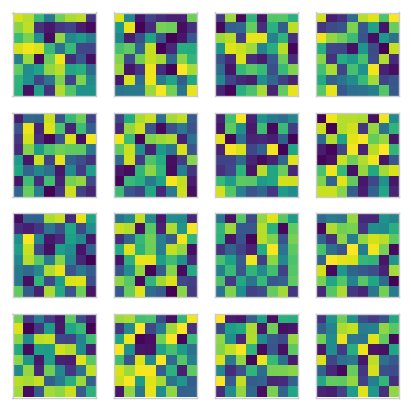

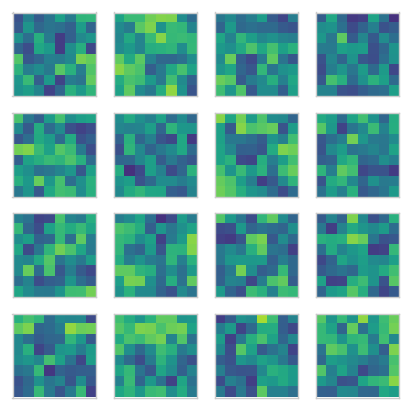

In [7]:
from library.plot import sample_plot, correlation_plot
from library.couplinglayer import apply_flow_to_prior
from library.initial import grab

torch_z = prior.sample_n(1024)
z = grab(torch_z)

torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)

sample_plot(z)
sample_plot(x)

1.276190218530915 10.266219677607888 29.086131967648324 38.51452210600115
slope 1 linear regression S = S_eff + -7.9078


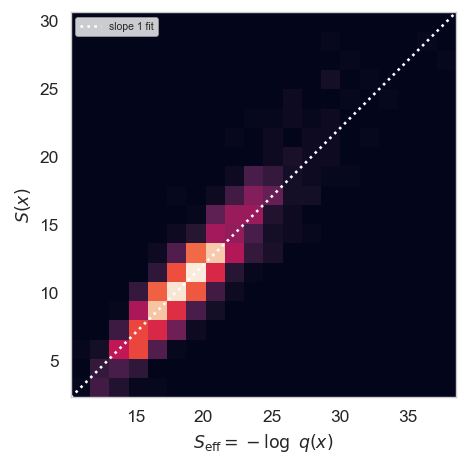

In [8]:
S_eff = -grab(torch_logq)
S = grab(phi4_action(torch_x))
print(min(S), min(S_eff), max(S), max(S_eff))

correlation_plot(S_eff, S)

In [9]:
phi4_ens = flowphi4.make_mcmc_ensemble(N_samples = 8192)

In [10]:
from library.theory import bootstrap

n_therm = 512
cfgs = np.stack(list(map(grab, phi4_ens['x'])), axis=0)[n_therm:]
C = 0
for x in range(L):
    for y in range(L):
        C = C + cfgs*np.roll(cfgs, (-x, -y), axis=(1,2))
X = np.mean(C, axis=(1,2))

X_mean, X_err = bootstrap(X, Nboot=100, binsize=4)
print(f'Two-point susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 0.75 +/- 0.01')

Two-point susceptibility = 0.64 +/- 0.02
... vs HMC estimate = 0.75 +/- 0.01


In [16]:
from library.theory import U1GaugeAction
from library.couplinglayer import MultivariateUniform, make_u1_equiv_layers, set_weights
#Lattice parameters
L = 8
lattice_shape = (L, L)
link_shape = (2, L, L)
u1_action = U1GaugeAction(beta = 2.0)

#Model
prior = MultivariateUniform(torch.zeros(link_shape), 2*np.pi*torch.ones(link_shape))
layers = make_u1_equiv_layers(lattice_shape = lattice_shape, n_layers = 16, n_mixture_comps = 2,
                            hidden_sizes = [8, 8], kernel_size = 3)
set_weights(layers)
model = {'layers': layers, 'prior': prior}

In [17]:
flowu1gauge = DiscreteFlow(model = model, action = u1_action, loss_fn = calc_dkl,
                        optimizer = torch.optim.Adam(model['layers'].parameters(), lr = 0.001),
                        batch_size = 64, N_era = 20, N_epoch = 100)

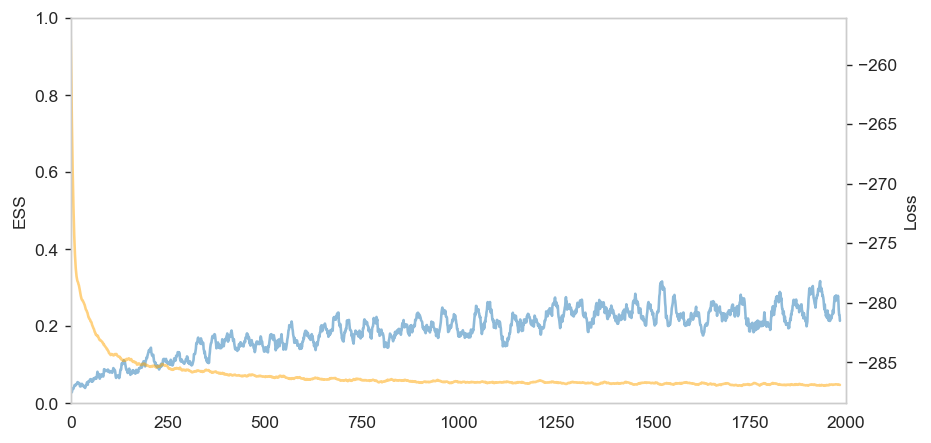

 == Era 0 | Epoch 0 metrics
	loss -238.055
	logp 3.01405
	logq -235.041
	ess 0.0156466
 == Era 1 | Epoch 0 metrics
	loss -278.042
	logp 68.0051
	logq -210.037
	ess 0.057438
 == Era 2 | Epoch 0 metrics
	loss -284.737
	logp 81.3537
	logq -203.383
	ess 0.08571
 == Era 3 | Epoch 0 metrics
	loss -285.408
	logp 83.0644
	logq -202.343
	ess 0.111726
 == Era 4 | Epoch 0 metrics
	loss -285.755
	logp 83.7425
	logq -202.013
	ess 0.139116
 == Era 5 | Epoch 0 metrics
	loss -286.088
	logp 84.4216
	logq -201.666
	ess 0.159878
 == Era 6 | Epoch 0 metrics
	loss -286.247
	logp 84.7643
	logq -201.482
	ess 0.160959
 == Era 7 | Epoch 0 metrics
	loss -286.382
	logp 85.0315
	logq -201.351
	ess 0.184449
 == Era 8 | Epoch 0 metrics
	loss -286.498
	logp 85.0829
	logq -201.415
	ess 0.190507
 == Era 9 | Epoch 0 metrics
	loss -286.539
	logp 85.3525
	logq -201.187
	ess 0.184044
 == Era 10 | Epoch 0 metrics
	loss -286.631
	logp 85.3419
	logq -201.289
	ess 0.208841
 == Era 11 | Epoch 0 metrics
	loss -286.662
	logp 85.

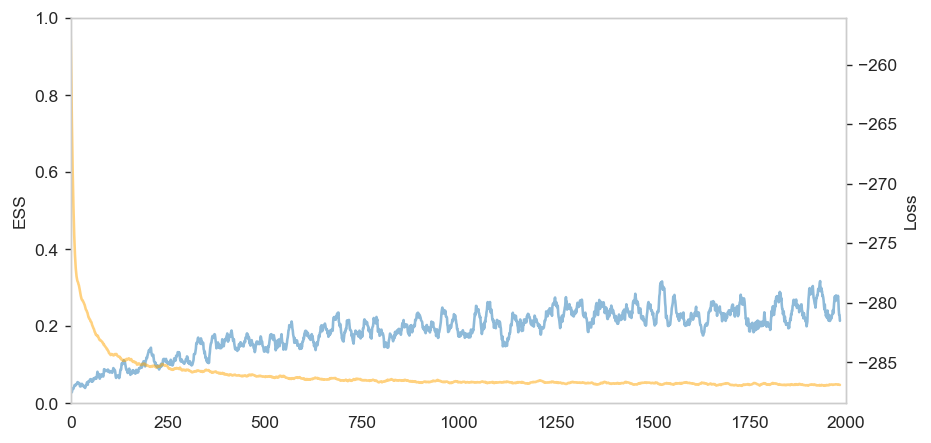

In [18]:
flowu1gauge.run()

In [2]:
# print(flowu1gauge.blob)

-109.24864270996636 178.8130144849903 -65.51862164813613 219.89246839532532
slope 1 linear regression S = S_eff + -286.8818


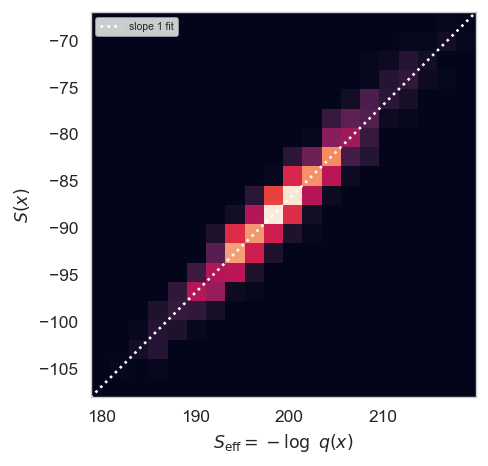

In [20]:
torch_z = prior.sample_n(1024)
z = grab(torch_z)

torch_x, torch_logq = apply_flow_to_prior(prior, layers, batch_size=1024)
x = grab(torch_x)

S_eff = -grab(torch_logq)
S = grab(u1_action(torch_x))
print(min(S), min(S_eff), max(S), max(S_eff))

correlation_plot(S_eff, S)

In [21]:
u1_ens = flowu1gauge.make_mcmc_ensemble(N_samples = 8192)
print("Accept rate:", np.mean(u1_ens['accepted']))
print("Accept rate:", np.mean(phi4_ens['accepted']))

Accept rate: 0.303955078125
Accept rate: 0.277587890625


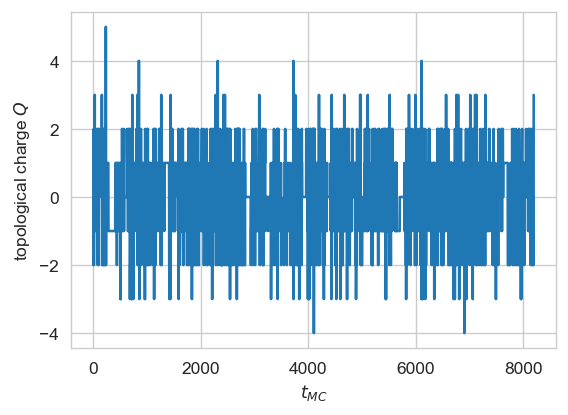

In [22]:
from library.theory import topo_charge
import matplotlib.pyplot as plt

Q = grab(topo_charge(torch.stack(u1_ens['x'], axis=0)))
plt.figure(figsize=(5,3.5), dpi=125)
plt.plot(Q)
plt.xlabel(r'$t_{MC}$')
plt.ylabel(r'topological charge $Q$')
plt.show()

In [23]:
X_mean, X_err = bootstrap(Q**2, Nboot = 100, binsize=16)
print(f'Topological susceptibility = {X_mean:.2f} +/- {X_err:.2f}')
print(f'... vs HMC estimate = 1.23 +/- 0.02')

Topological susceptibility = 1.17 +/- 0.04
... vs HMC estimate = 1.23 +/- 0.02
